In [2]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
from scipy import stats
from scipy.stats import ttest_ind
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from pandas.plotting import parallel_coordinates
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [3]:
raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine_final.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
# Number of errors
# display(len(raw_data.loc[raw_data['errors']==1]))
# # display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)

### Utils

In [4]:
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    print('discriminating bias is:', max_abs_bias)
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Hierarchical Bias-Aware MeanShift Clustering 

In [5]:
full_data = initialize_dataset(raw_data)
bandwidth_features = full_data.iloc[: , : 14]
# bandwidth_features = full_data.iloc[: , : 11]
# bandwidth_features = full_data.iloc[: , : 25]
bandwidth_features.head()
estimate_bandwidth(bandwidth_features)

4.08630470242124

In [6]:
full_data = initialize_dataset(raw_data)
full_data.head()

# pca_plot(full_data, 'Compas', 0.6)

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
39   1.505019    1.494574  0.630750          -1.590260   1.470062   
176  0.170050    0.270648  0.155921           0.320862   1.017252   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
118      -0.988536   -0.762724              0.599286        -1.234524   
39        1.074278    0.907054             -1.248791         0.733019   
176      -0.958422   -1.294440              1.402798        -0.242882   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
104        -1.025689  0.361193     1.354564 -0.225753            0.0   
67         -0.239382  0.710266     1.229242 -0.714467            0.0   
118        -0.817815 -1.122366    -0.664518 -1.130778            0.8   
39         -0.049584 -0.293318     1.298865  0.039721            0.0   
176         1.848400 -1.558707    -1.360753  0.281061            0.0   

     predicted_class  true_class  errors  clusters  new_clusters  
104                1           1       0         0            -1  
67                 1           1       0         0            -1  
118                2           1       1         0            -1  
39                 0           0       0         0            -1  
176                2           2       0         0            -1

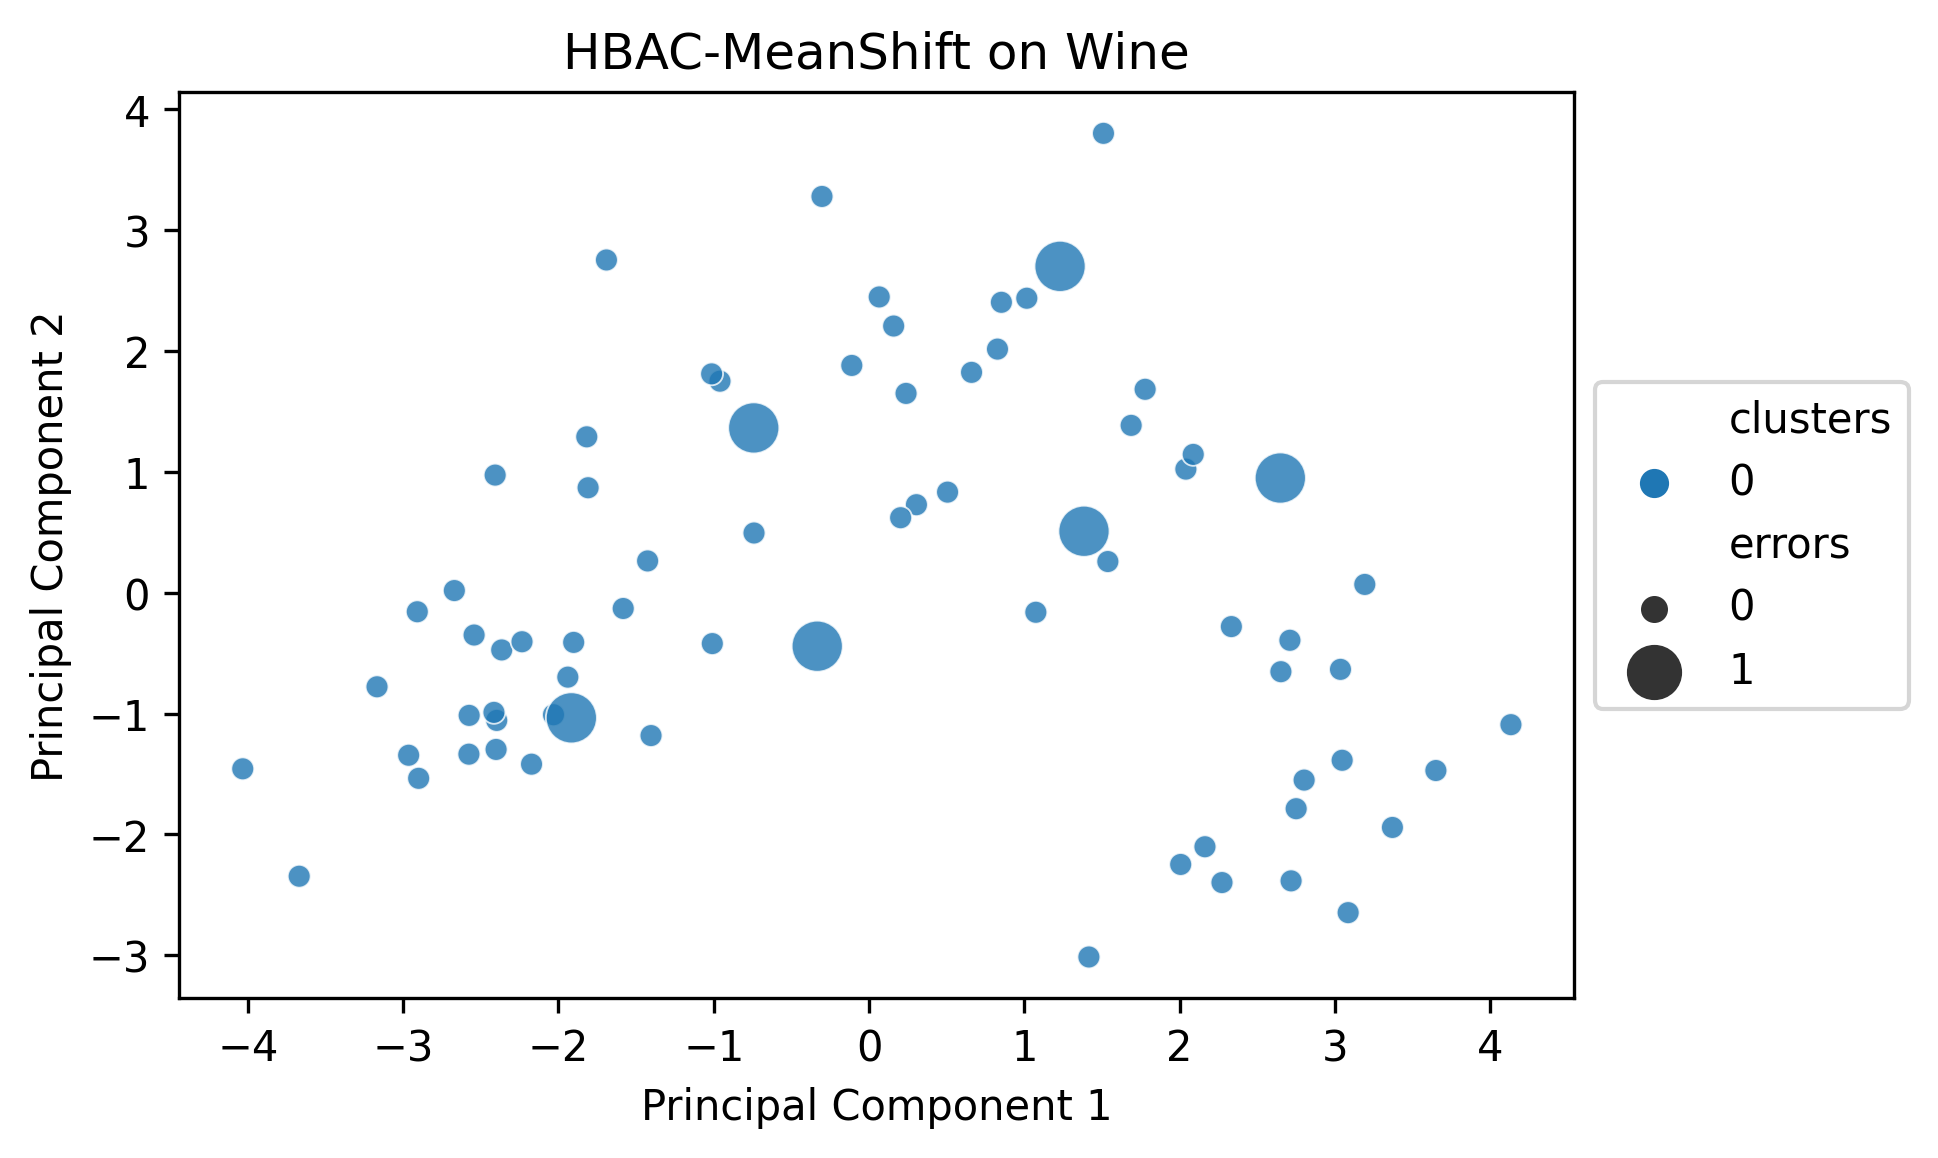

average_accuracy is:  0.9166666666666666
This is the current cluster:  0
discriminating bias is: -999999
smallest cluster: 1


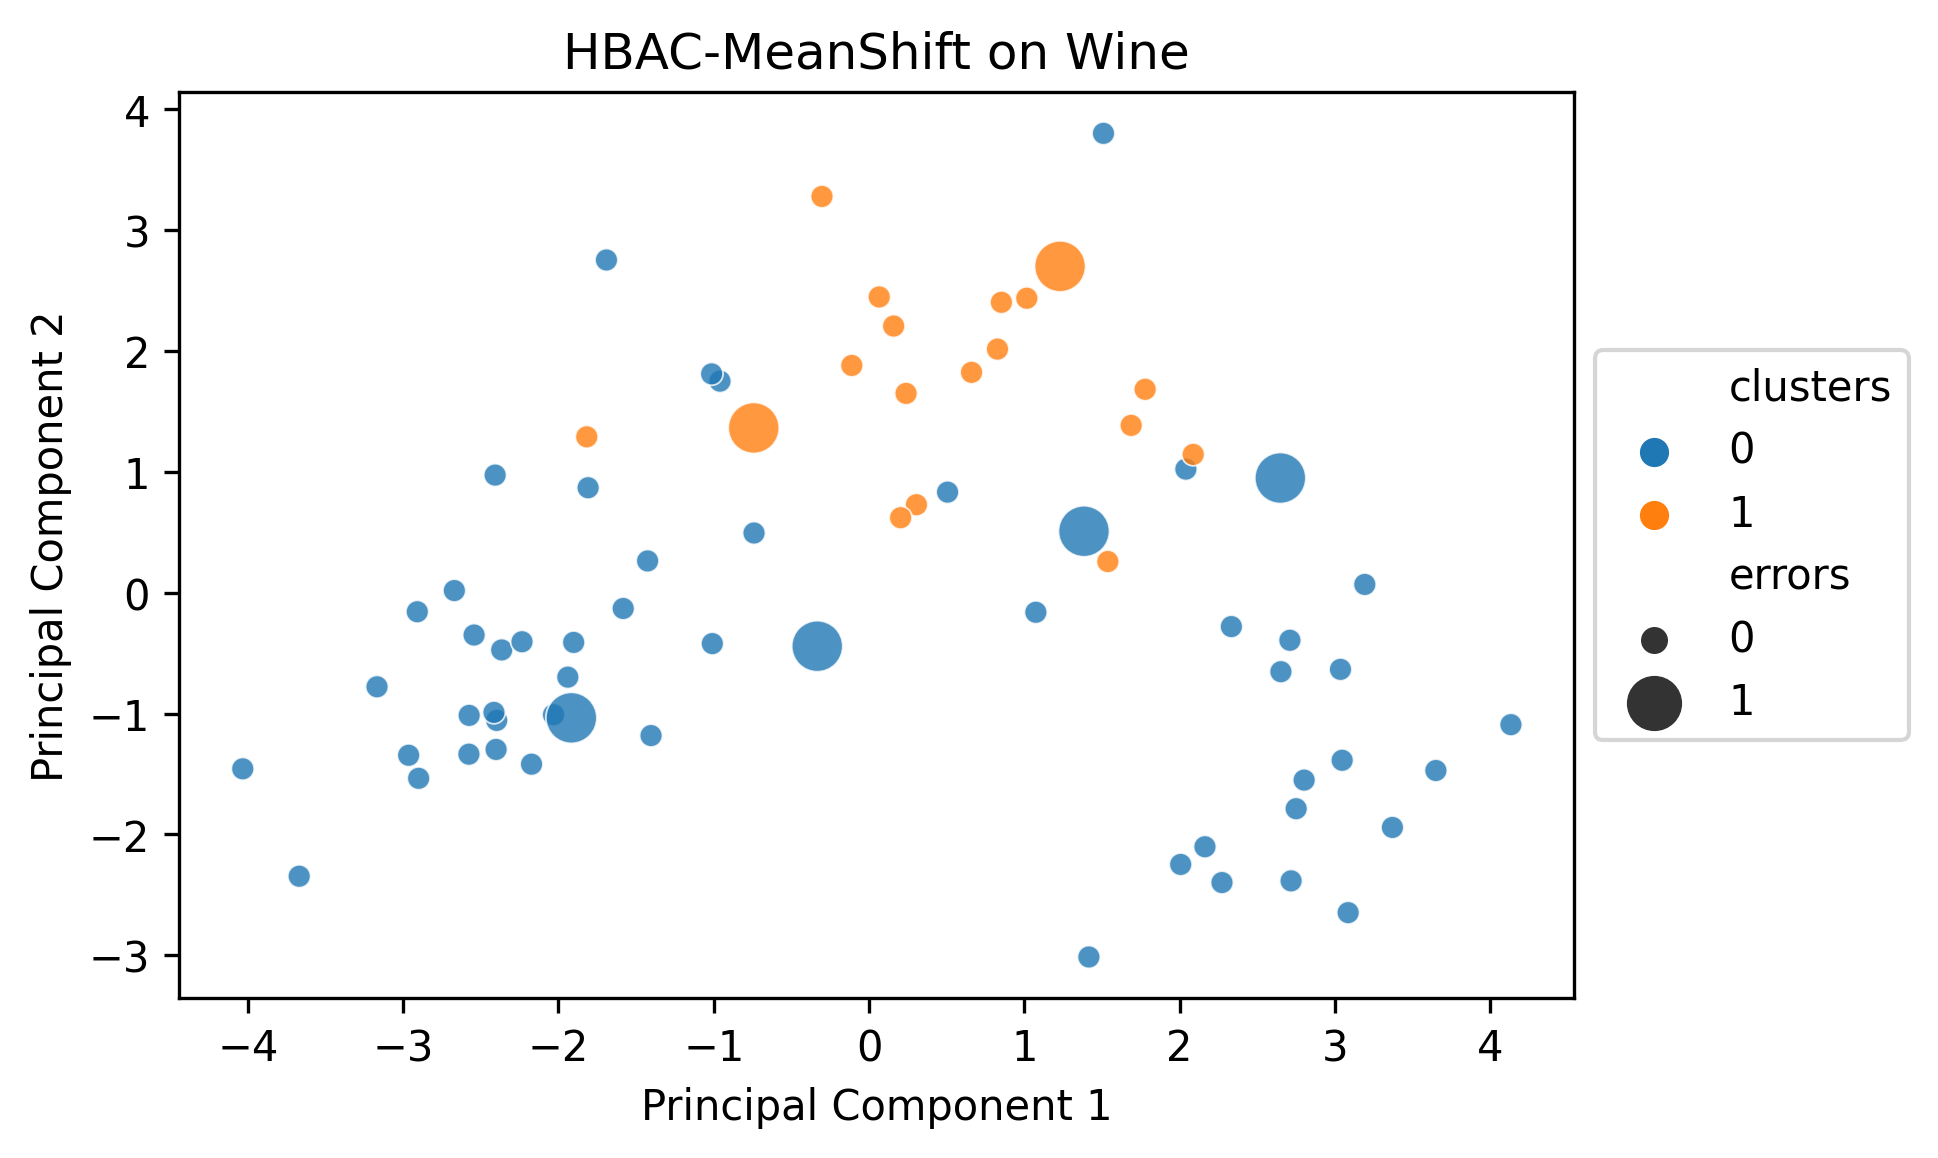

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


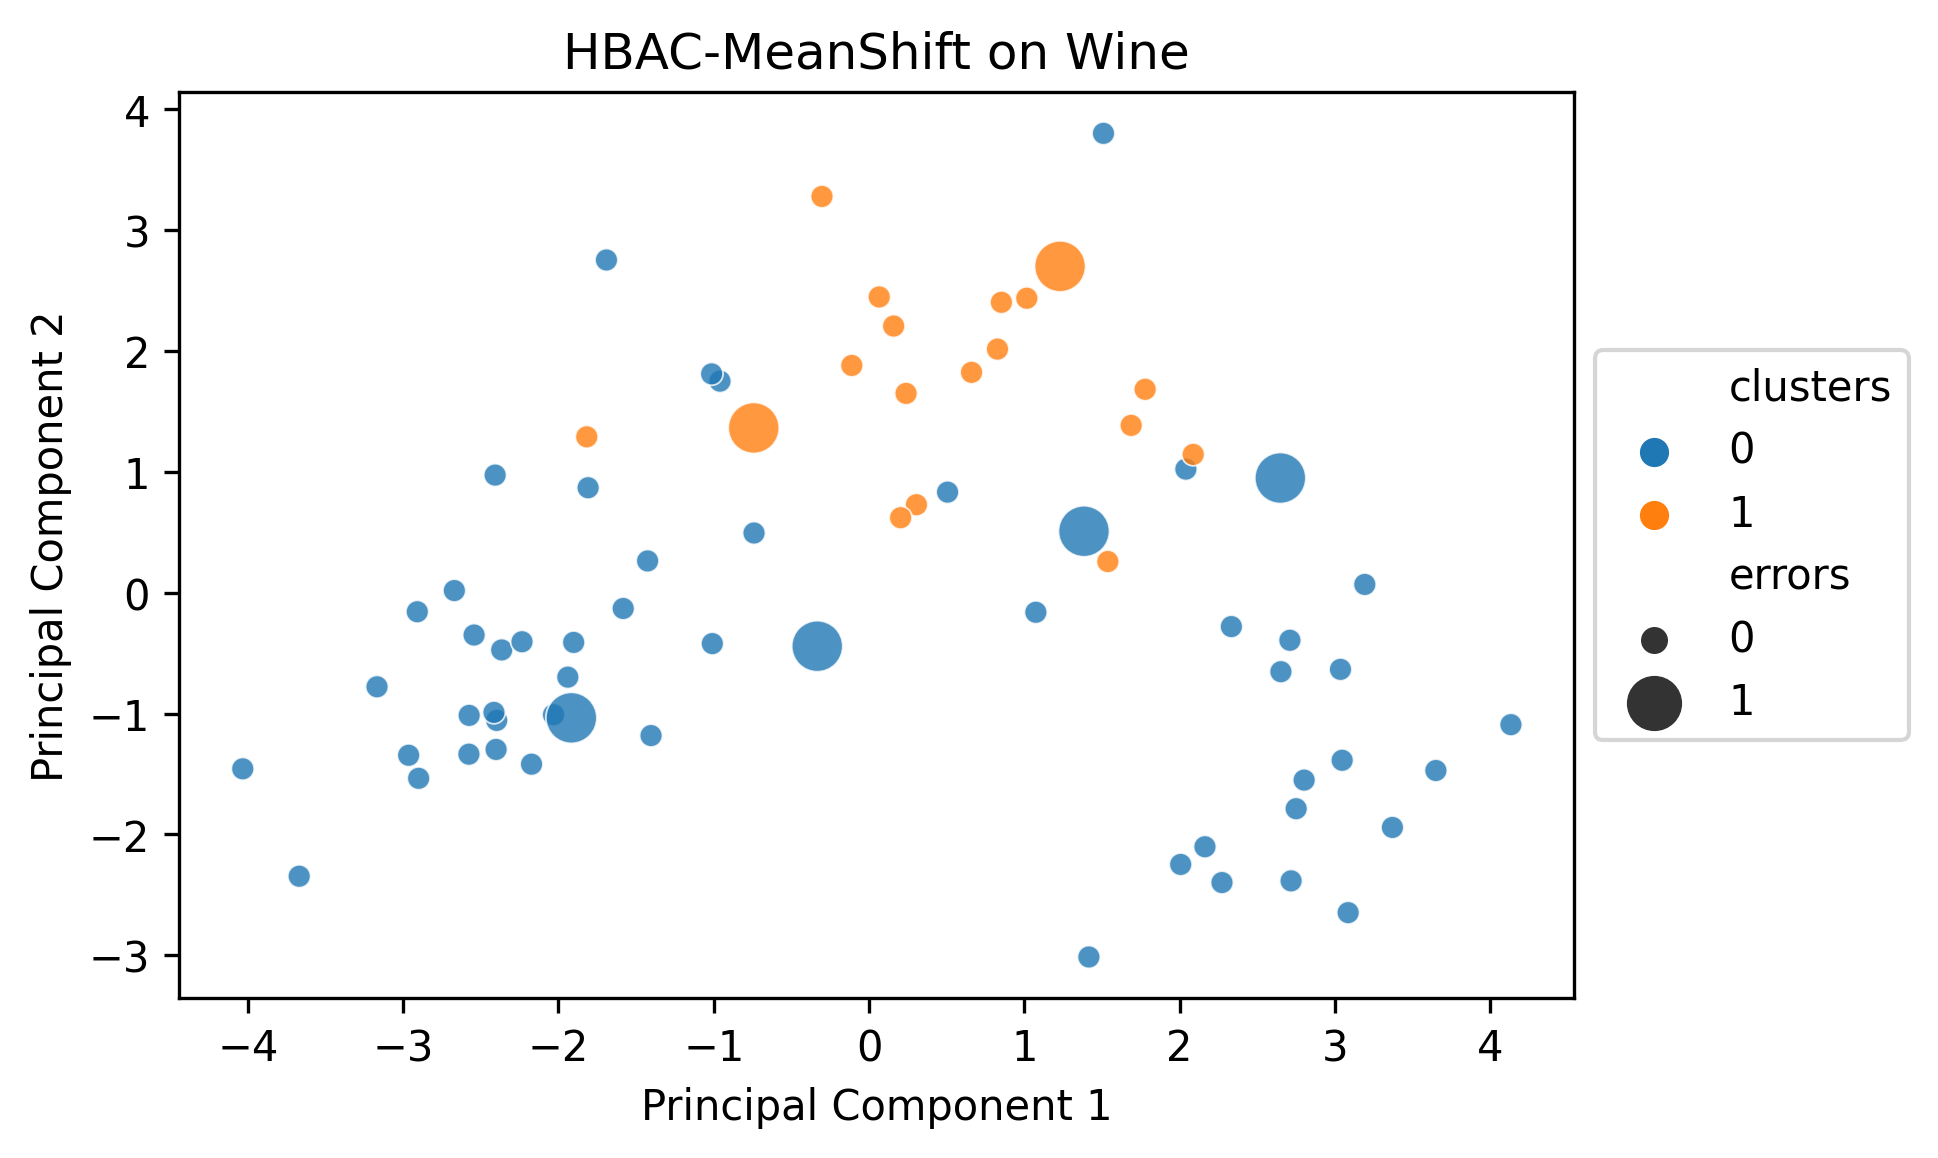

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


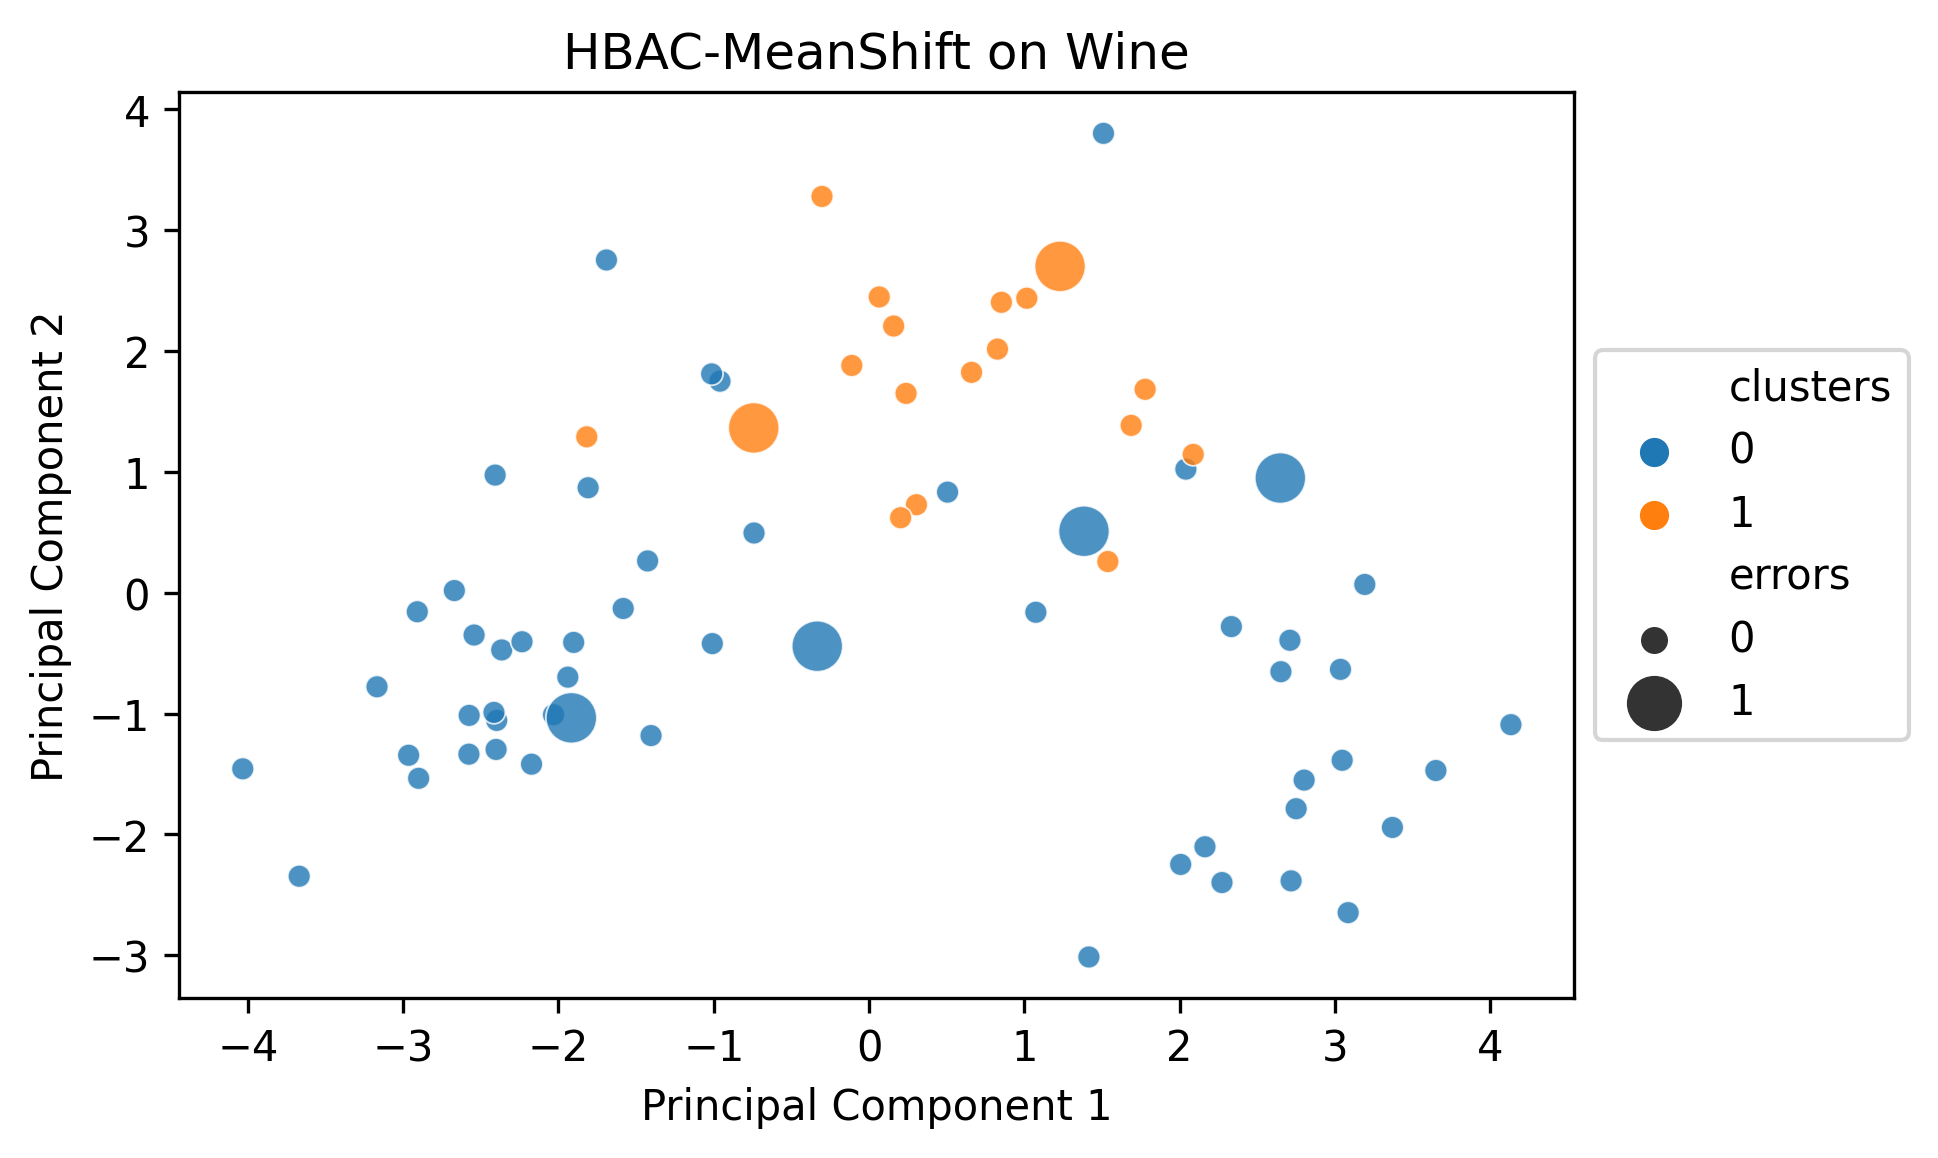

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


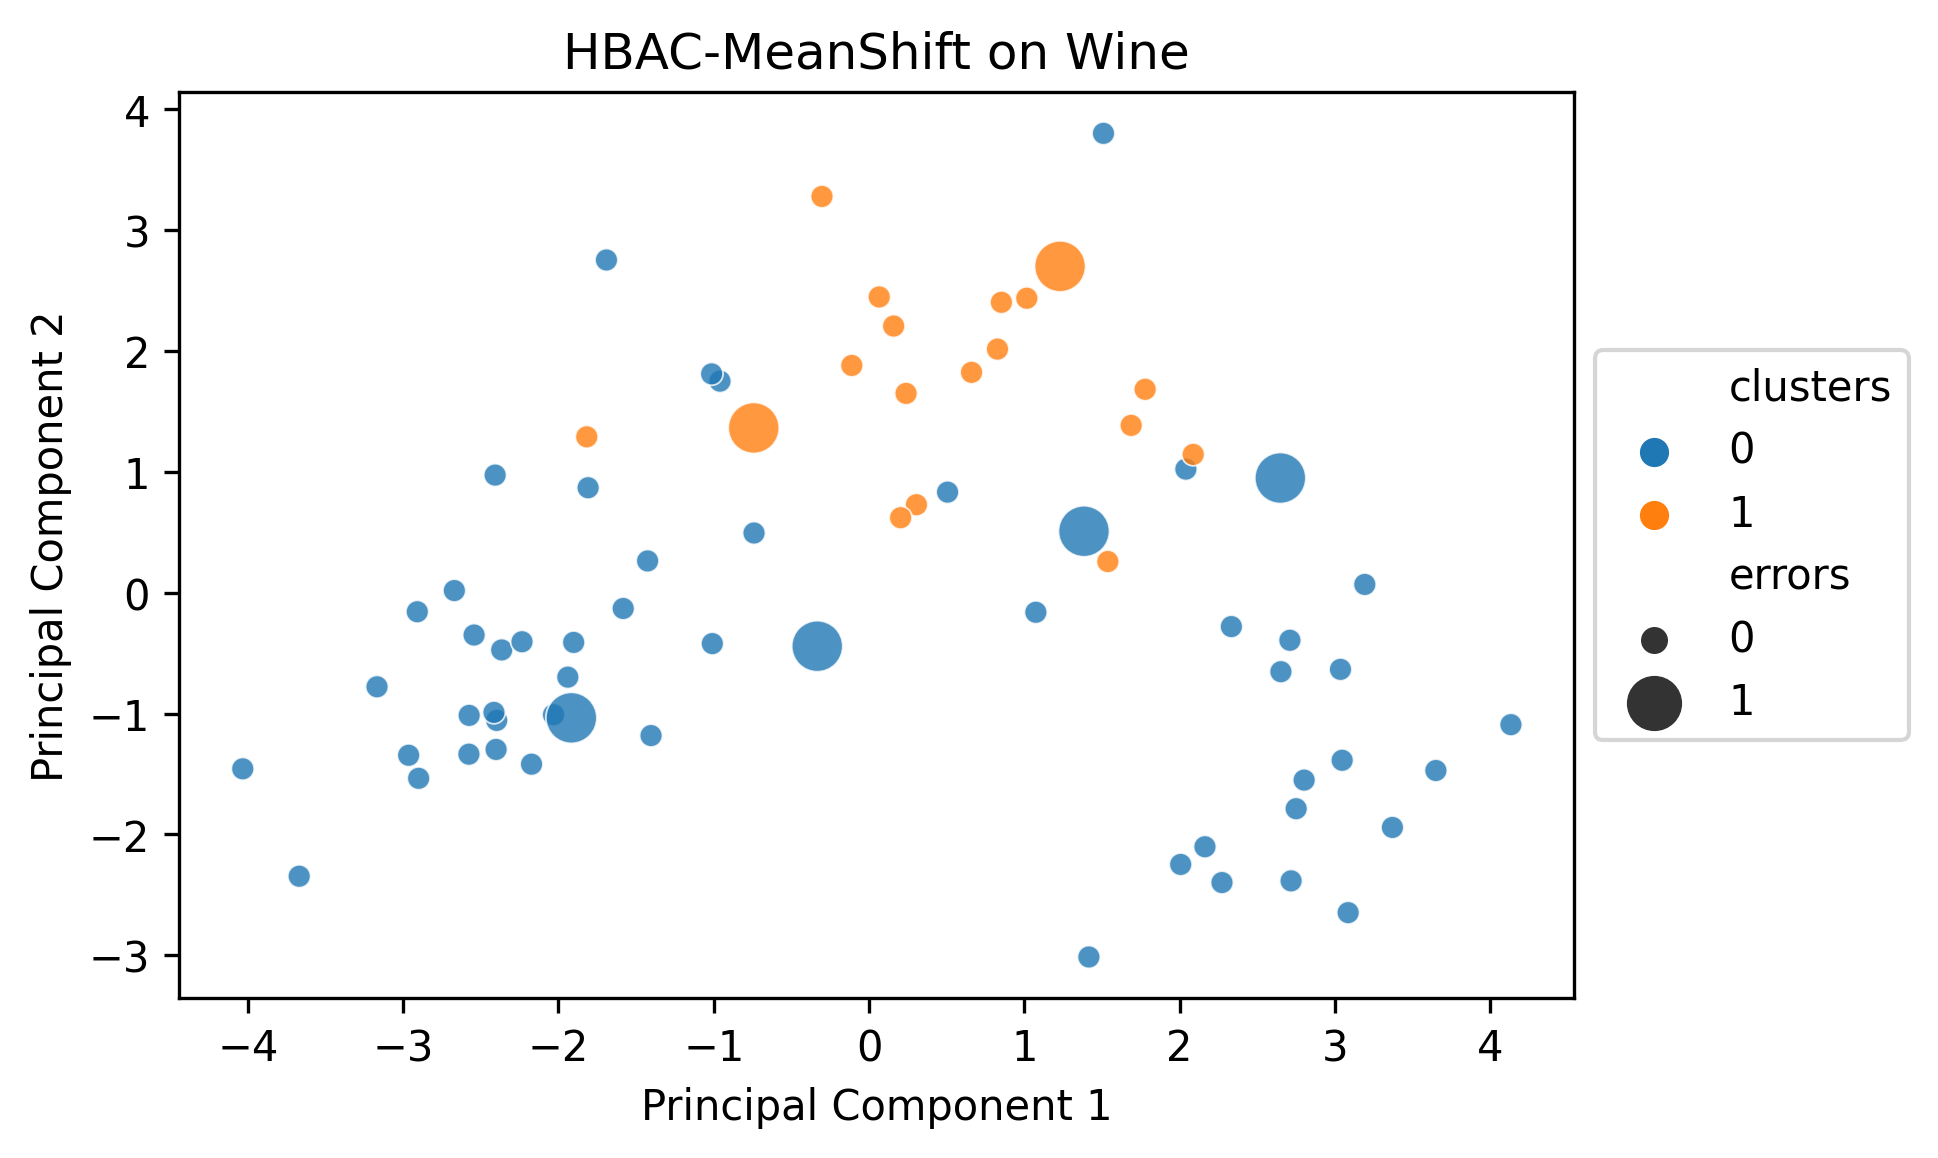

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


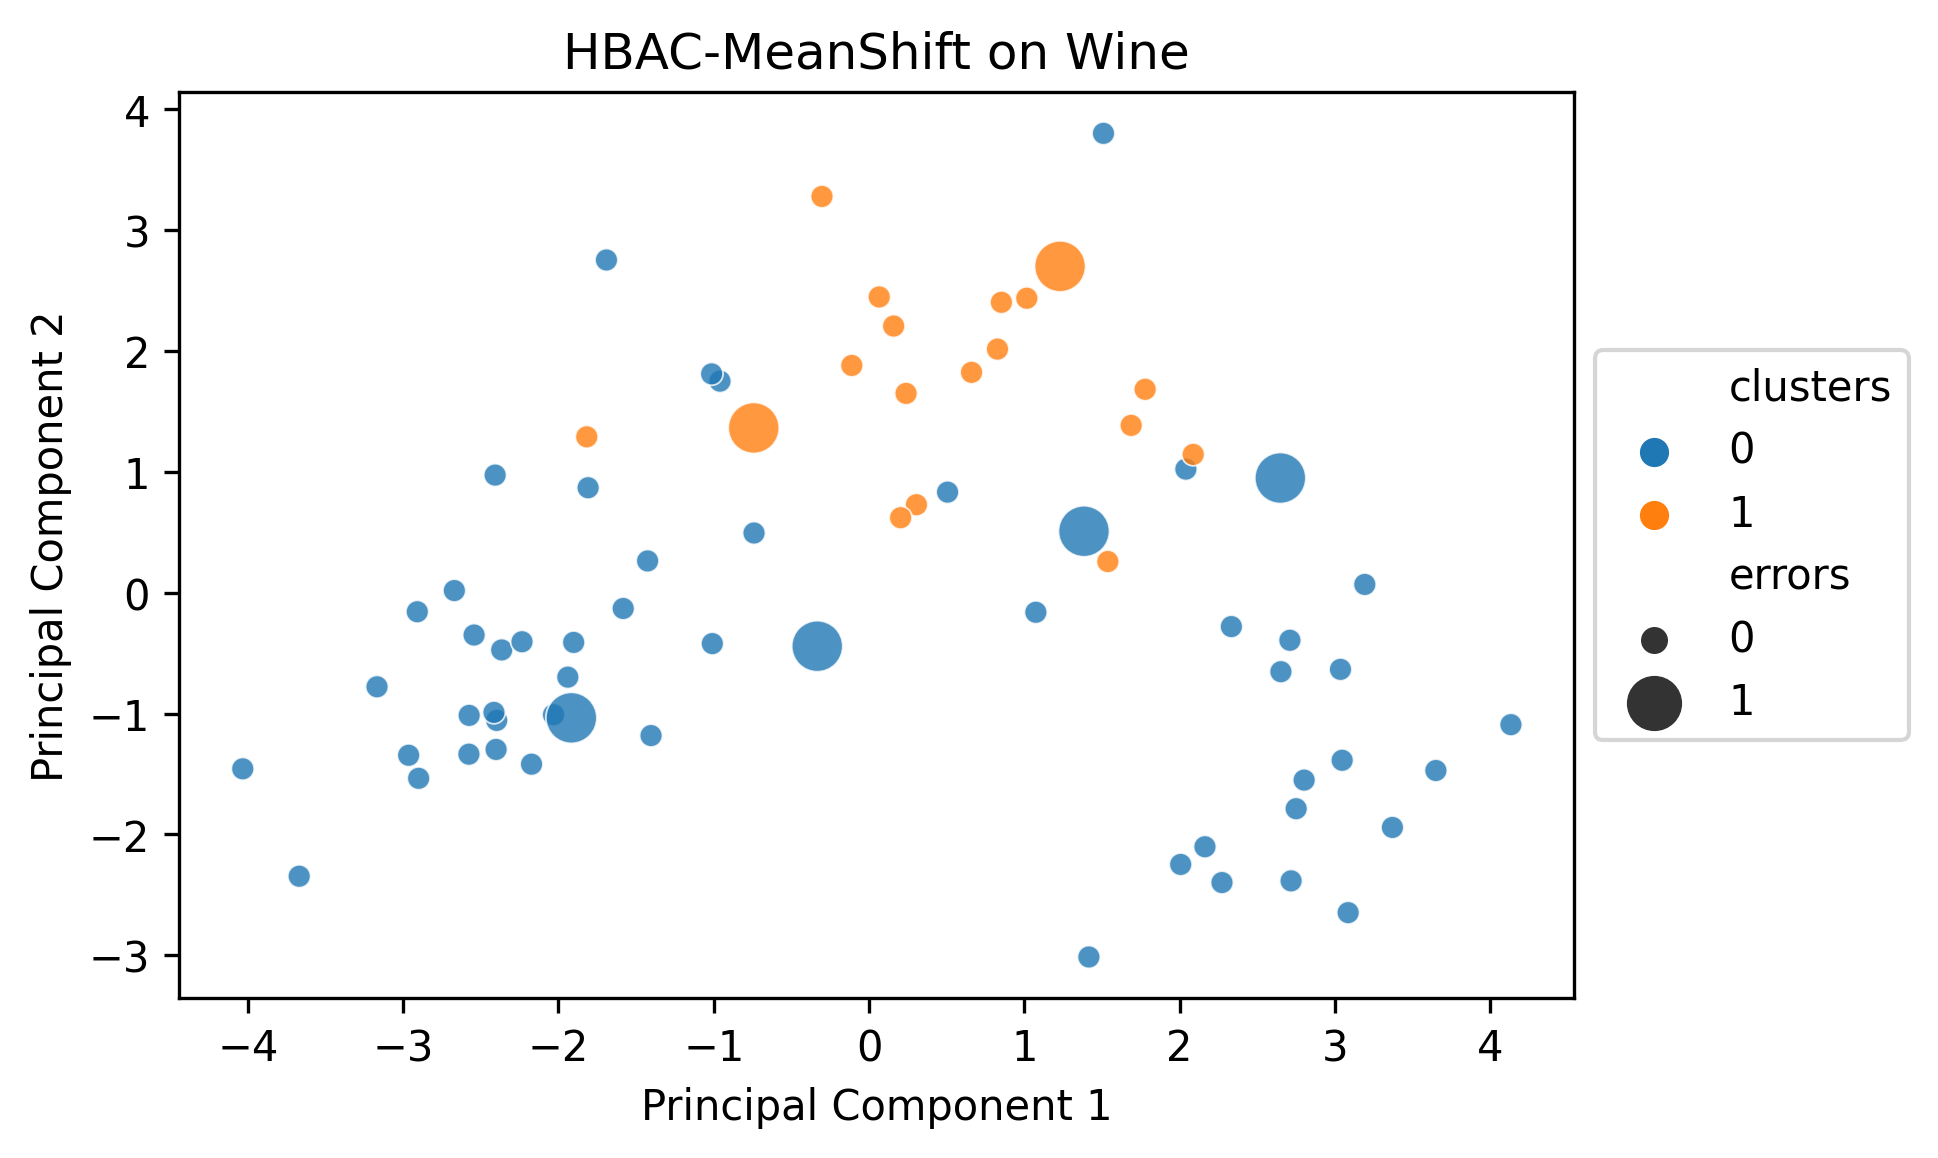

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


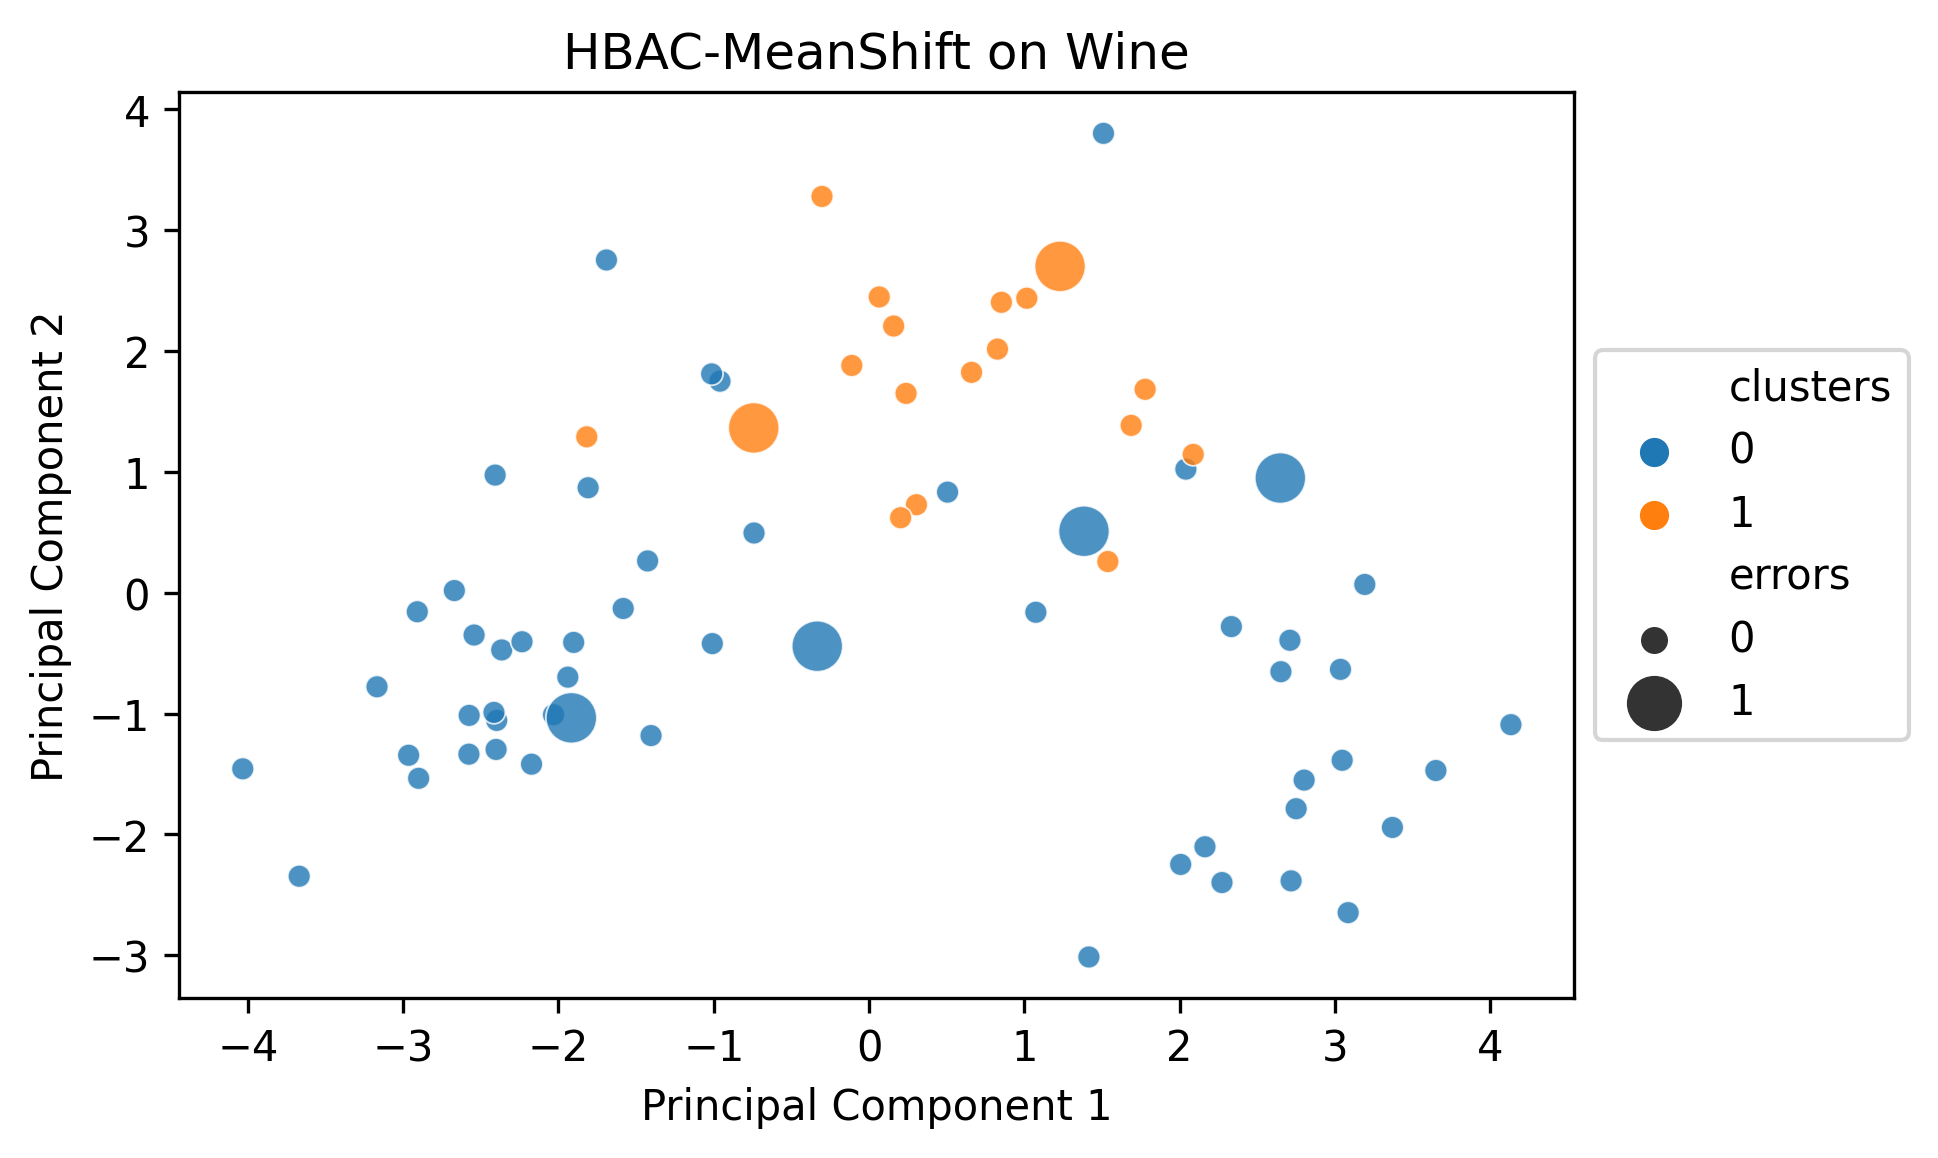

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


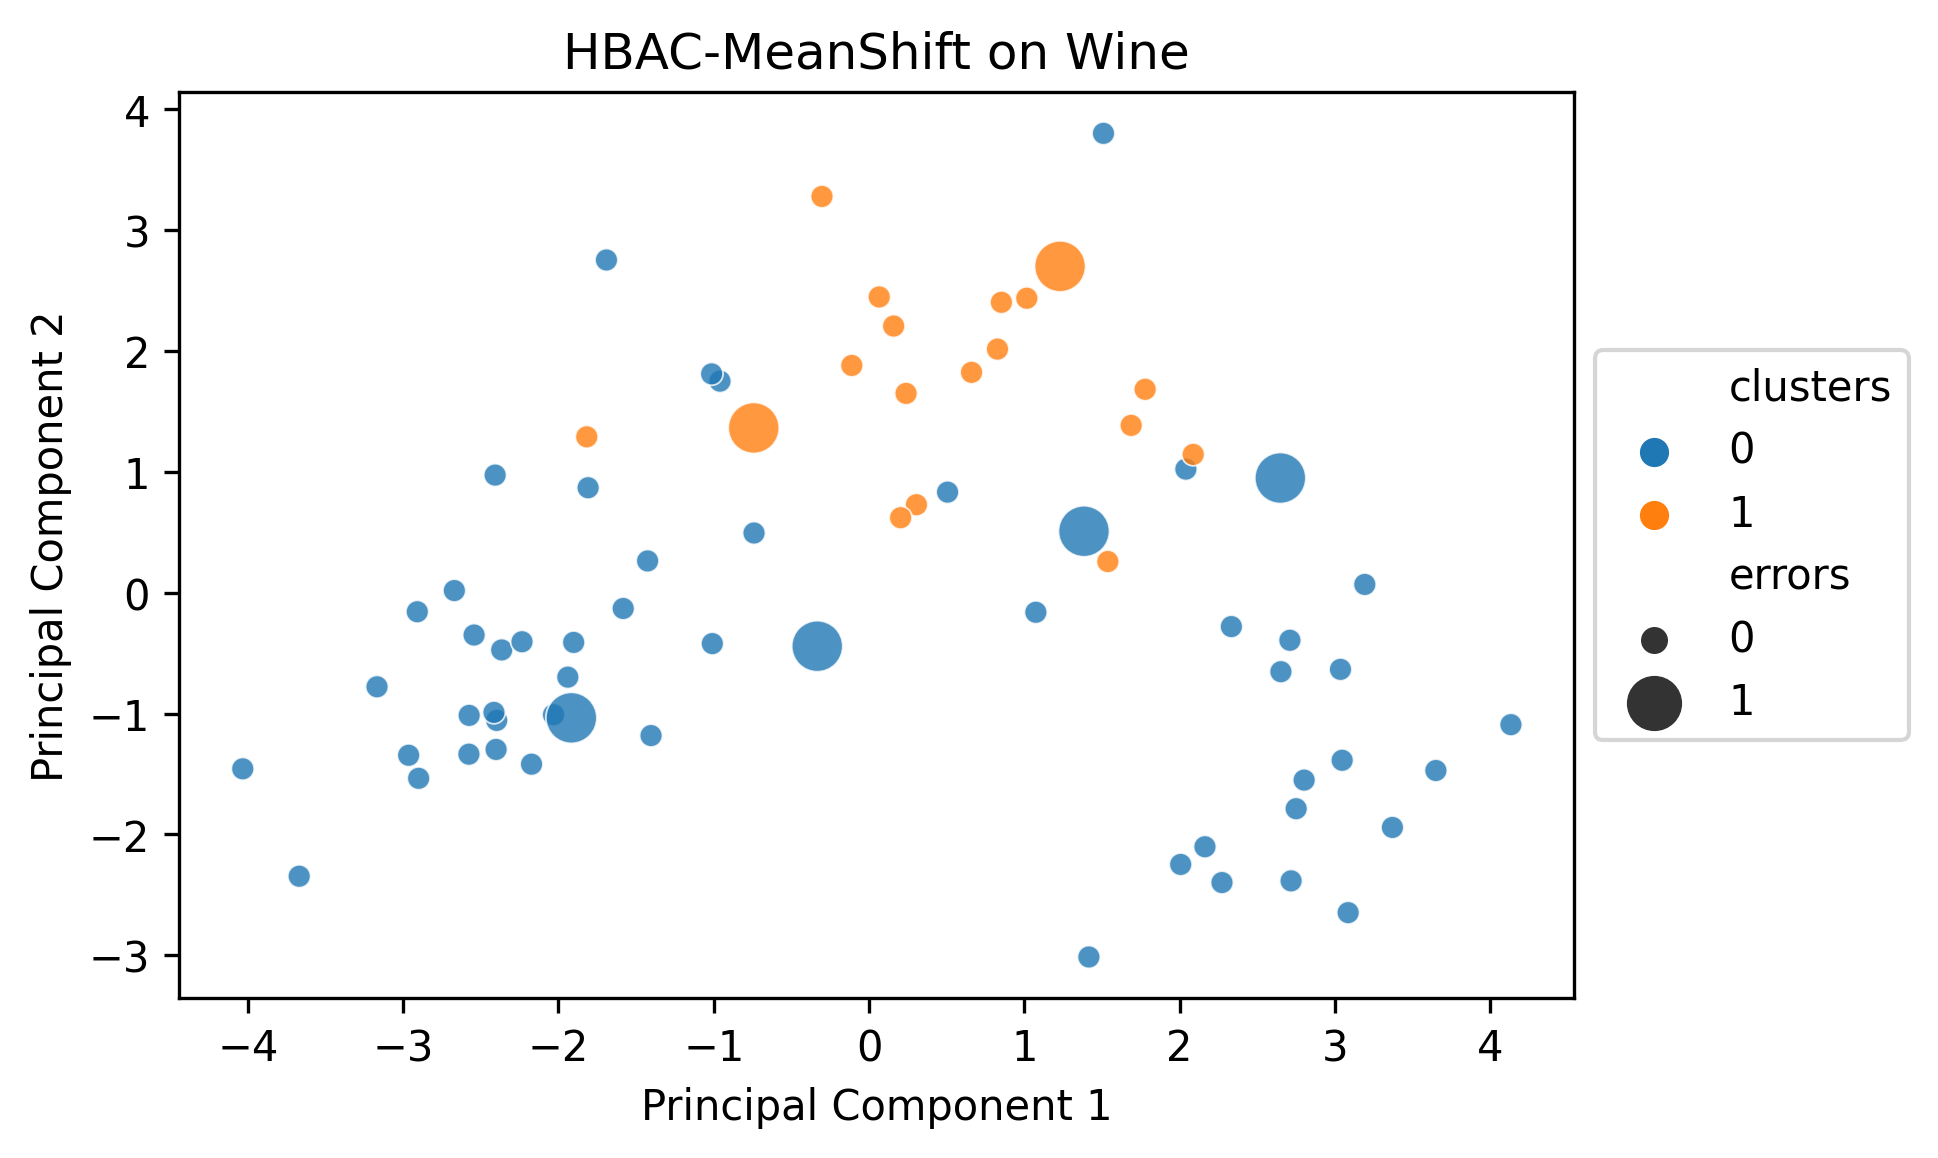

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


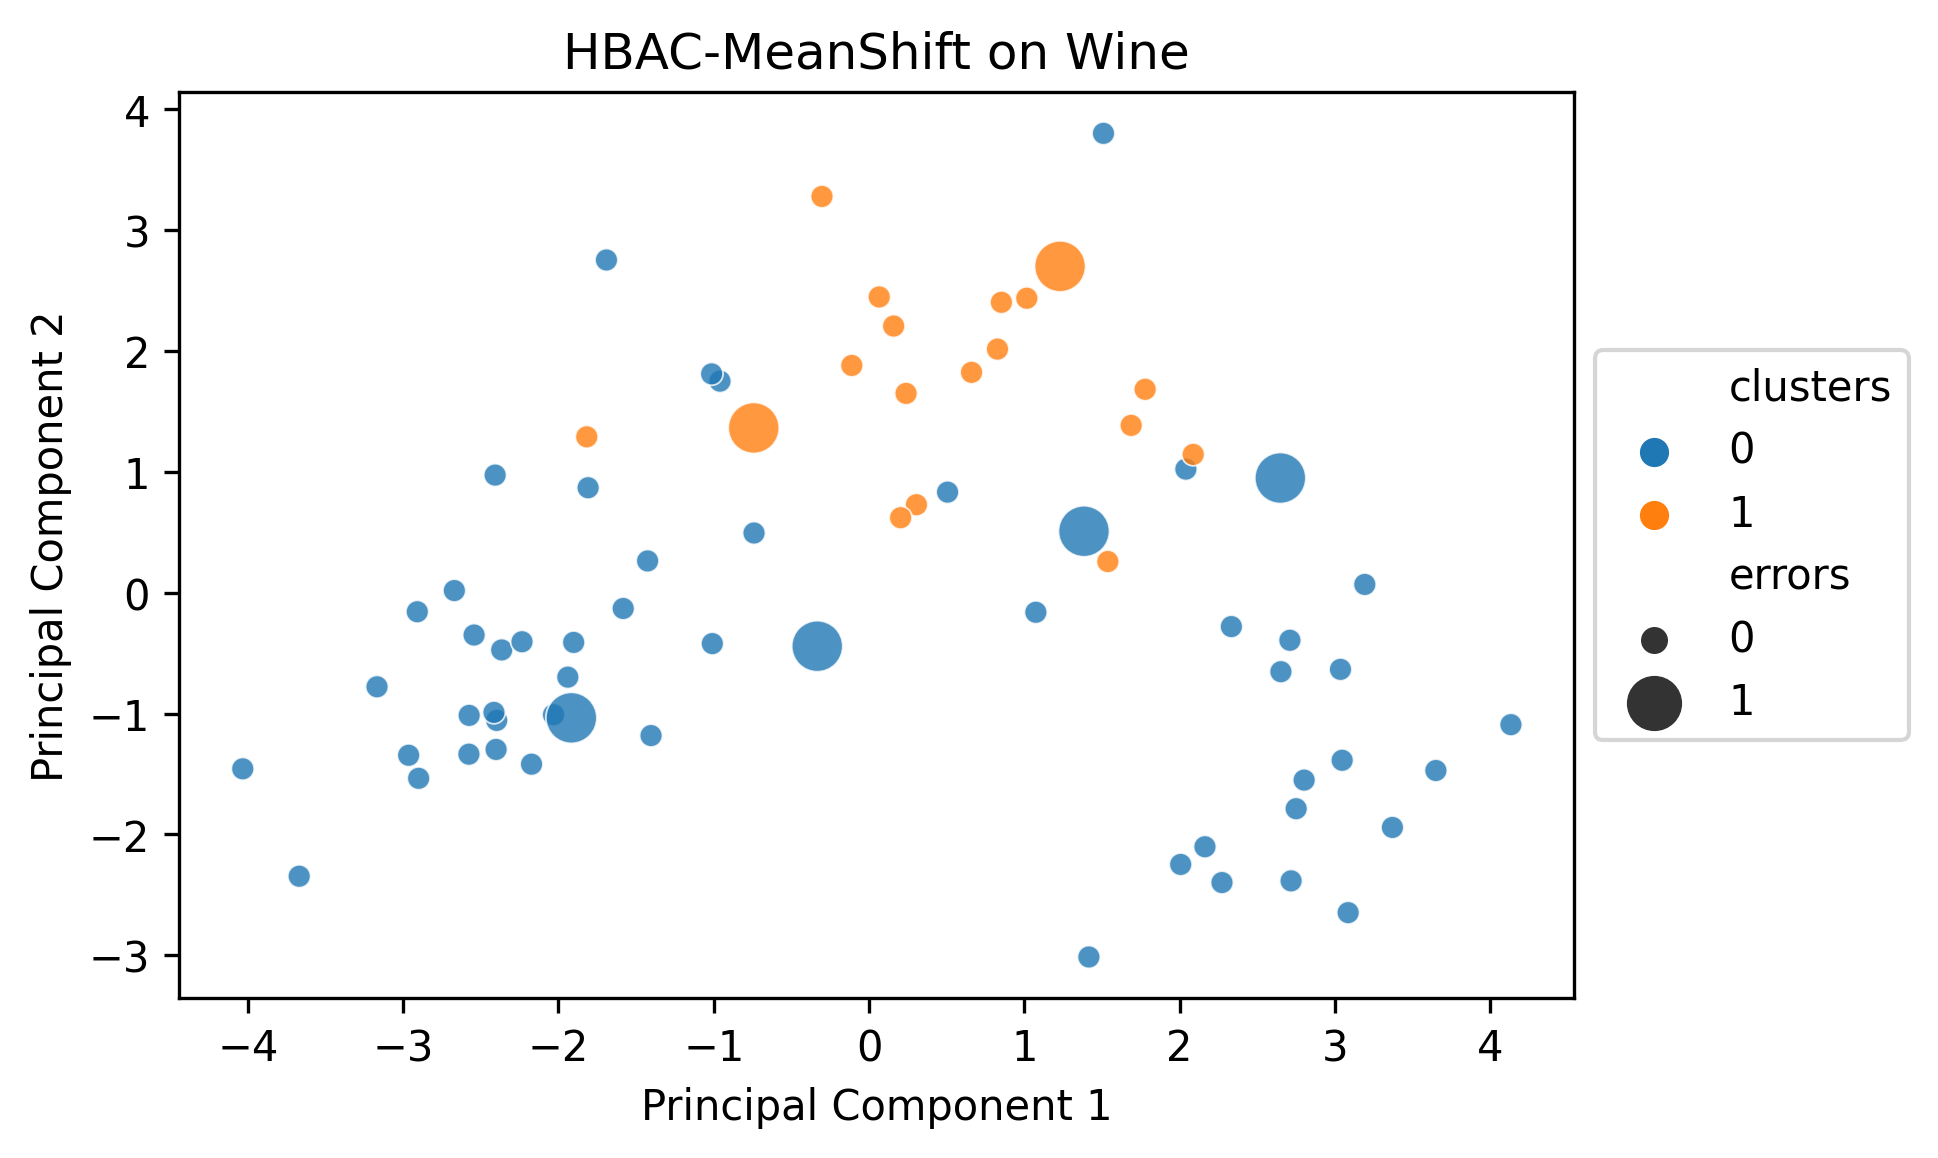

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


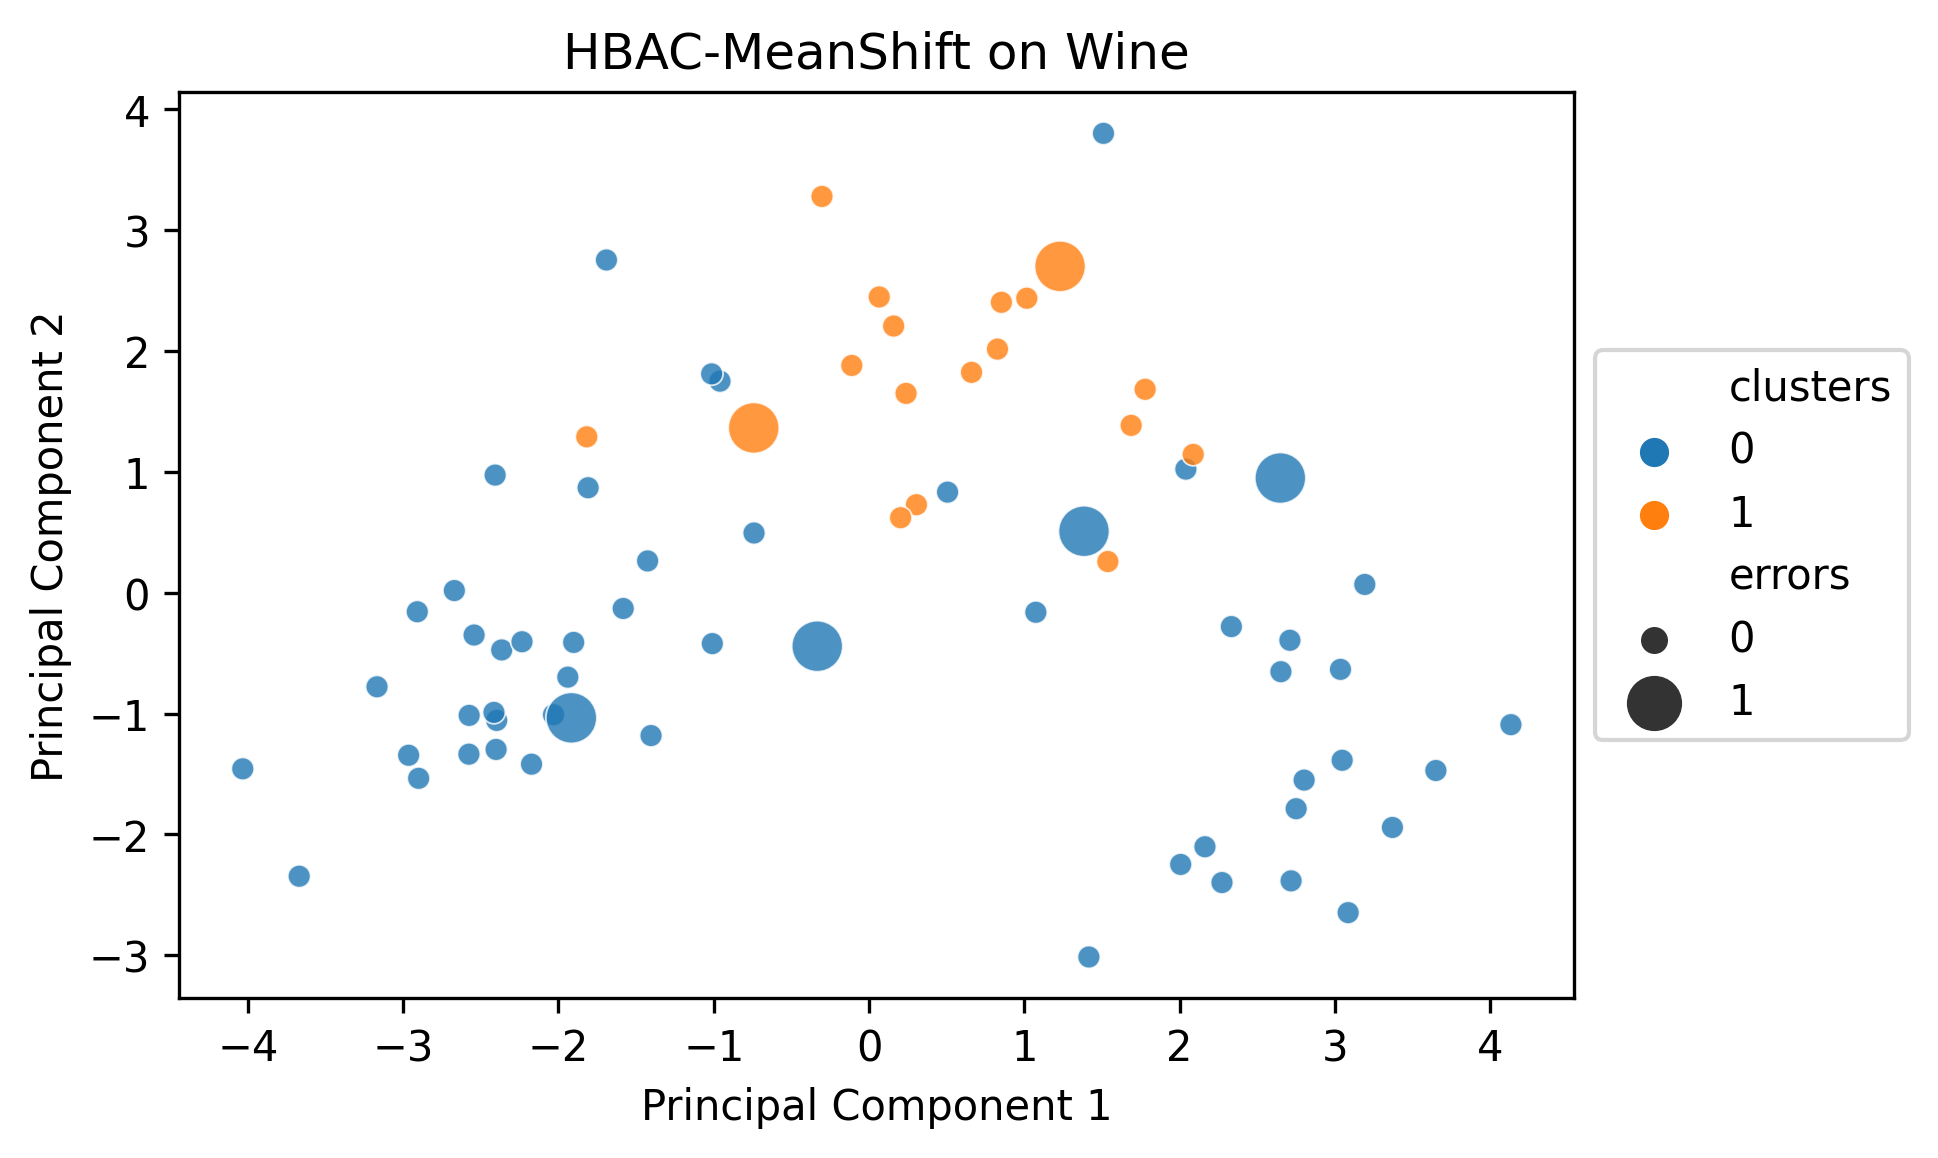

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


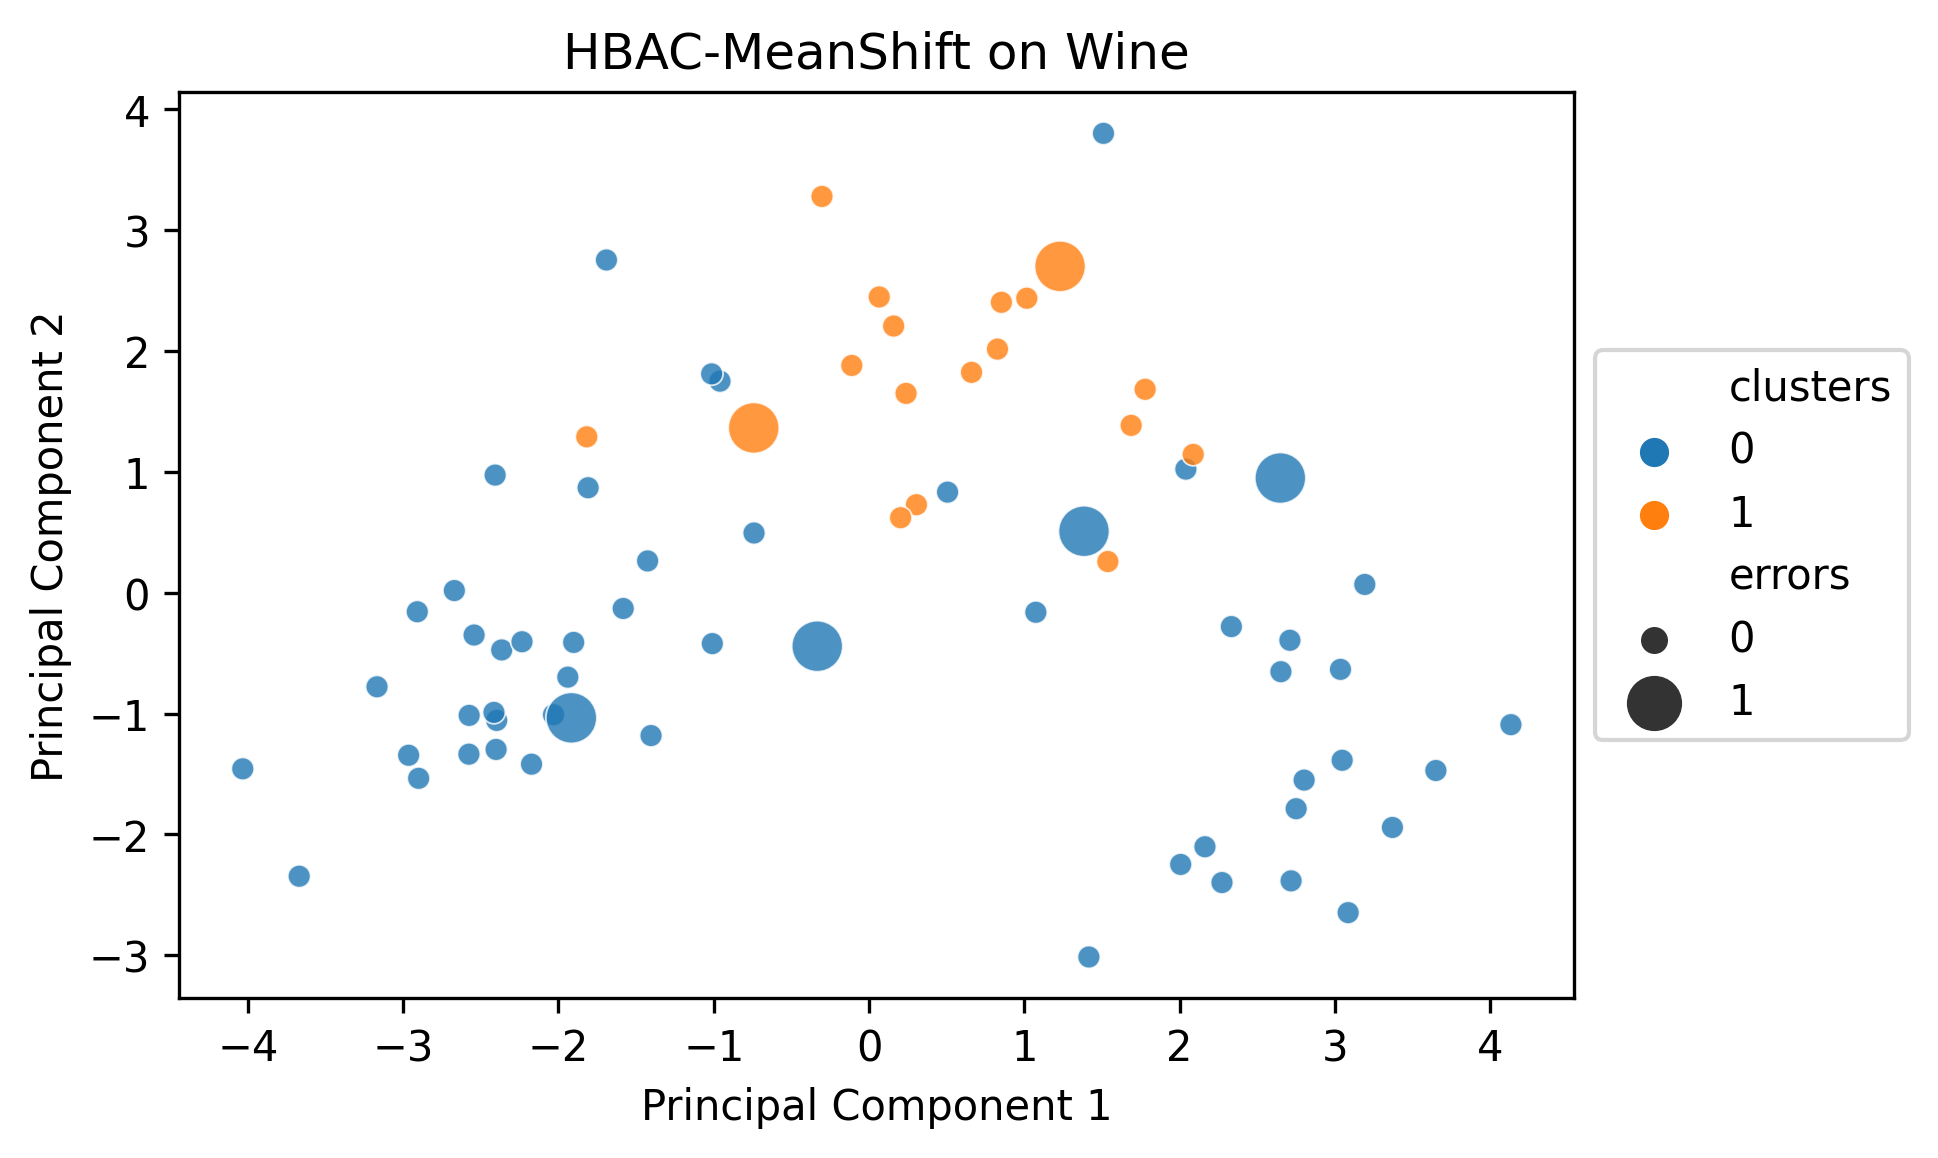

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


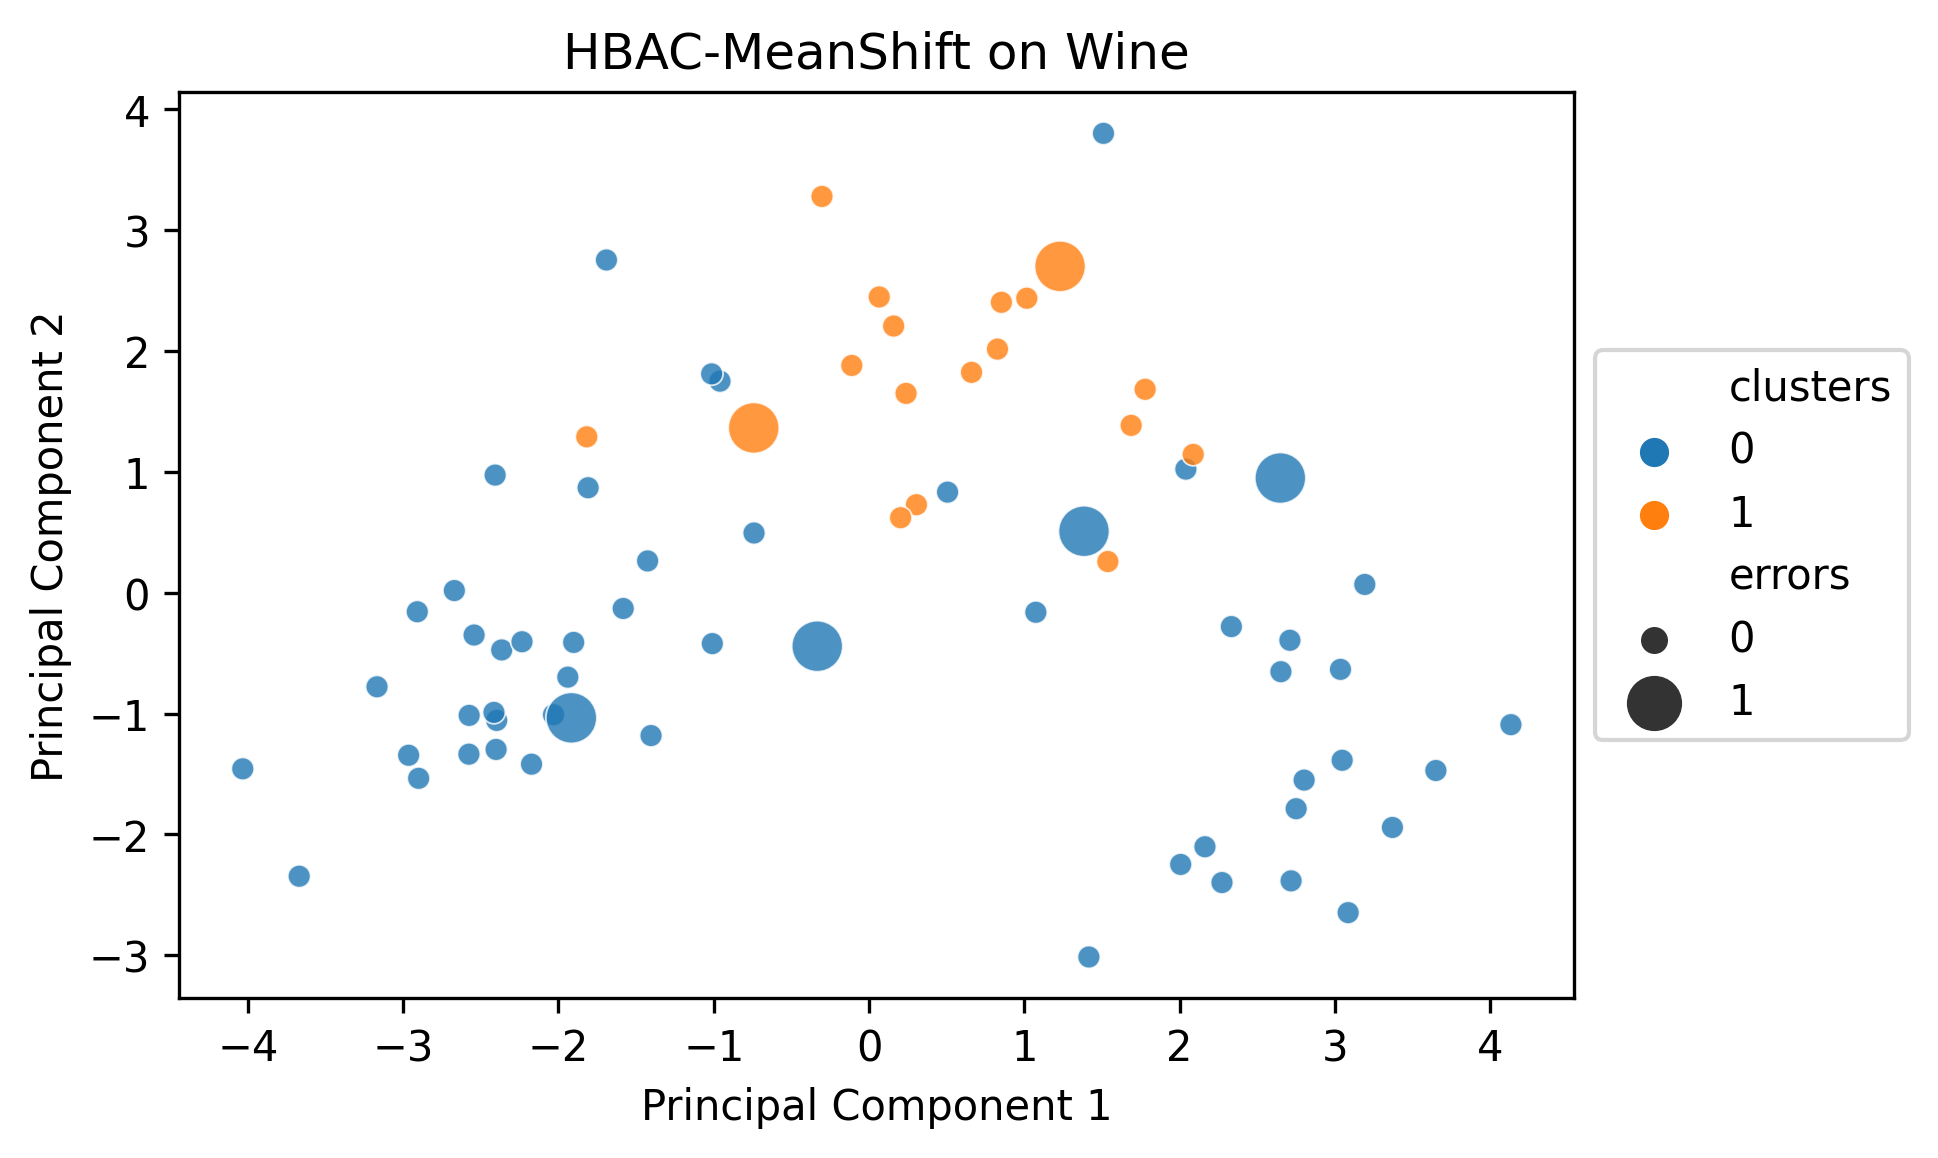

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


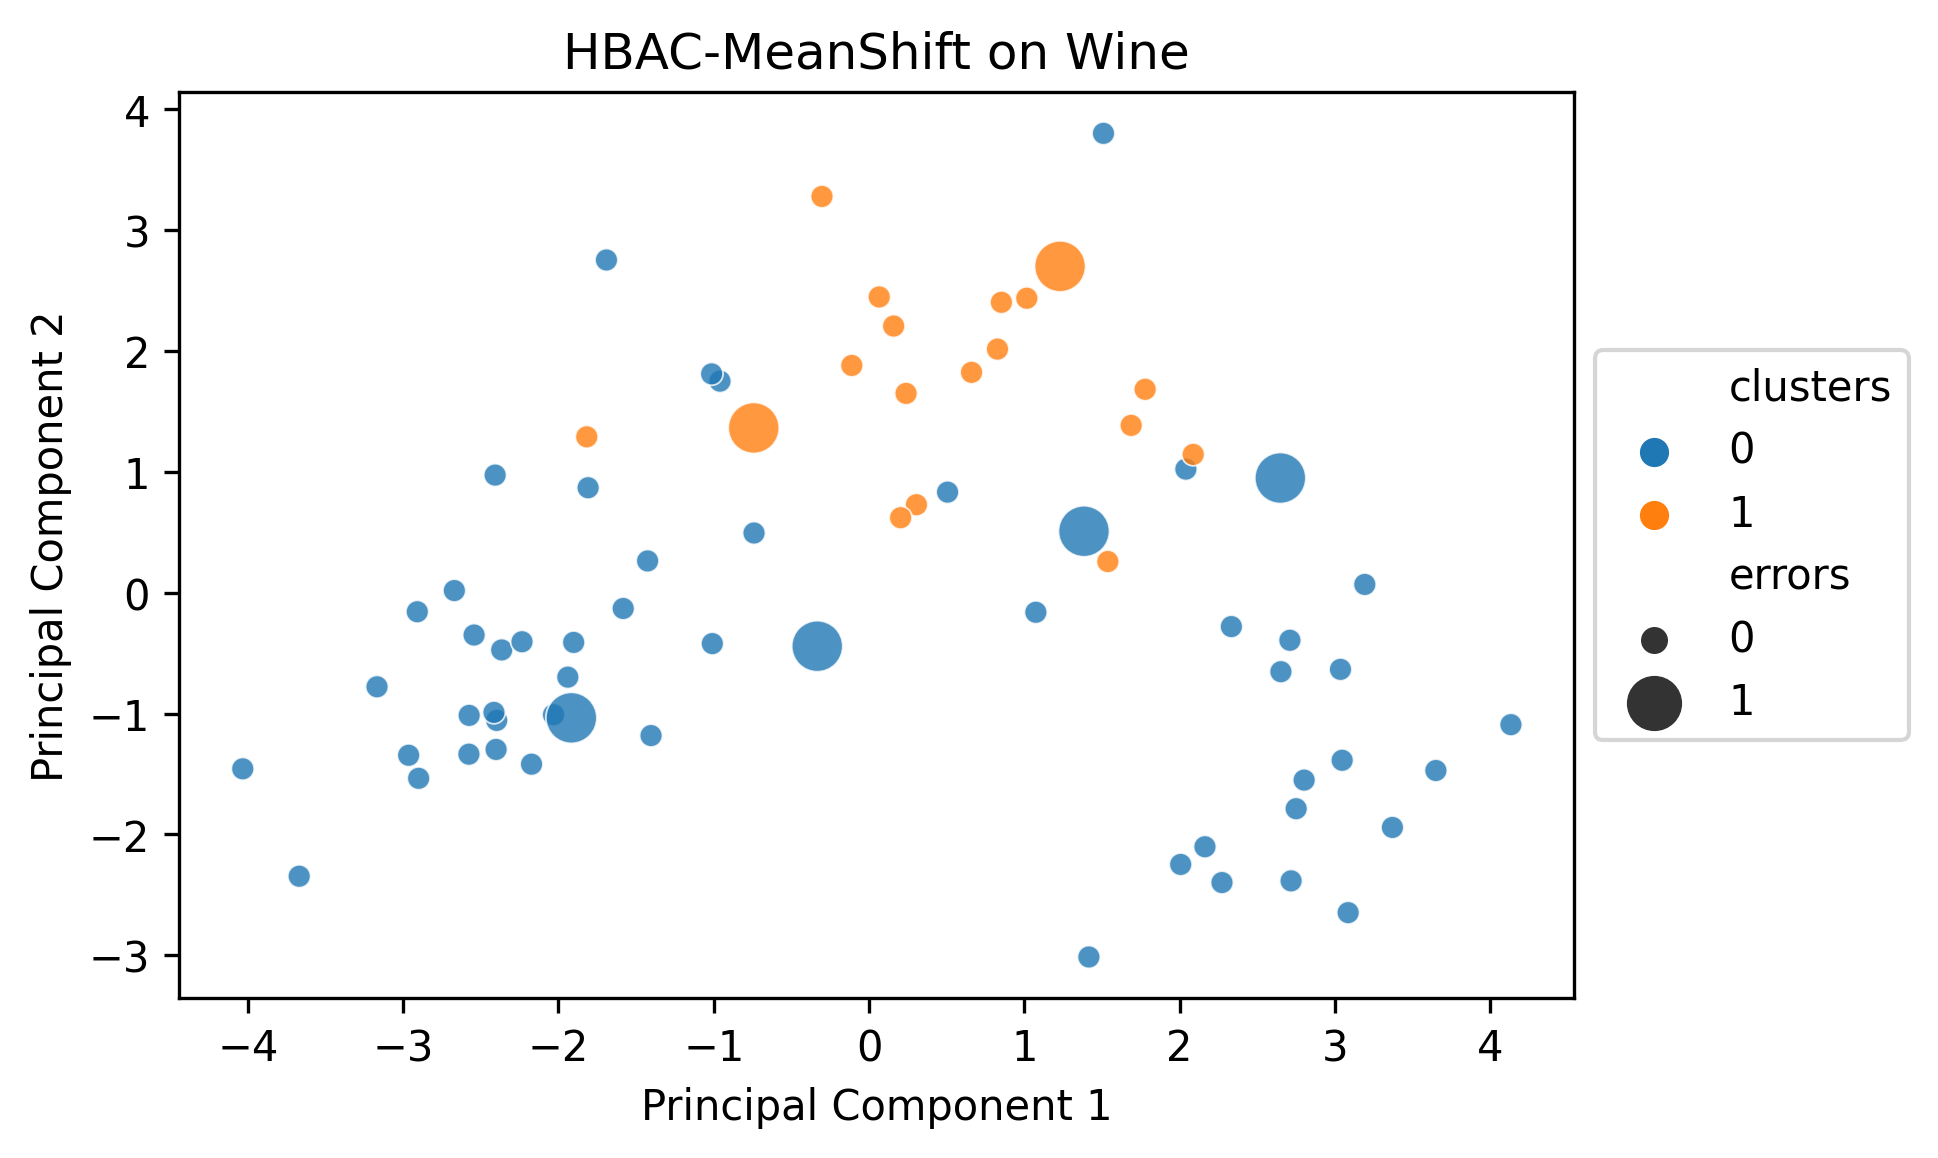

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


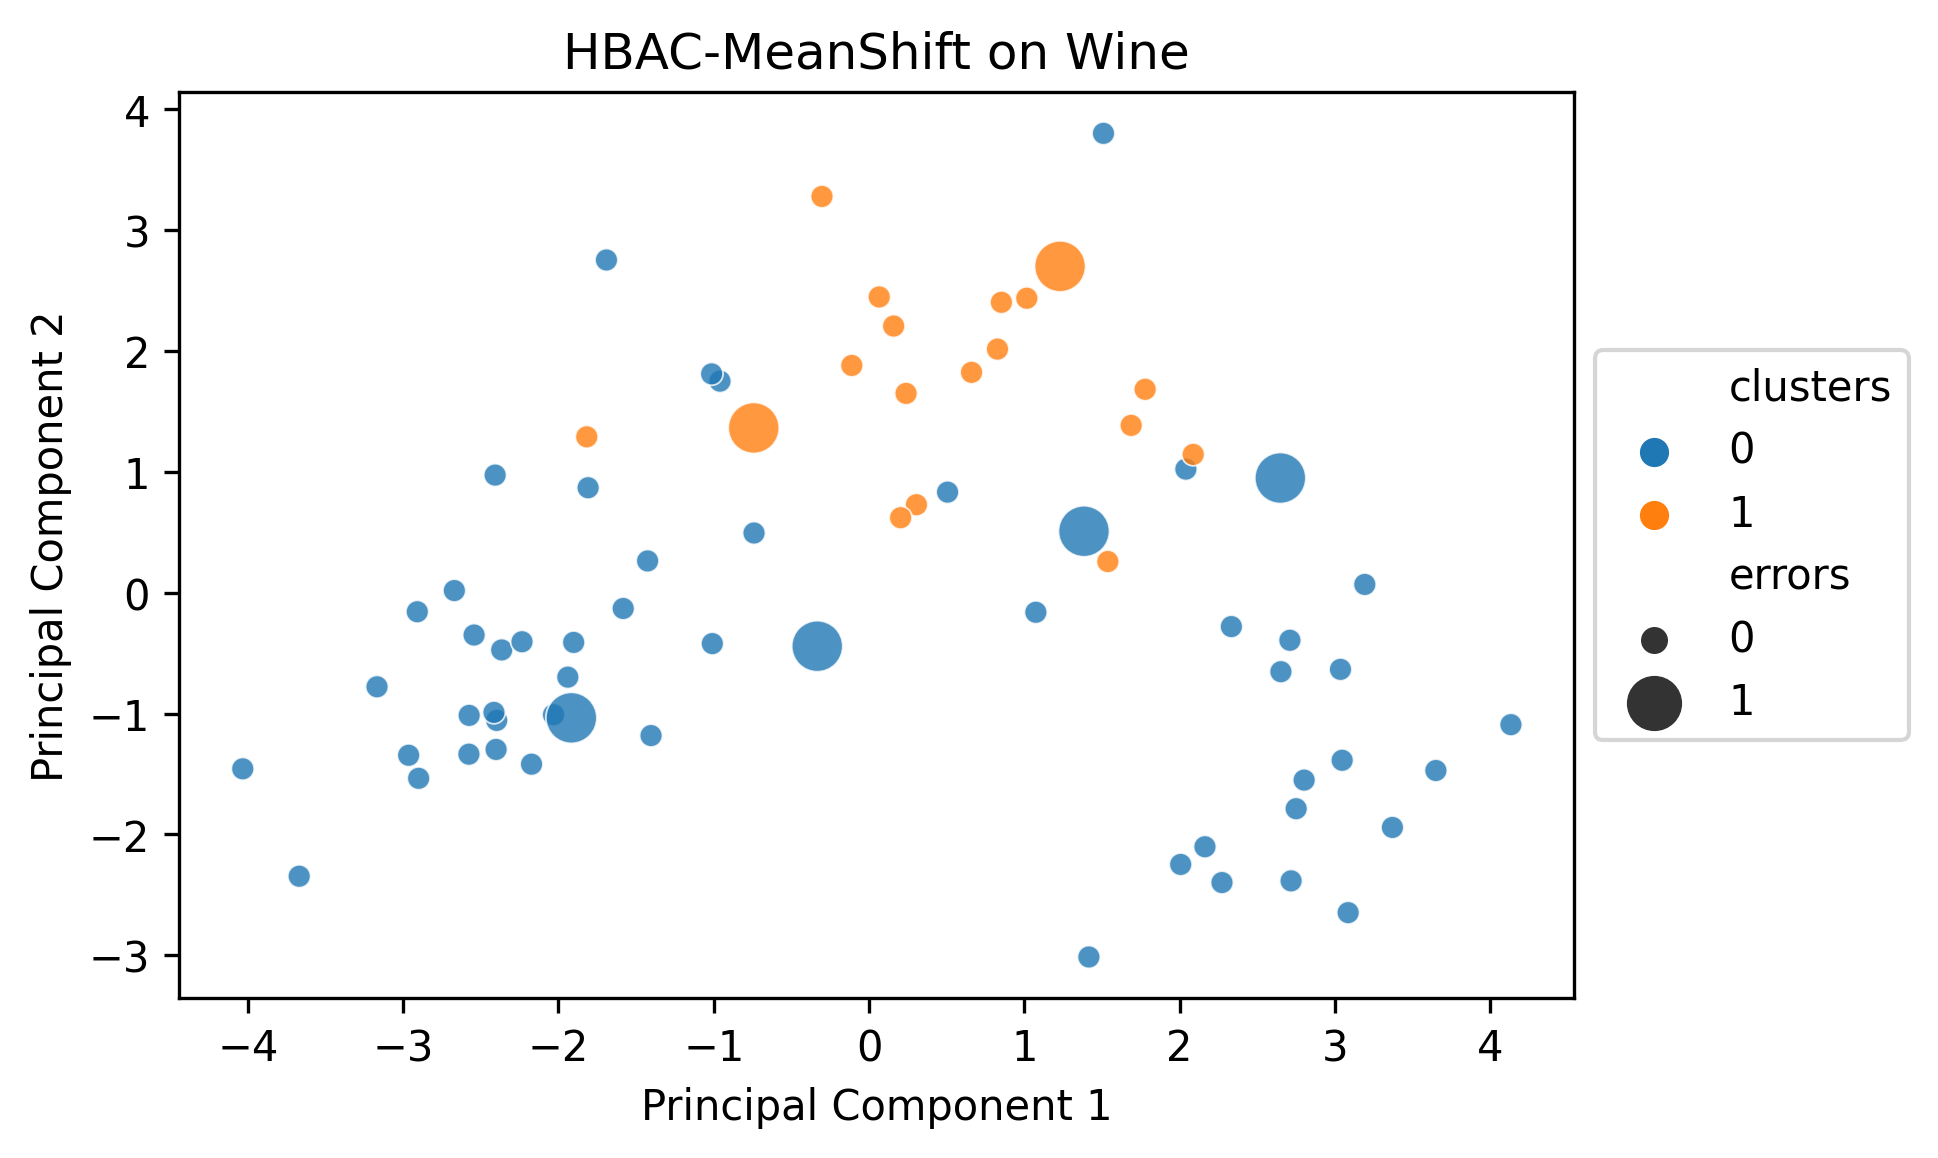

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


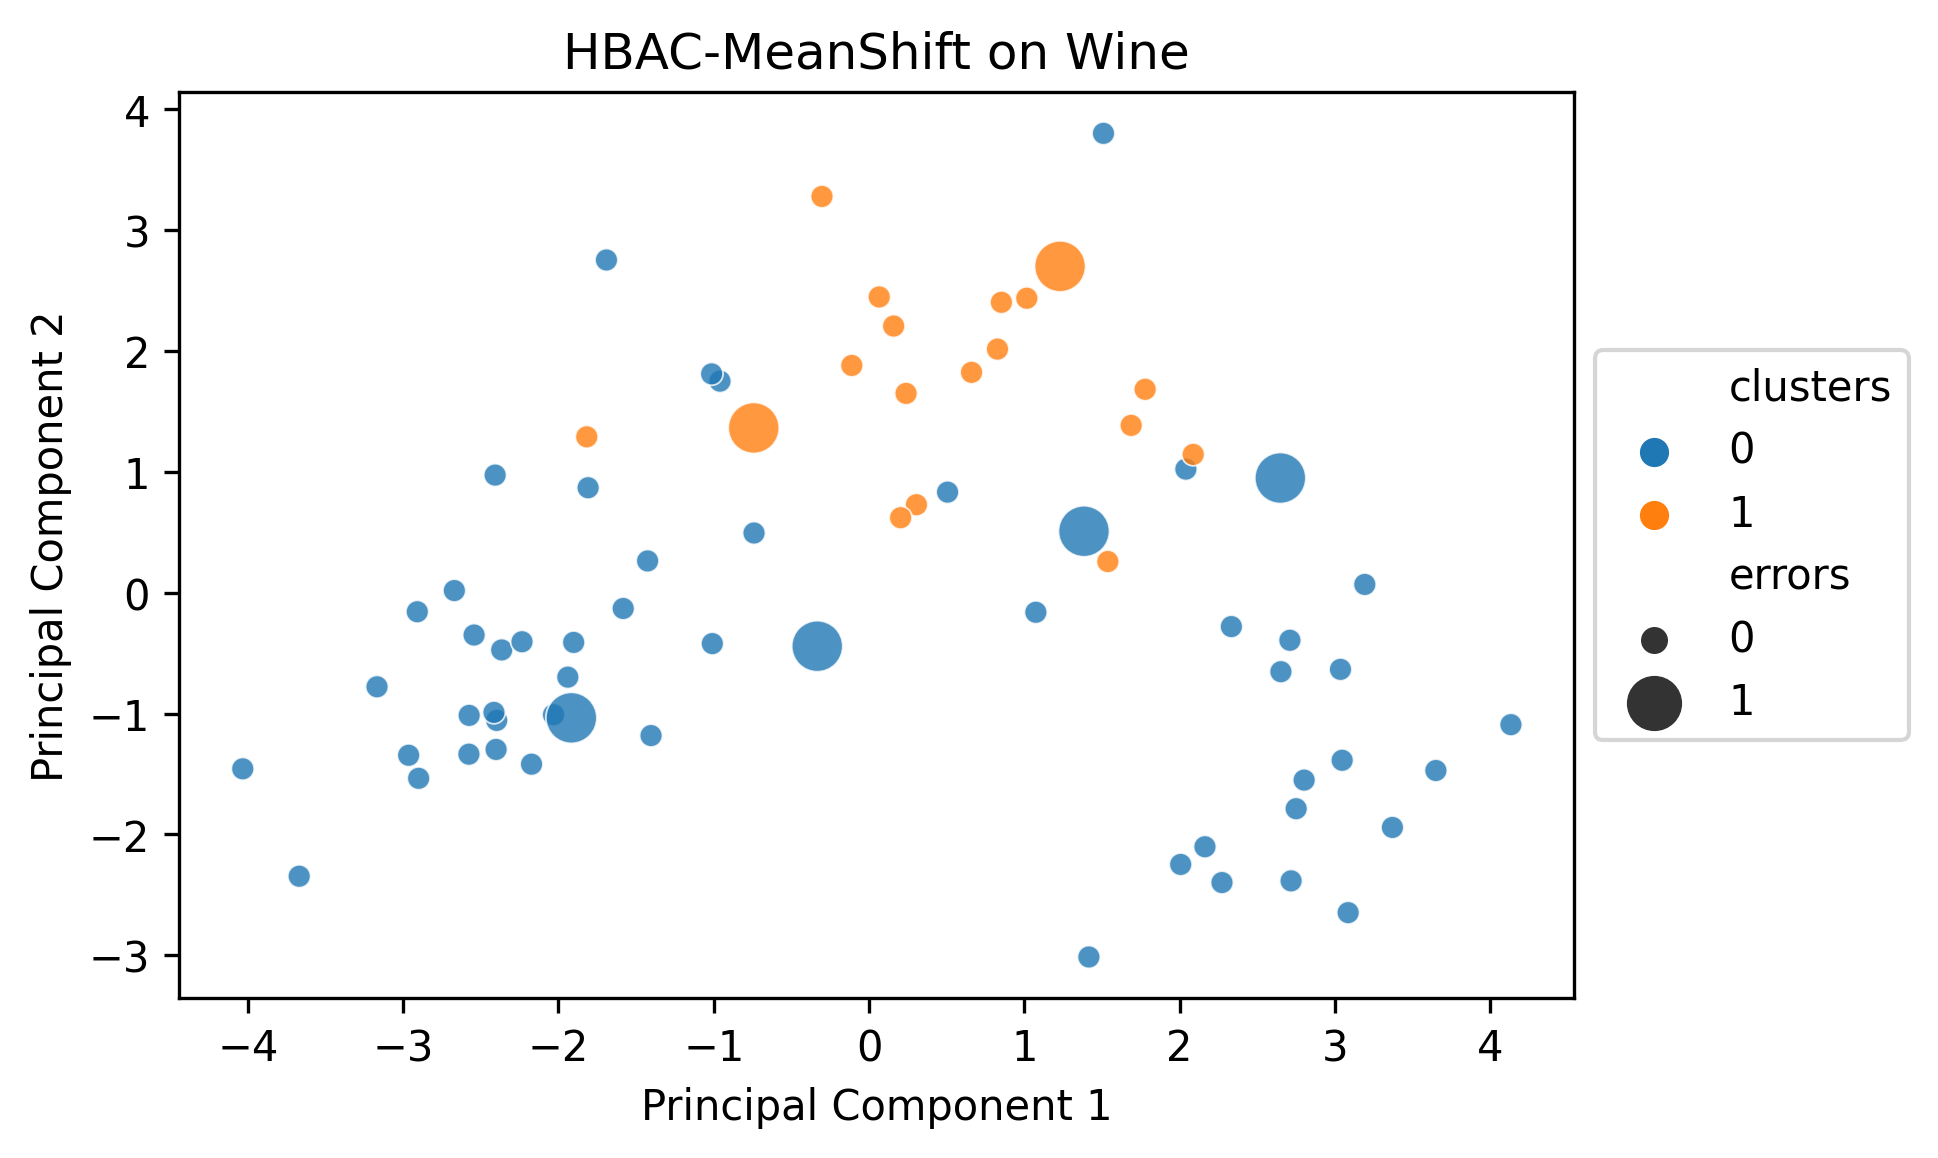

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


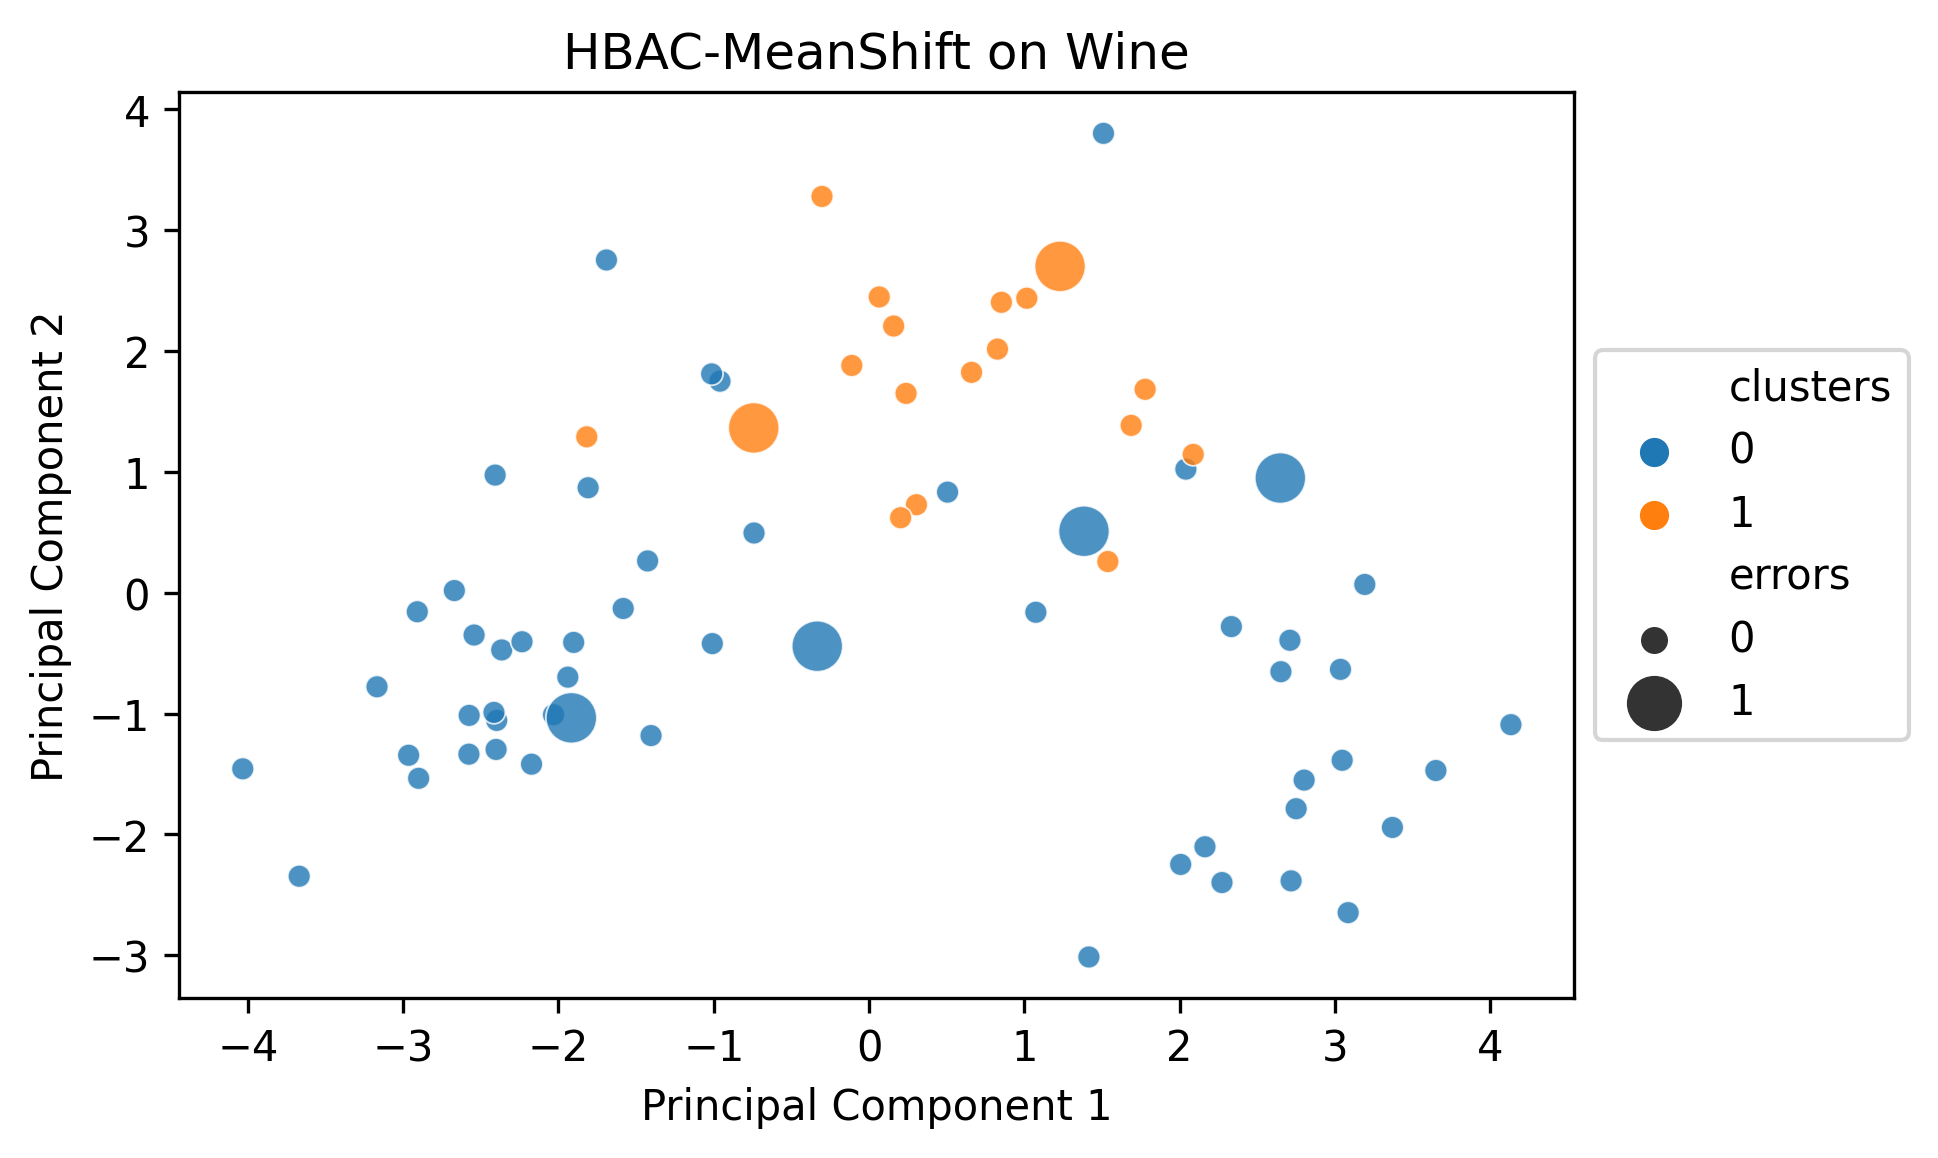

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


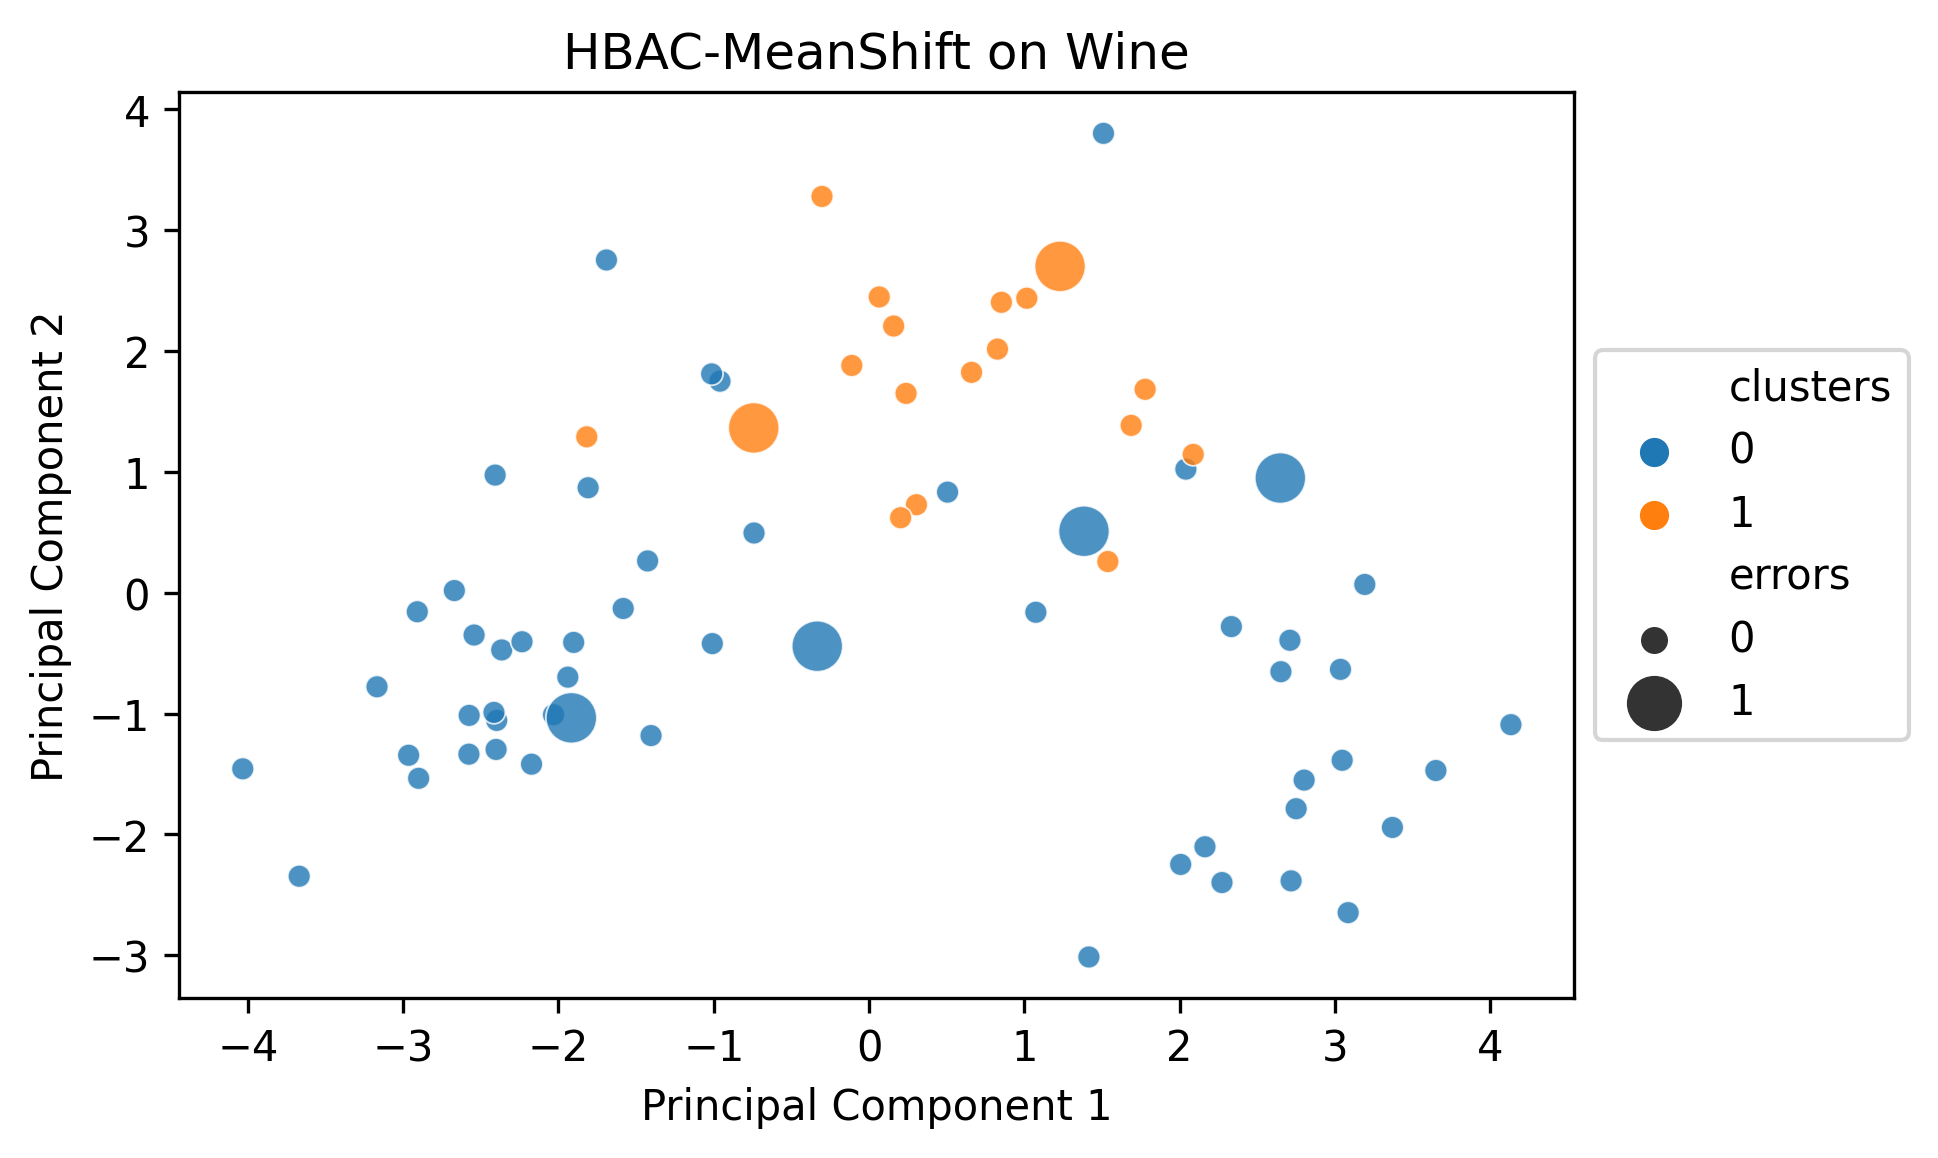

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


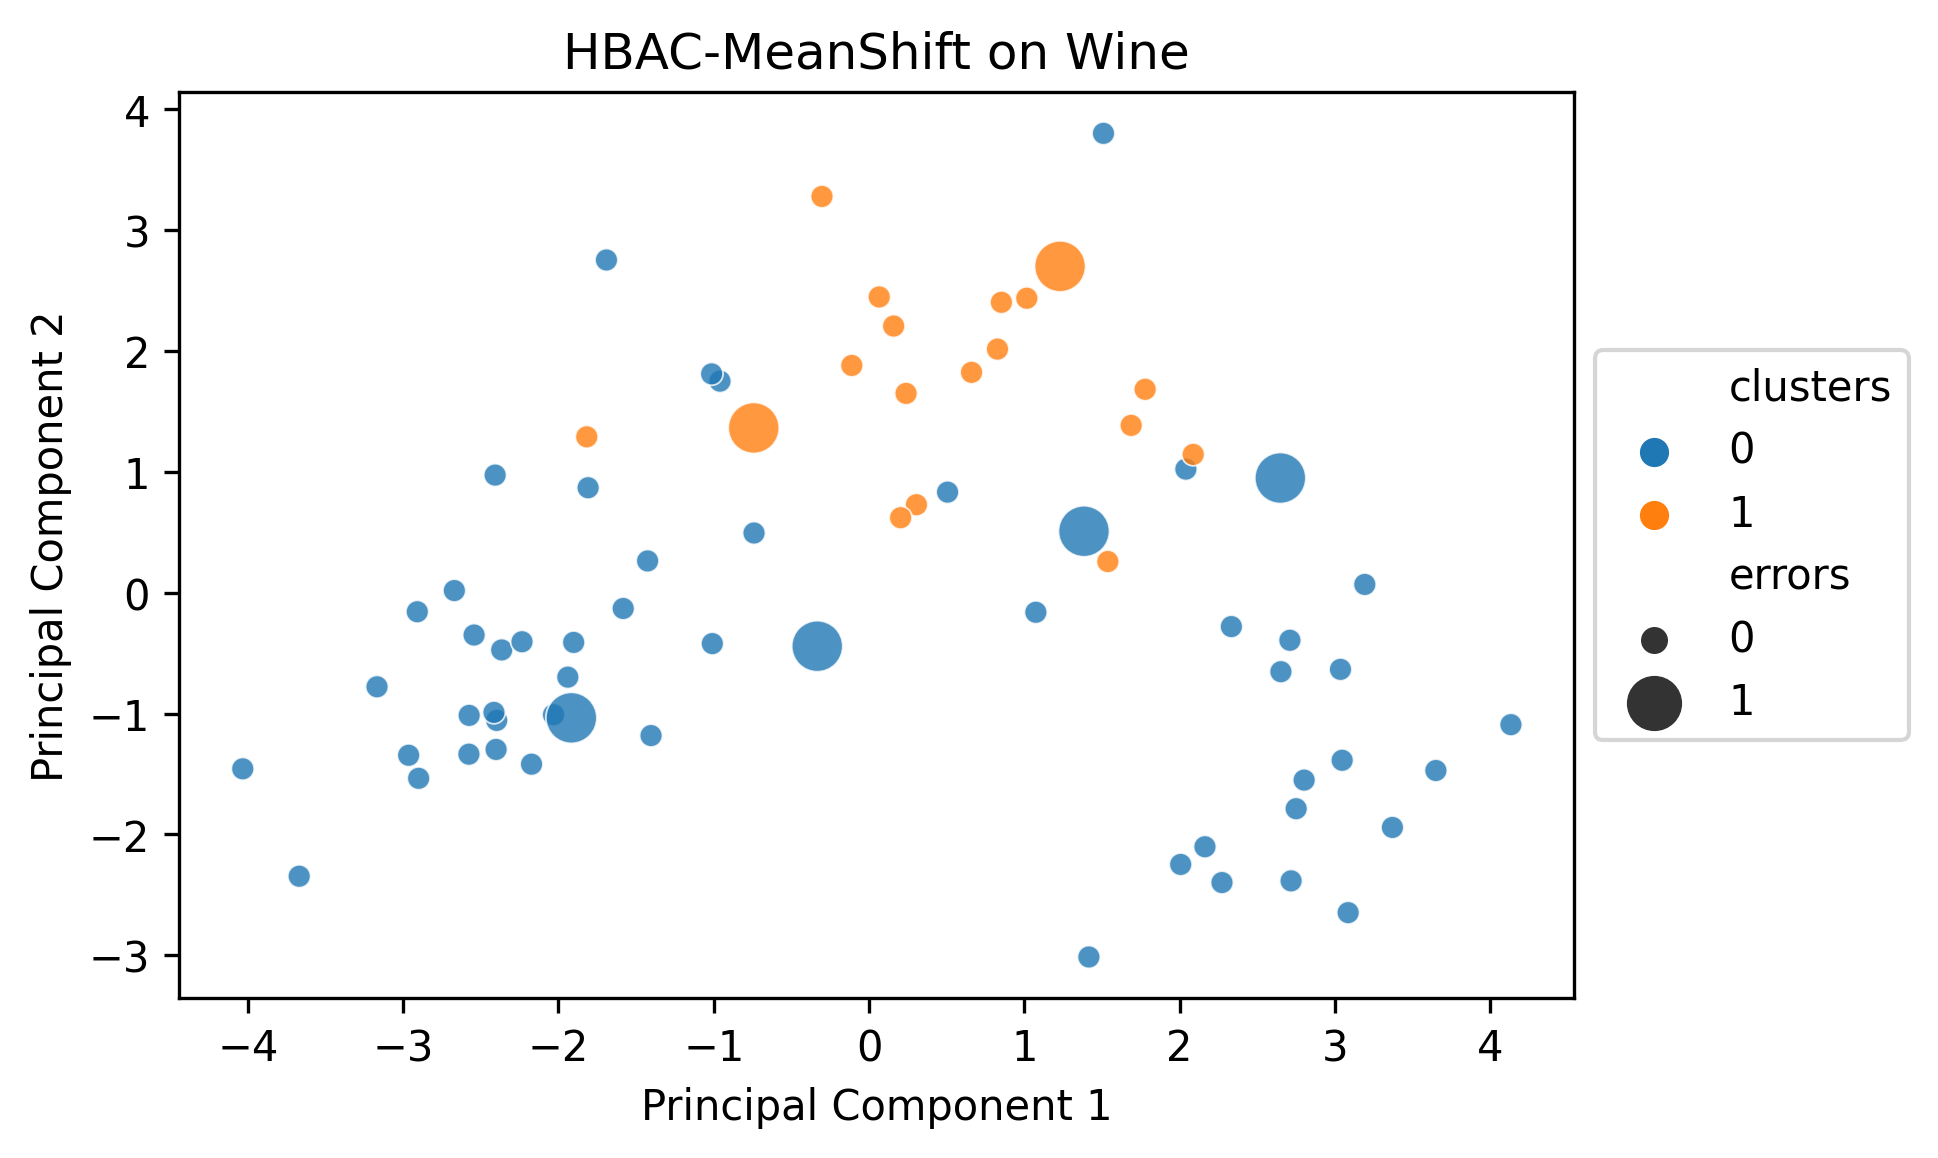

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


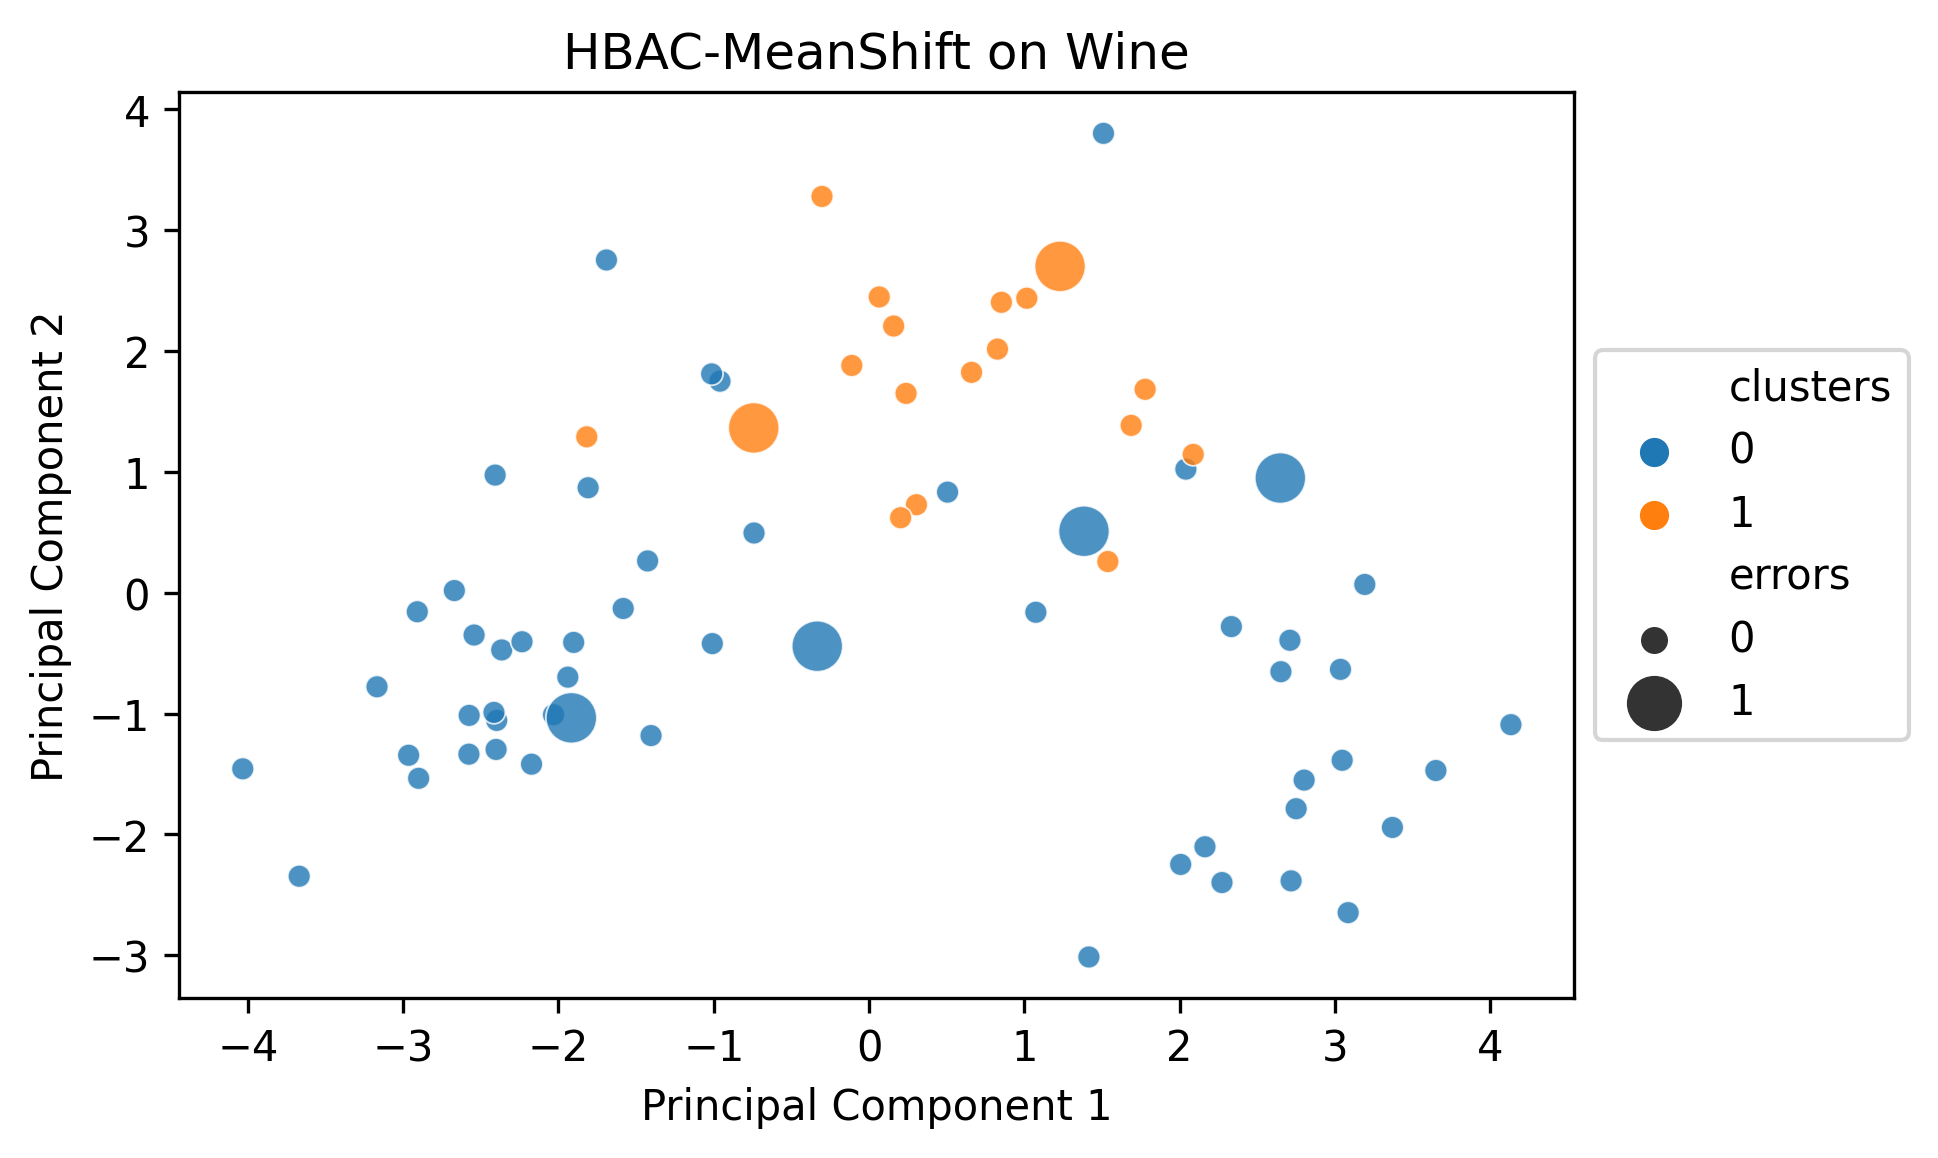

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


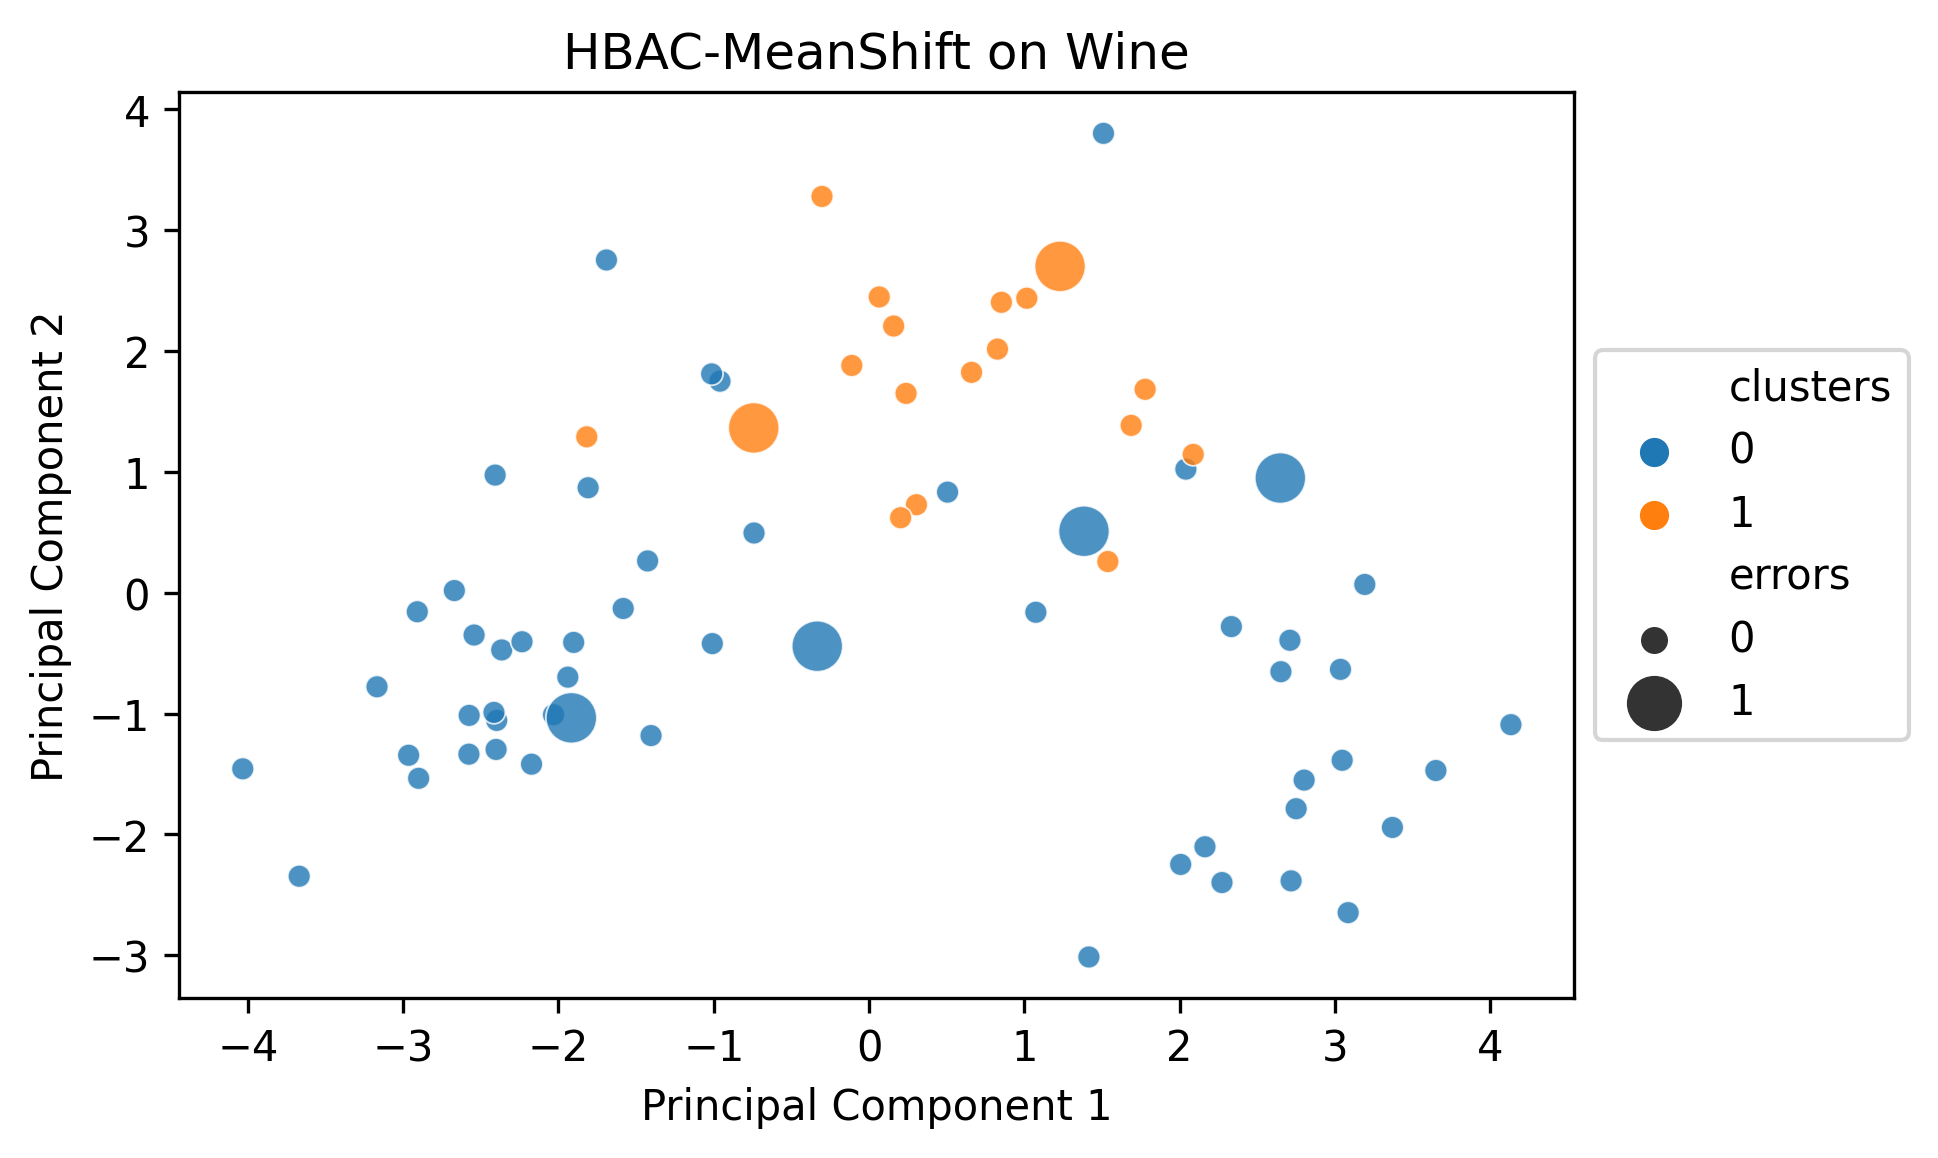

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


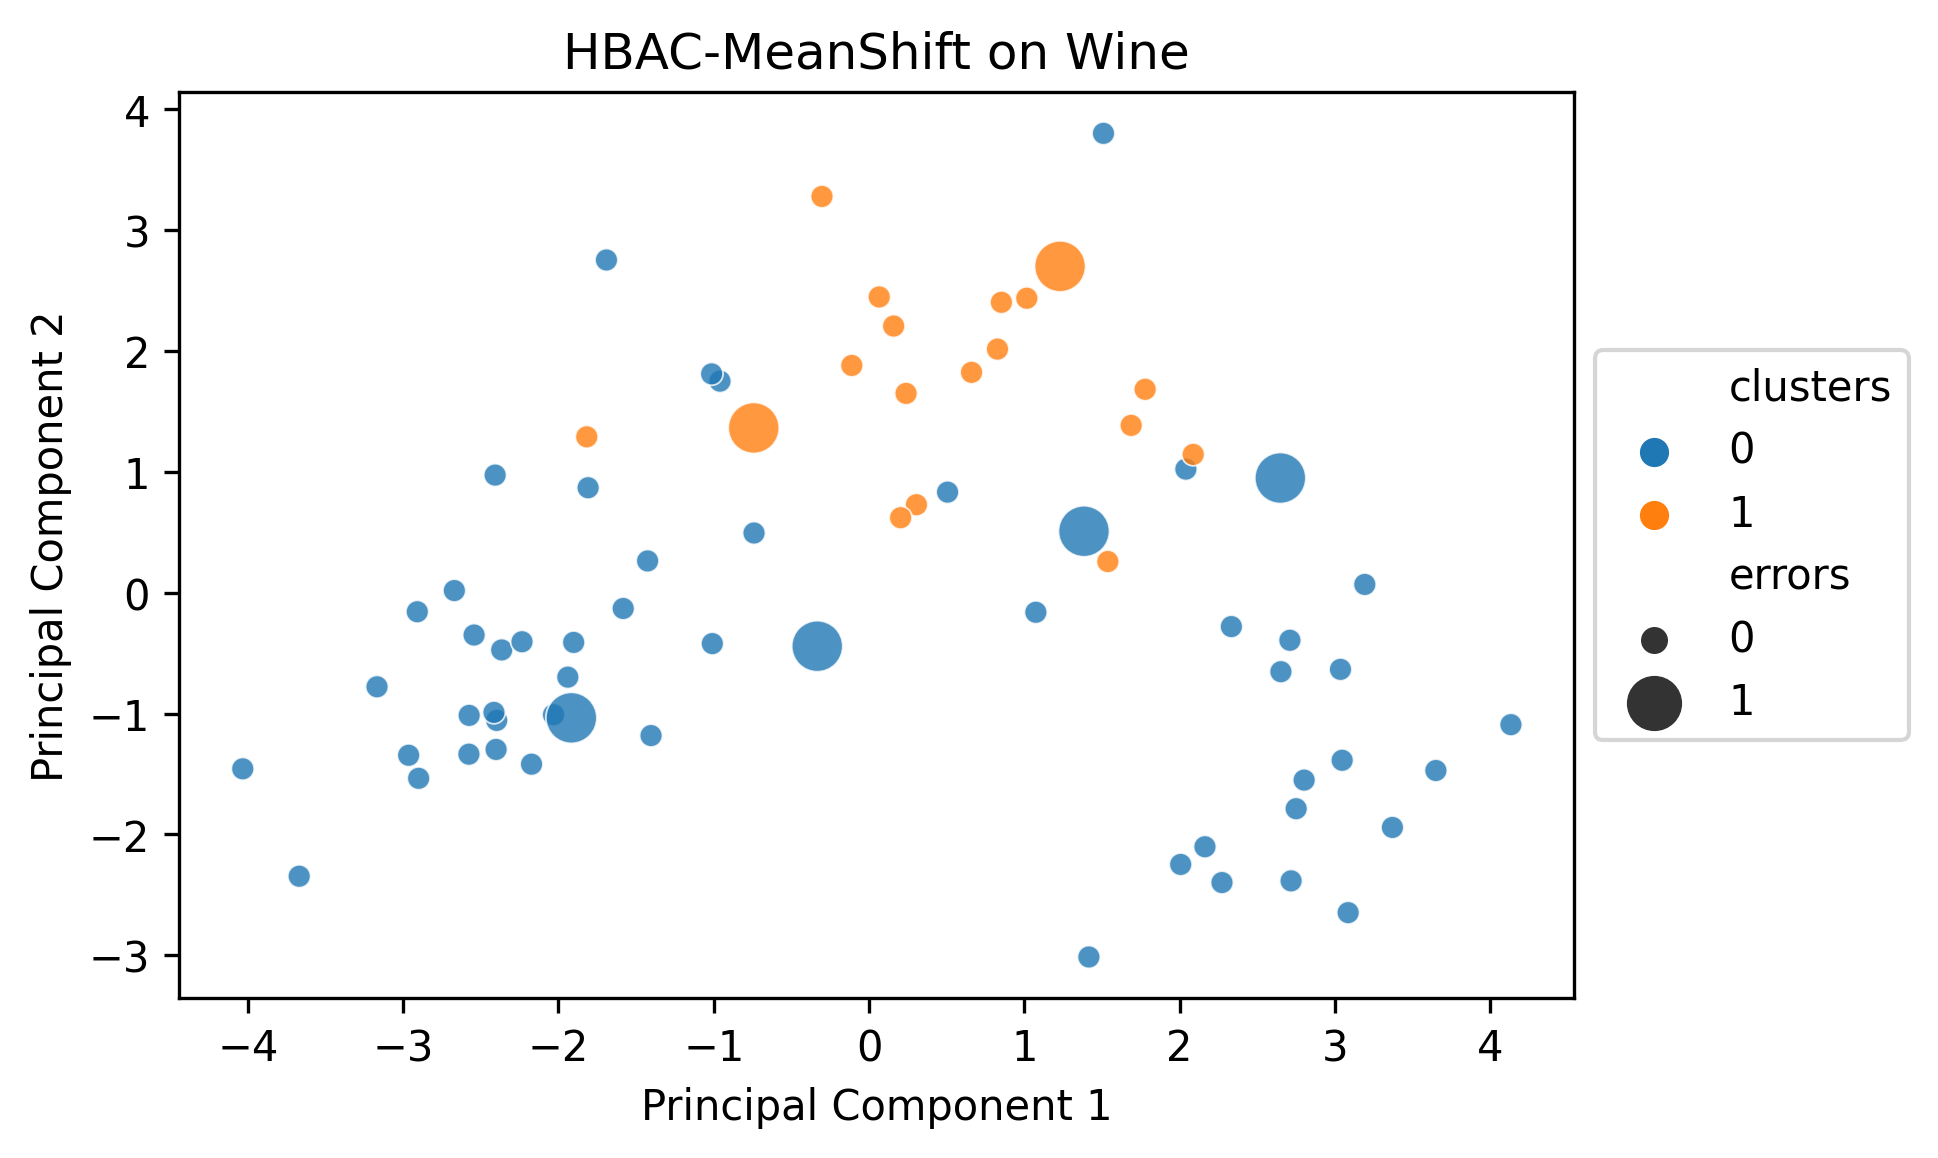

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


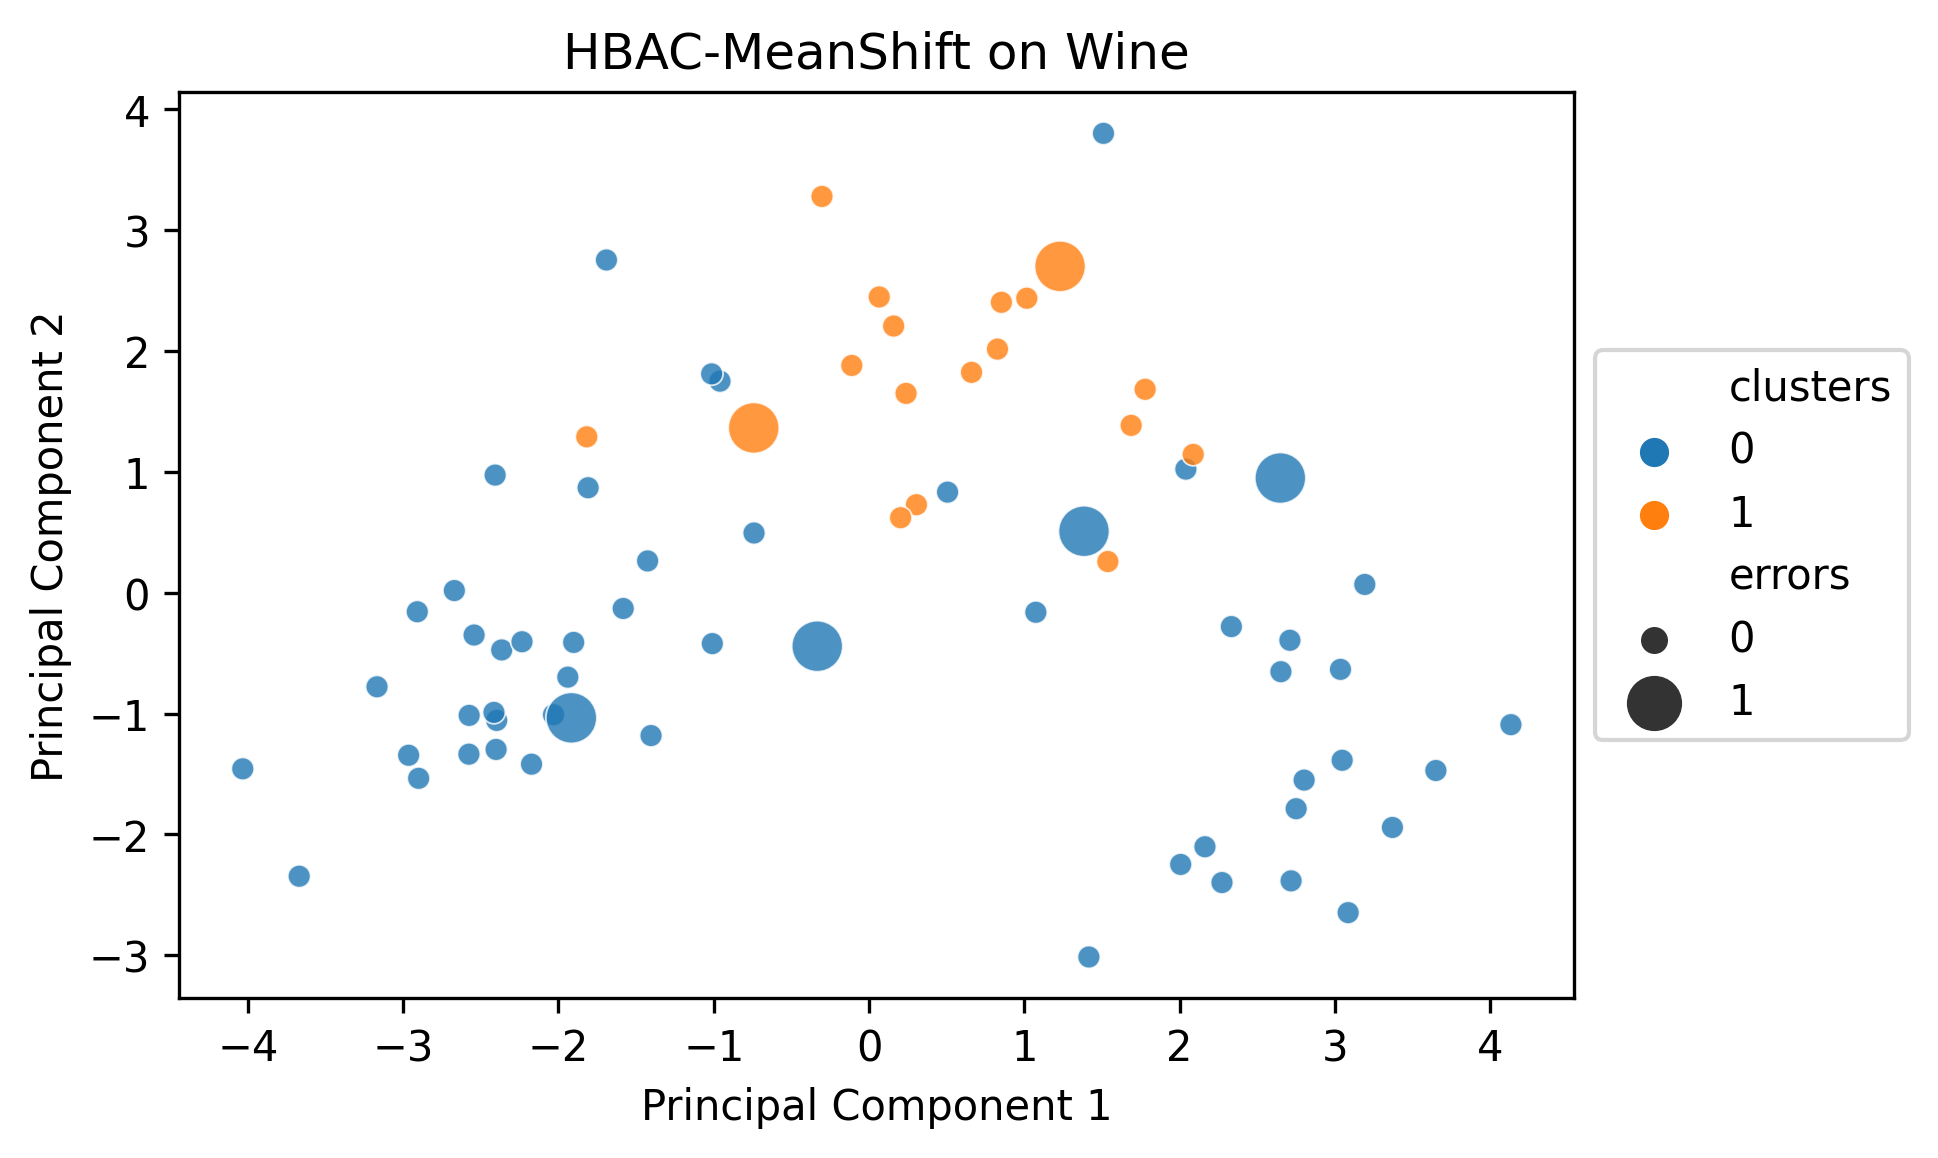

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


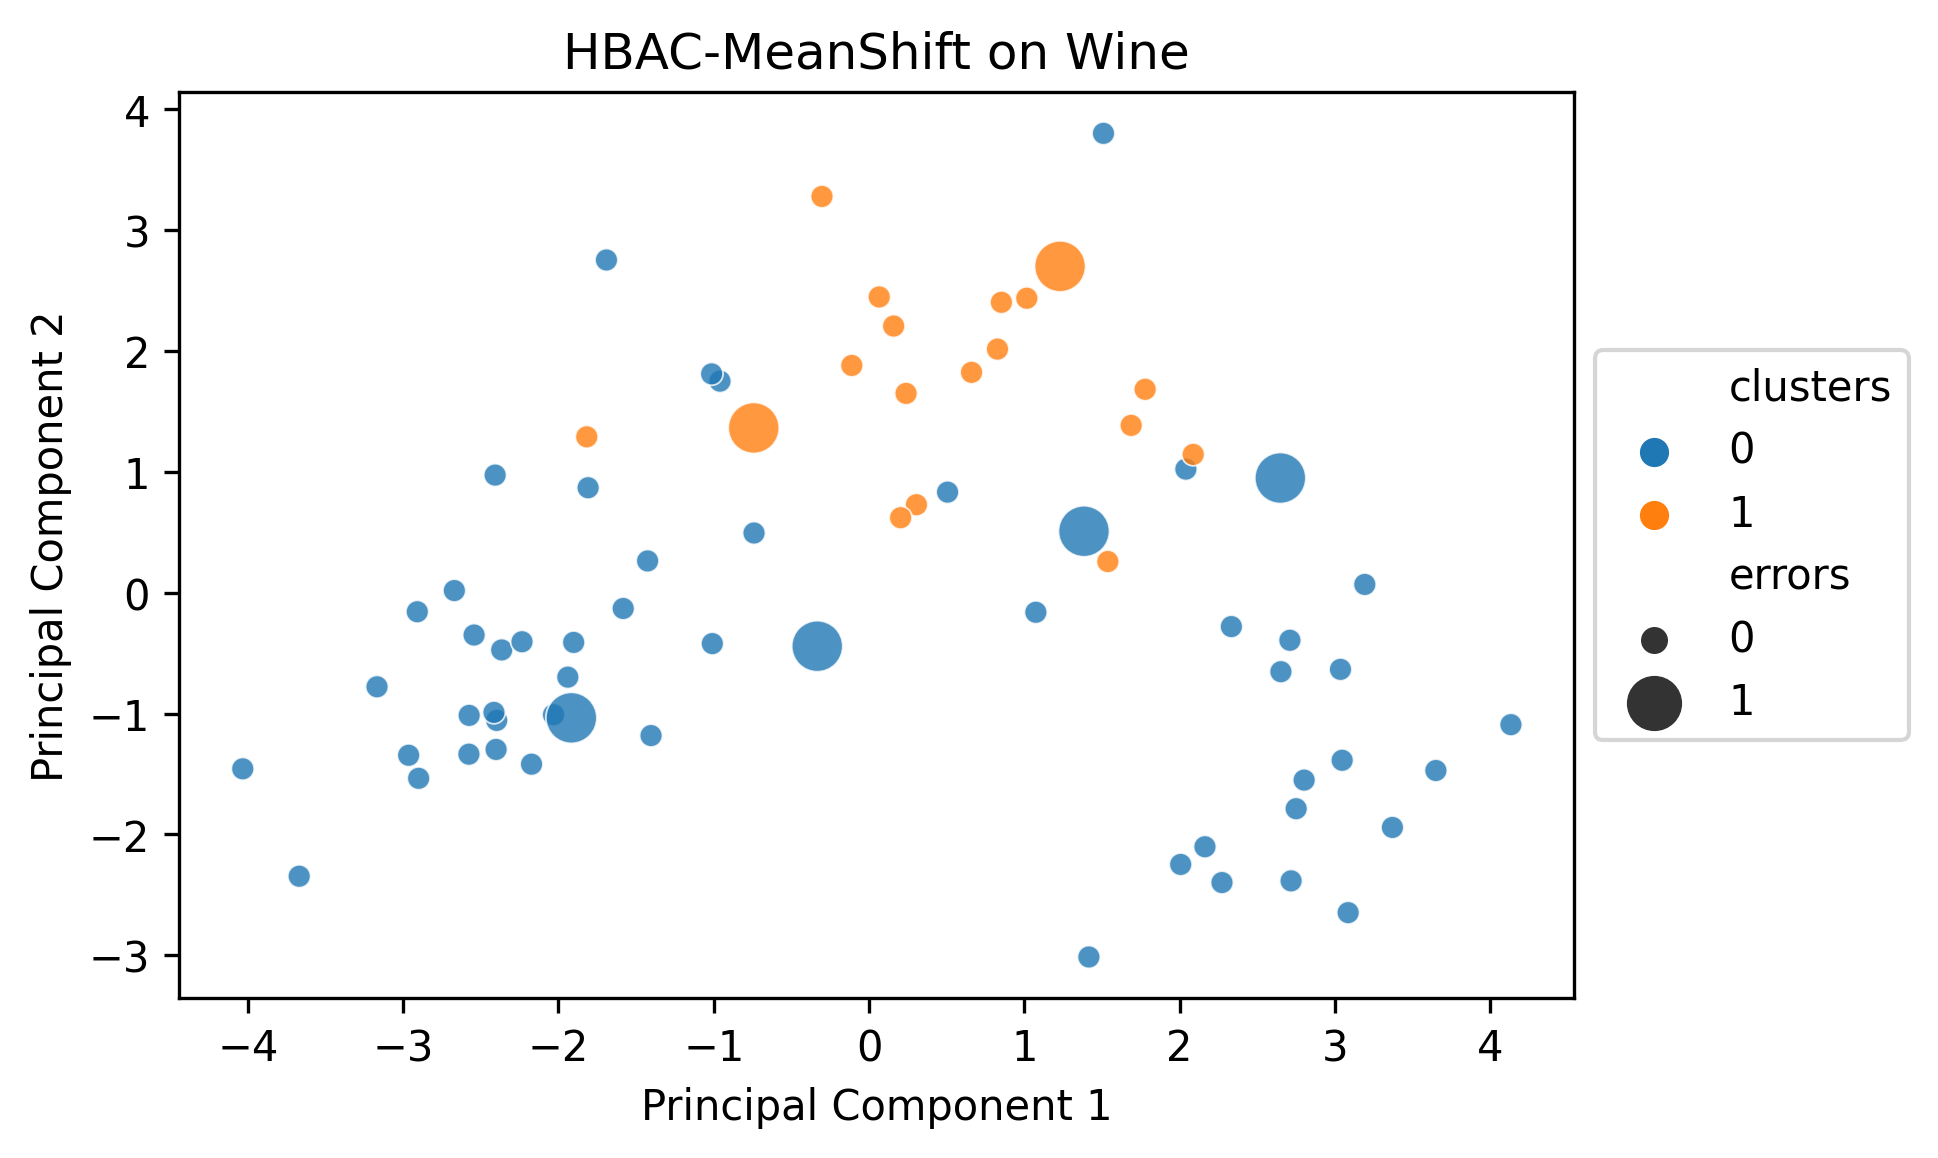

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


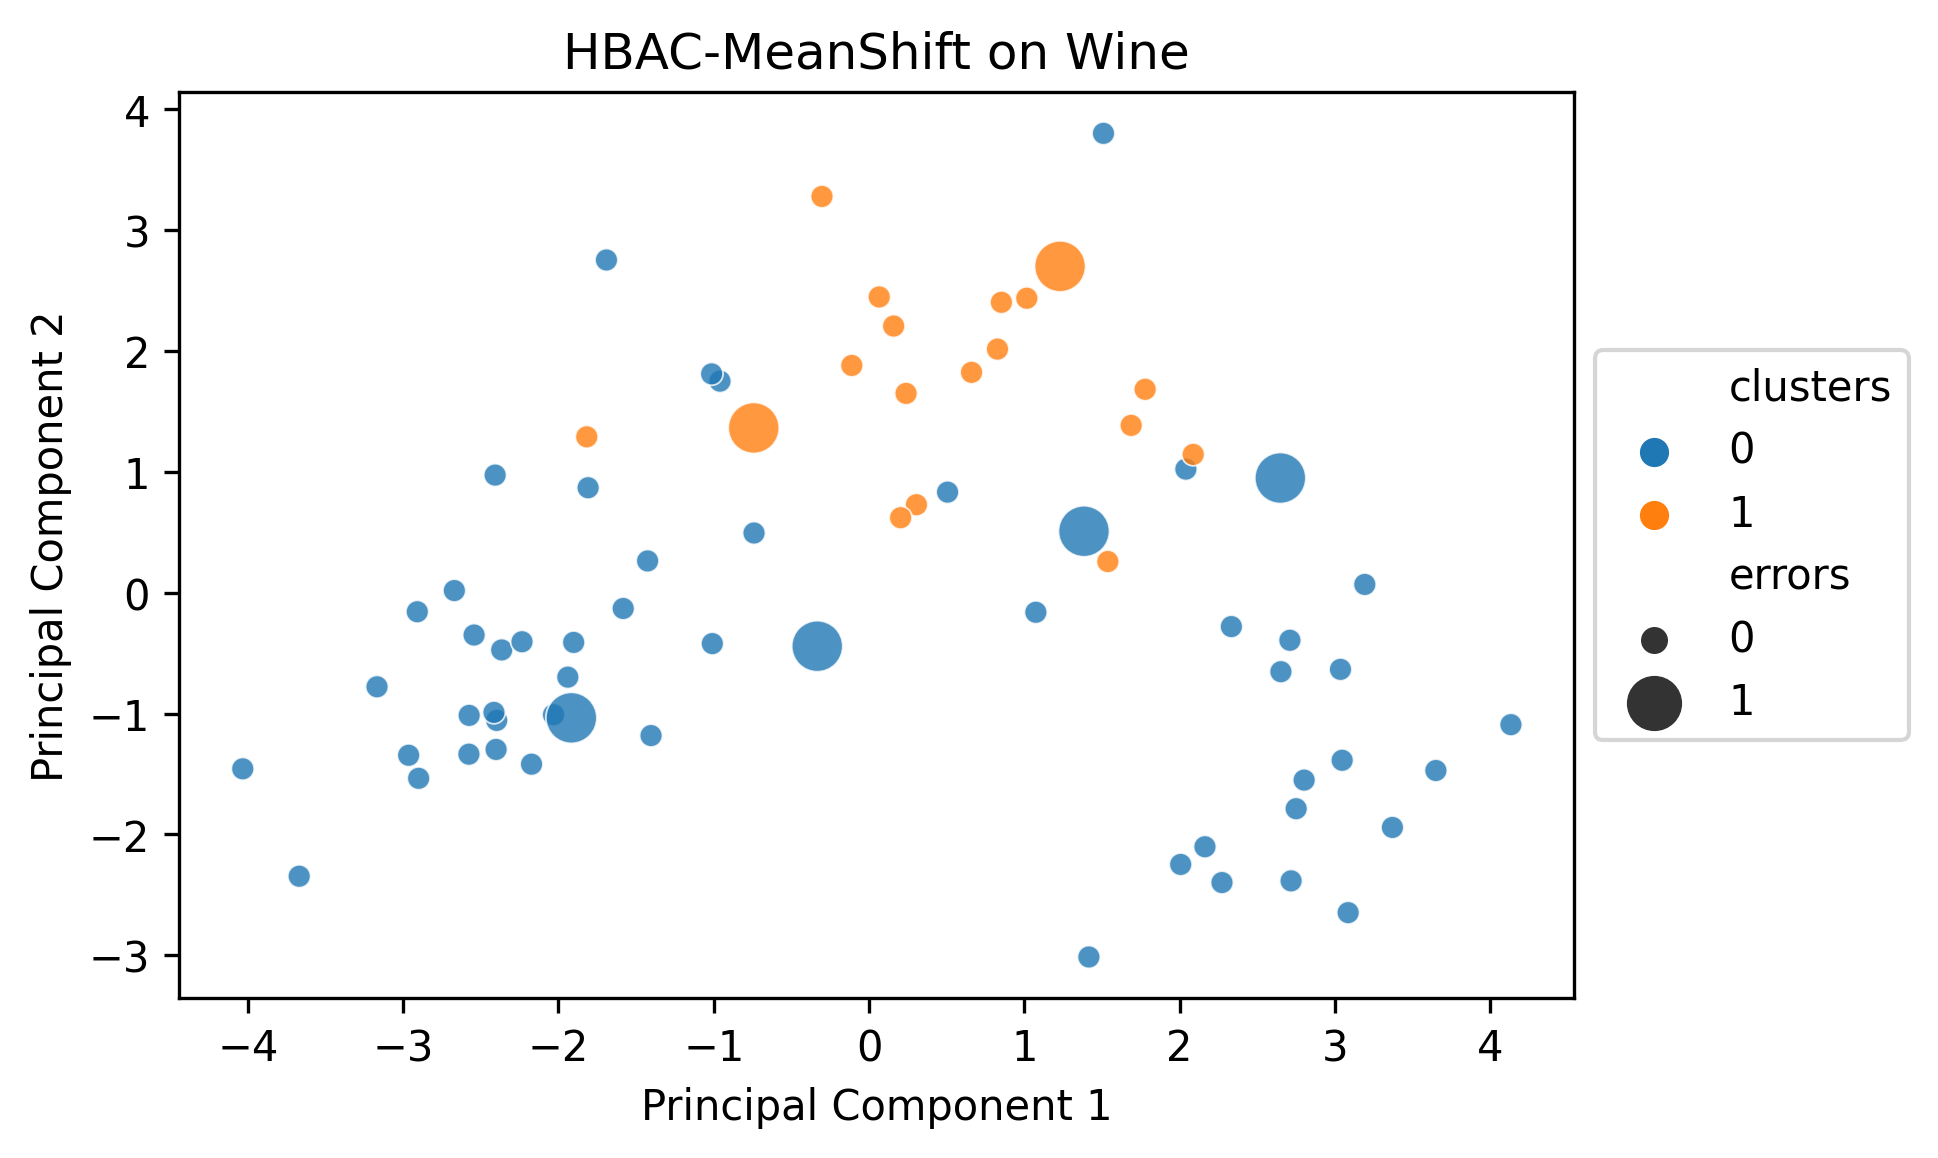

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


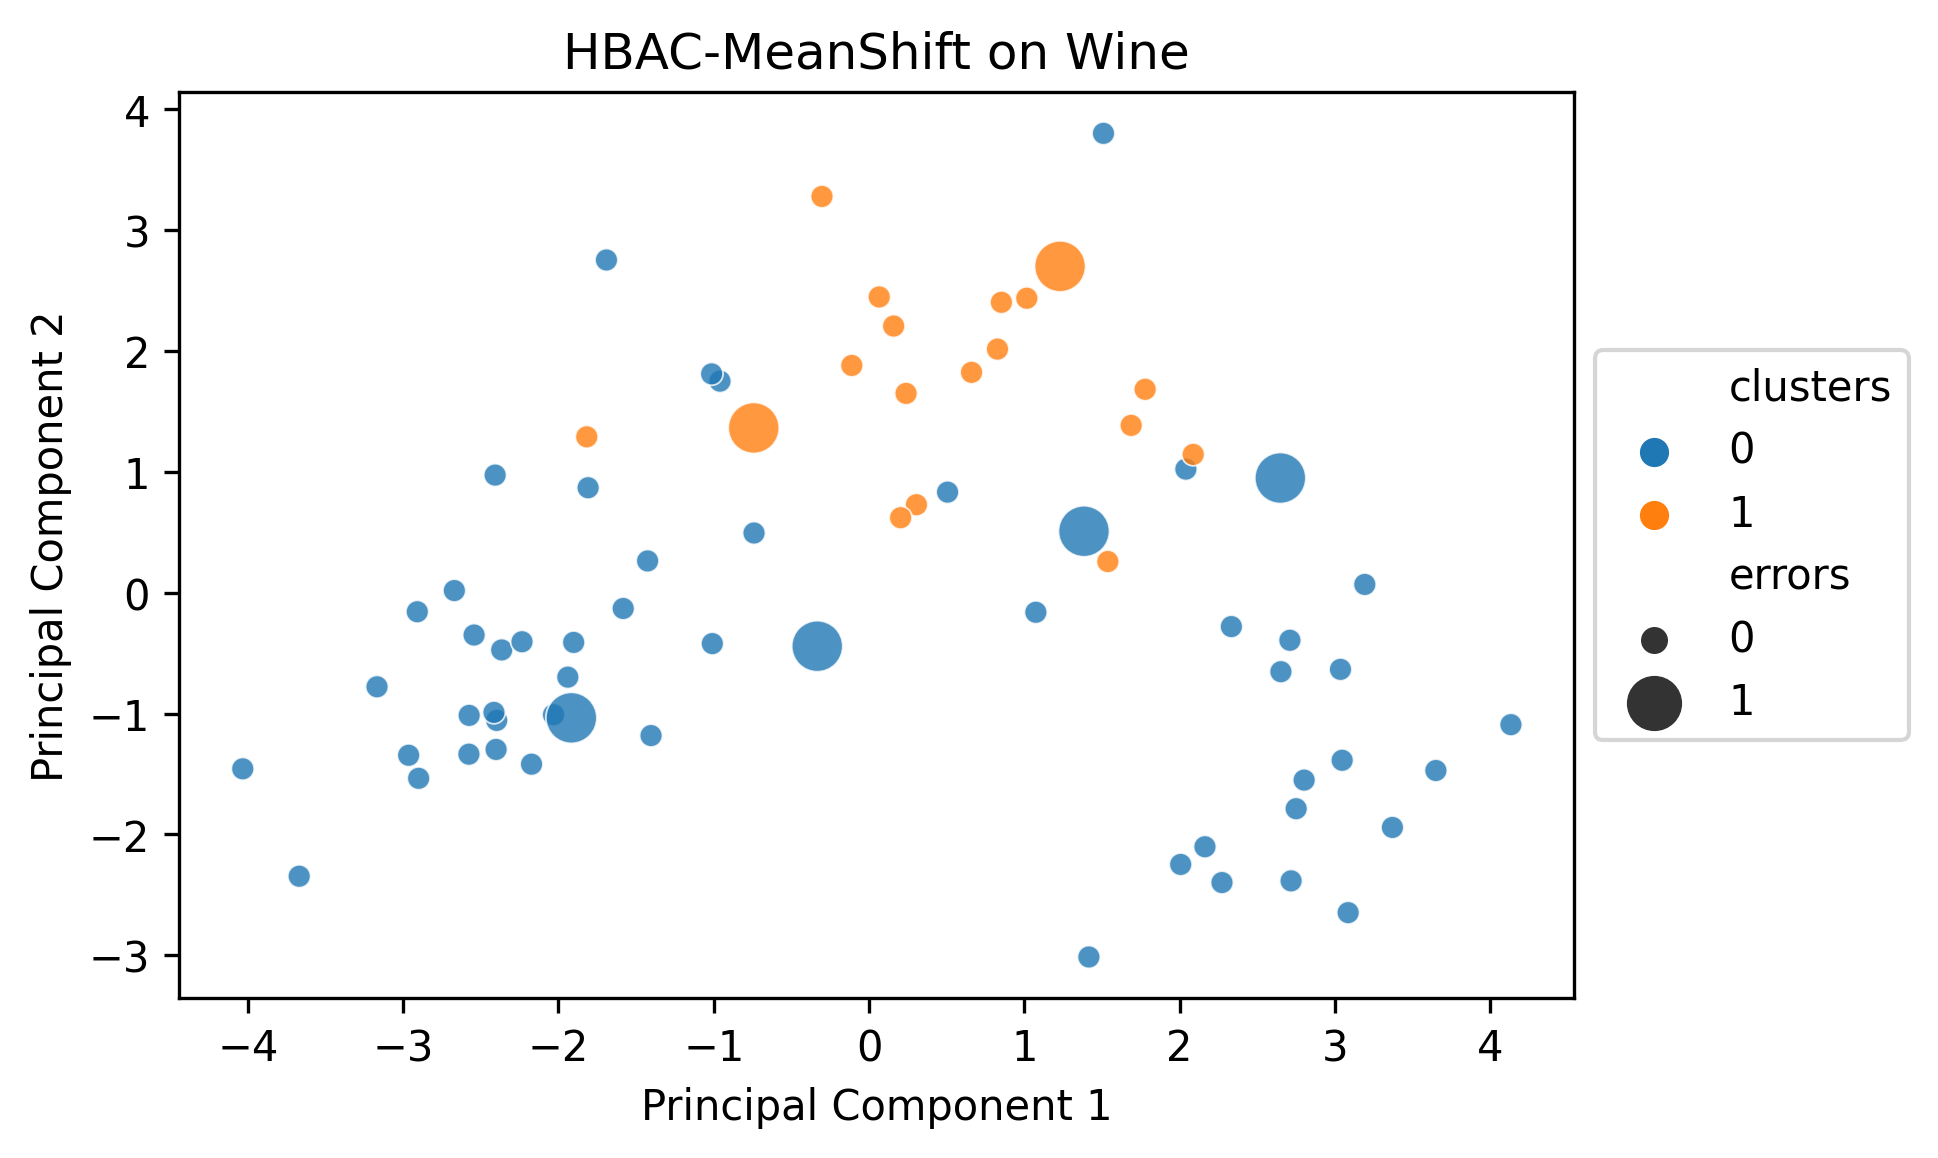

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


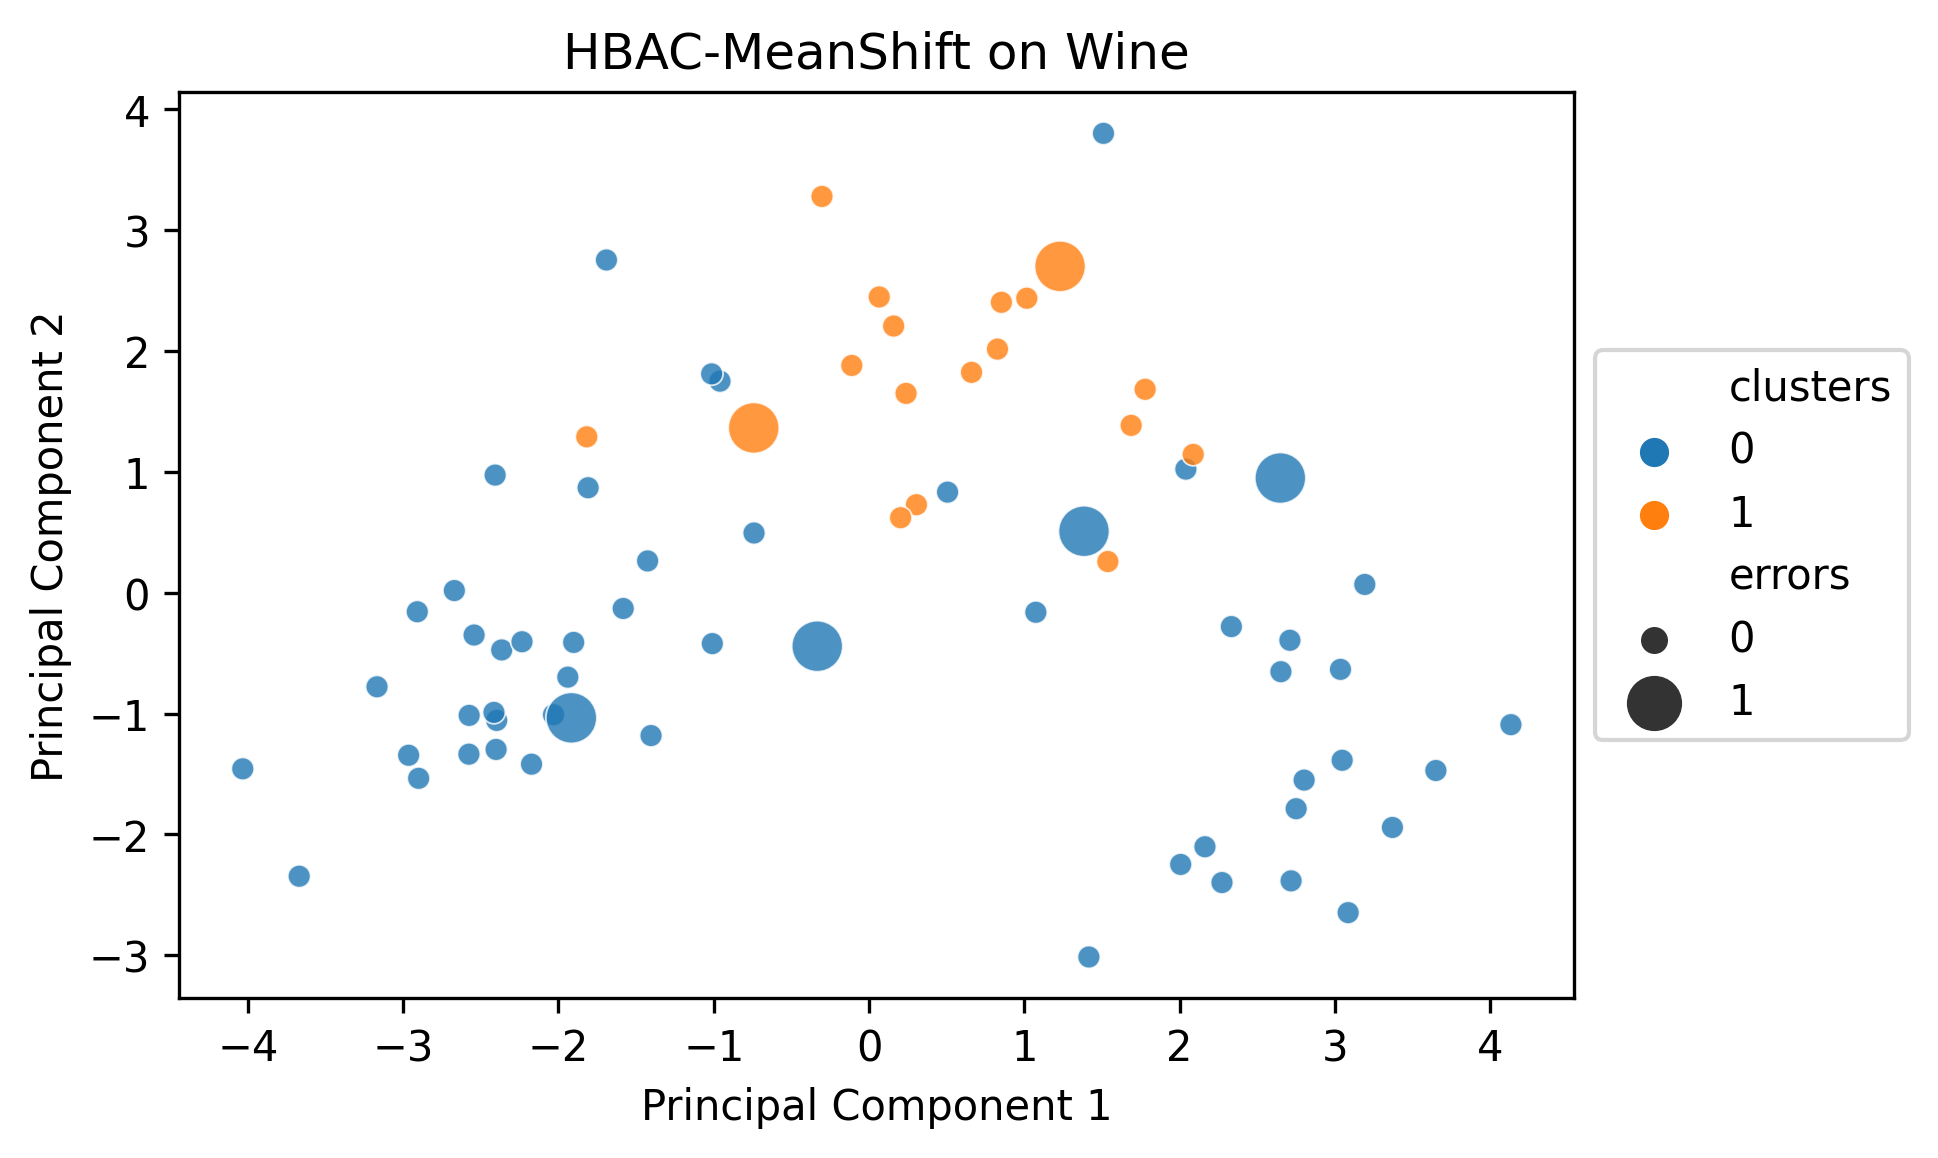

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


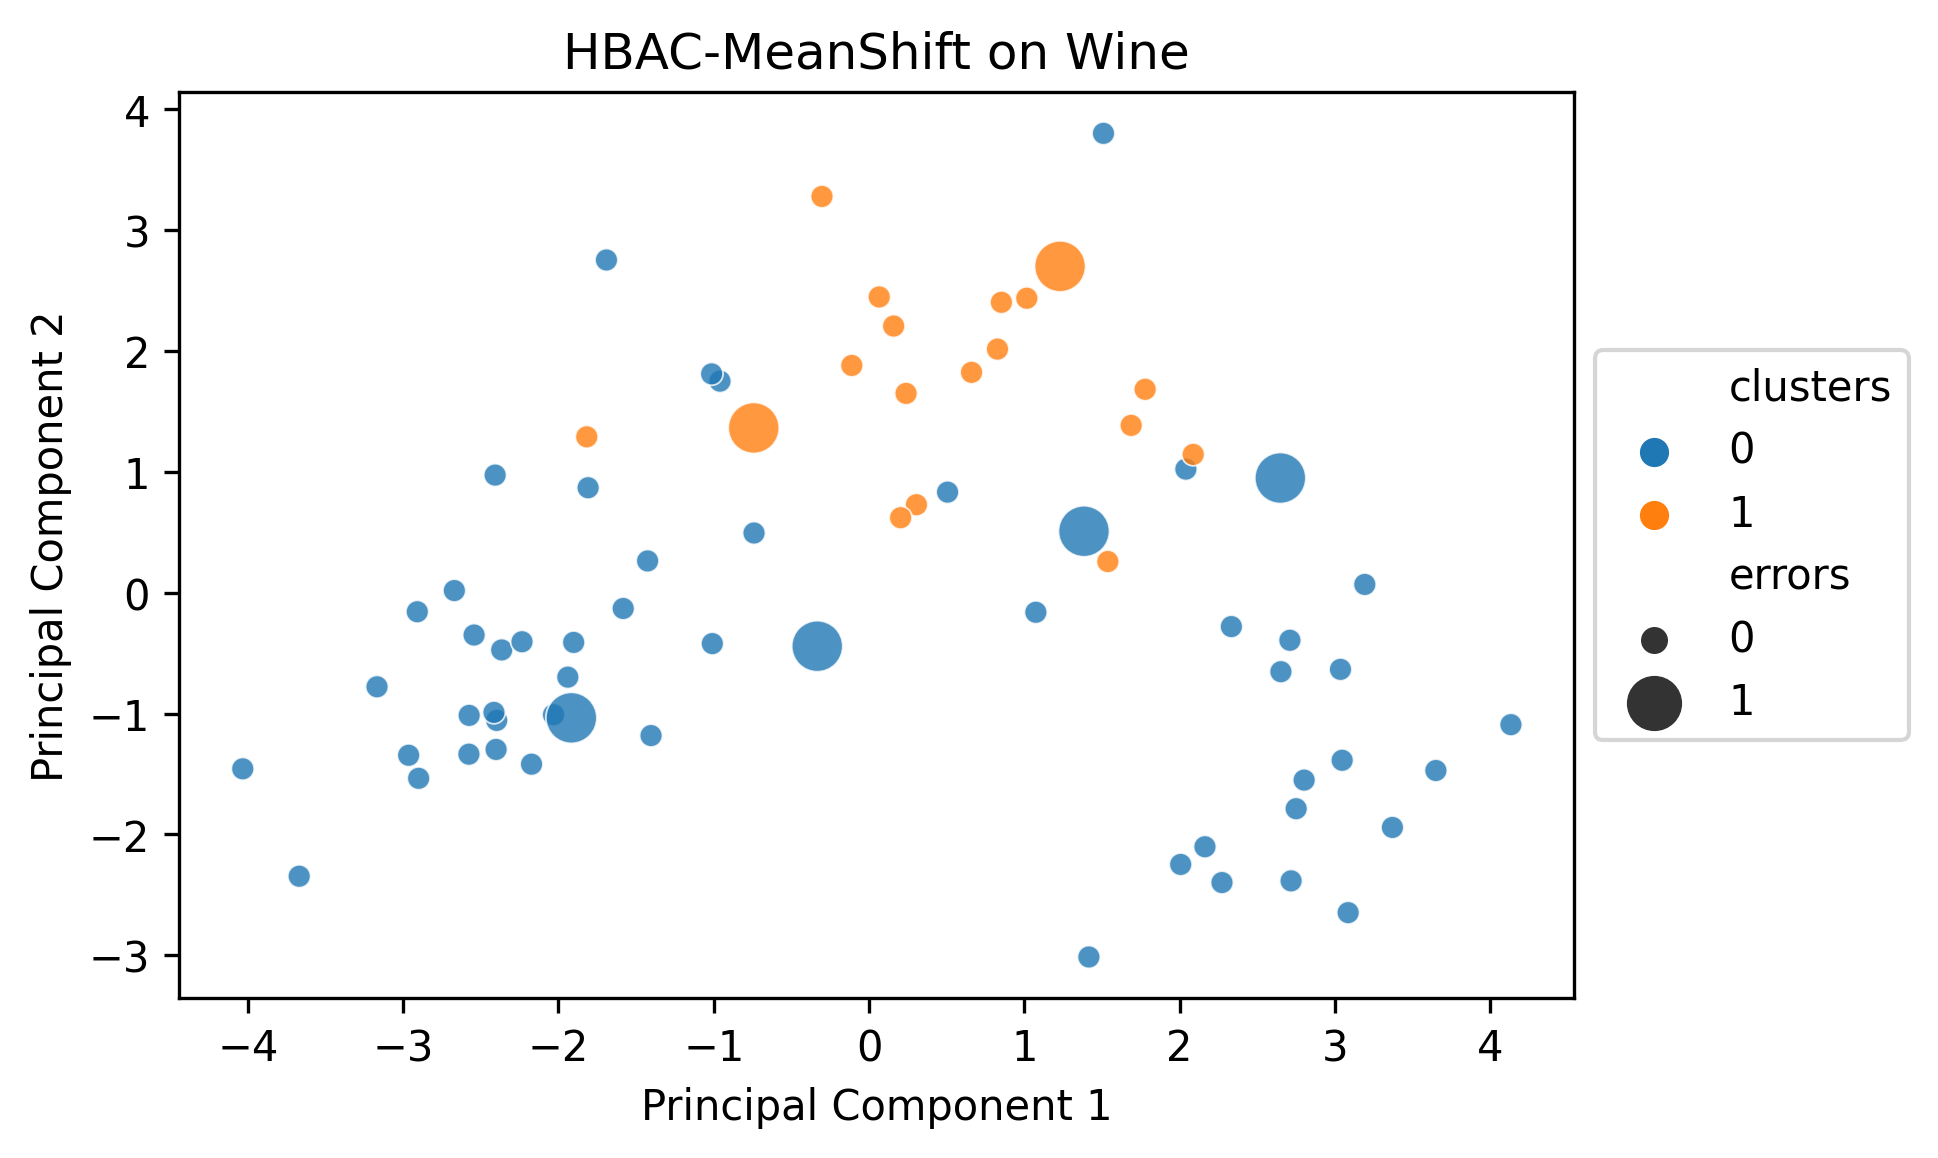

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


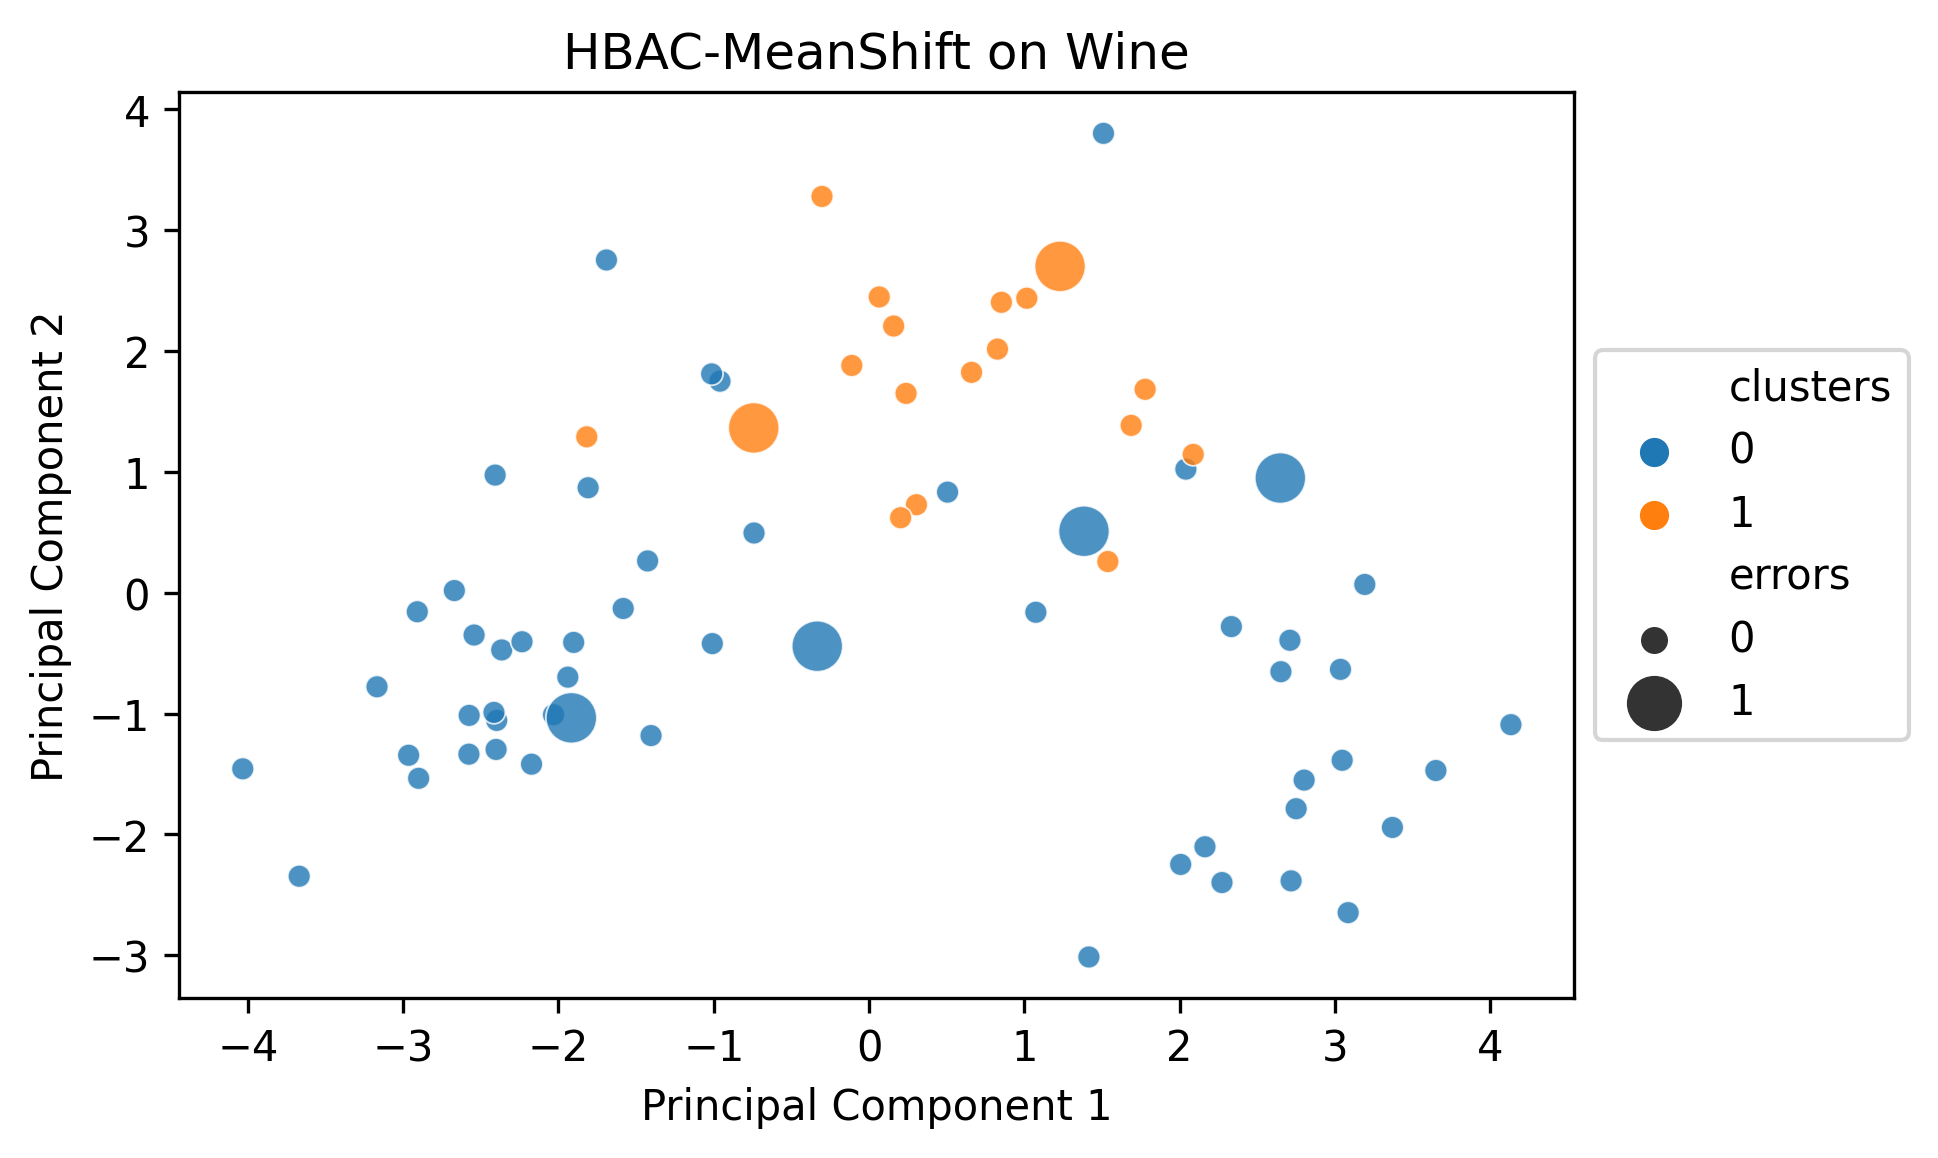

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


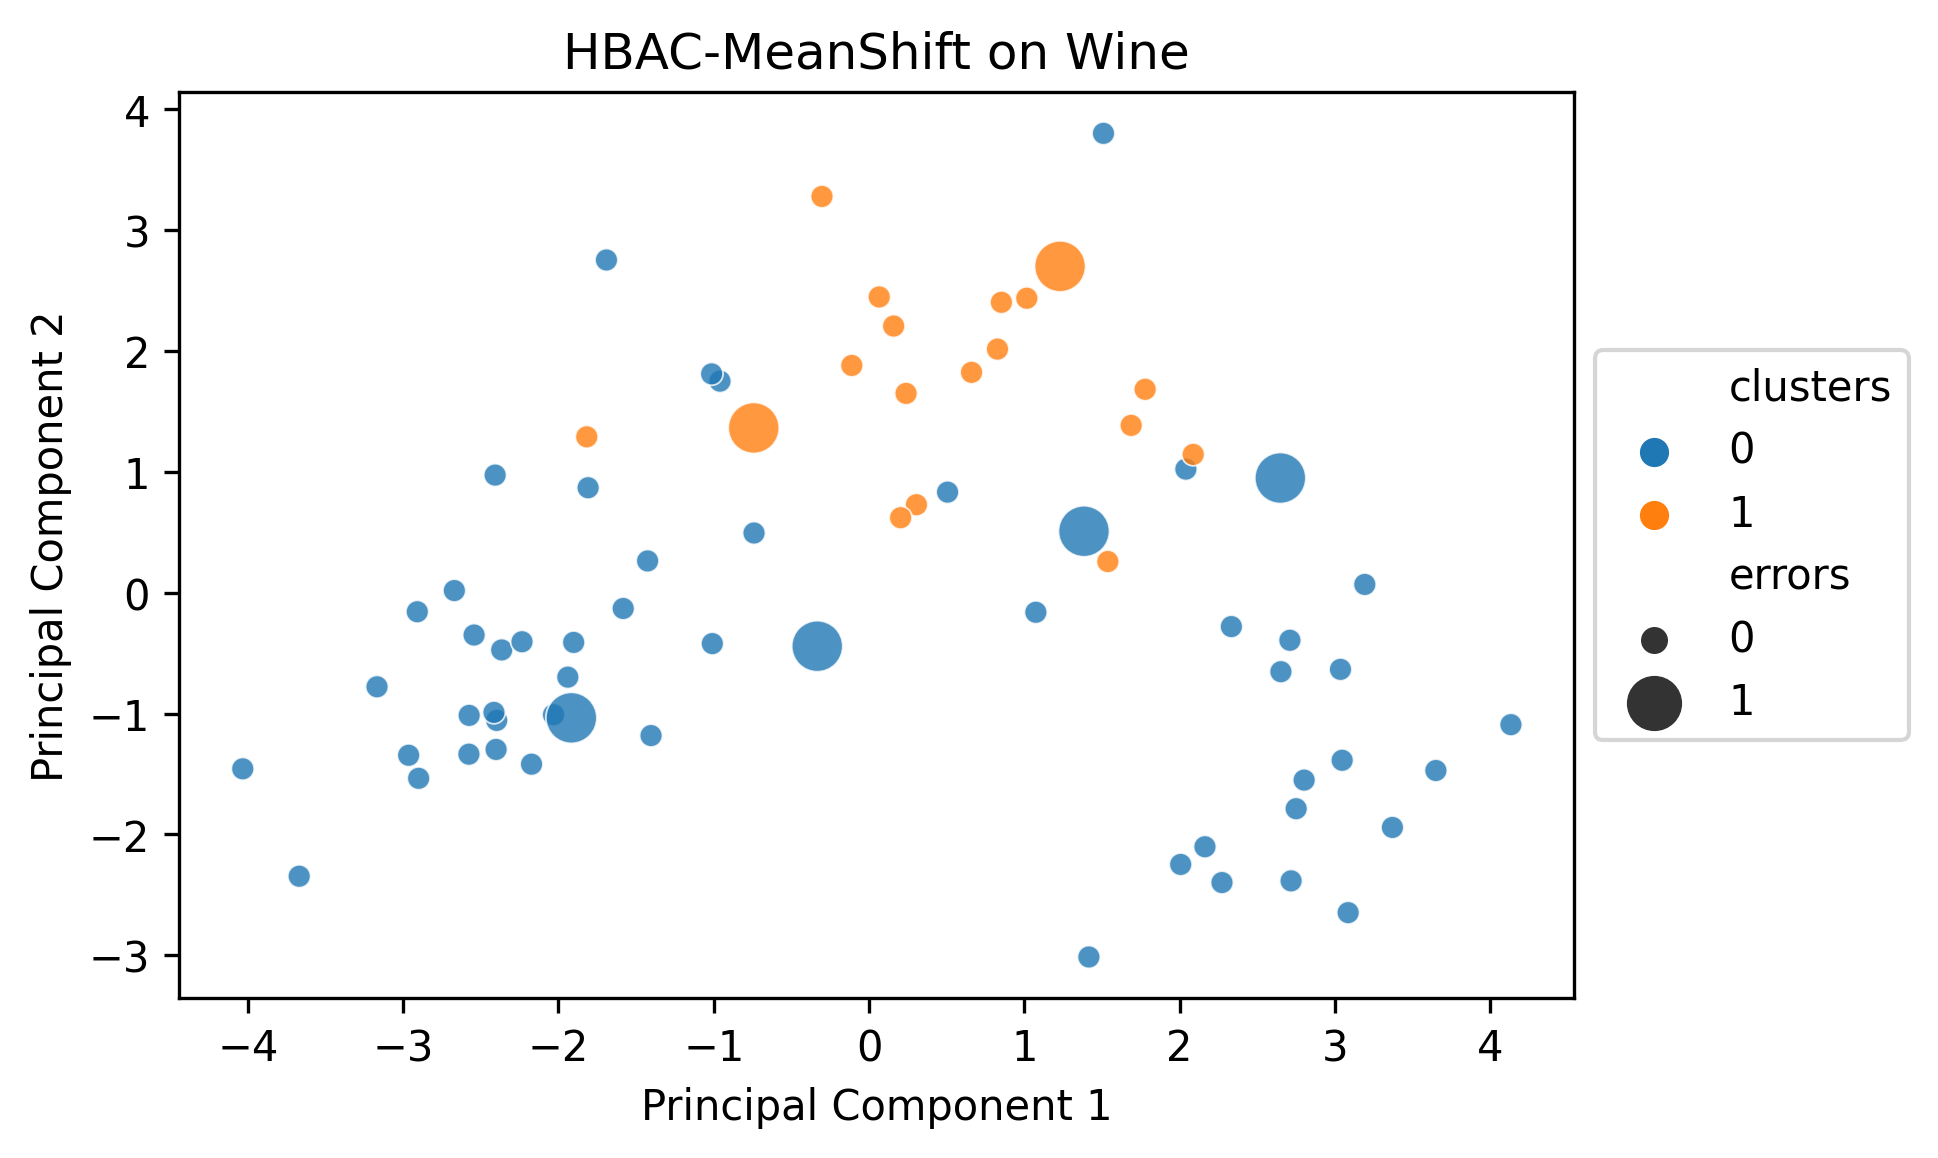

--> Cluster with the highest variance: 1
This is the current cluster:  1
discriminating bias is: -999999
smallest cluster: 18


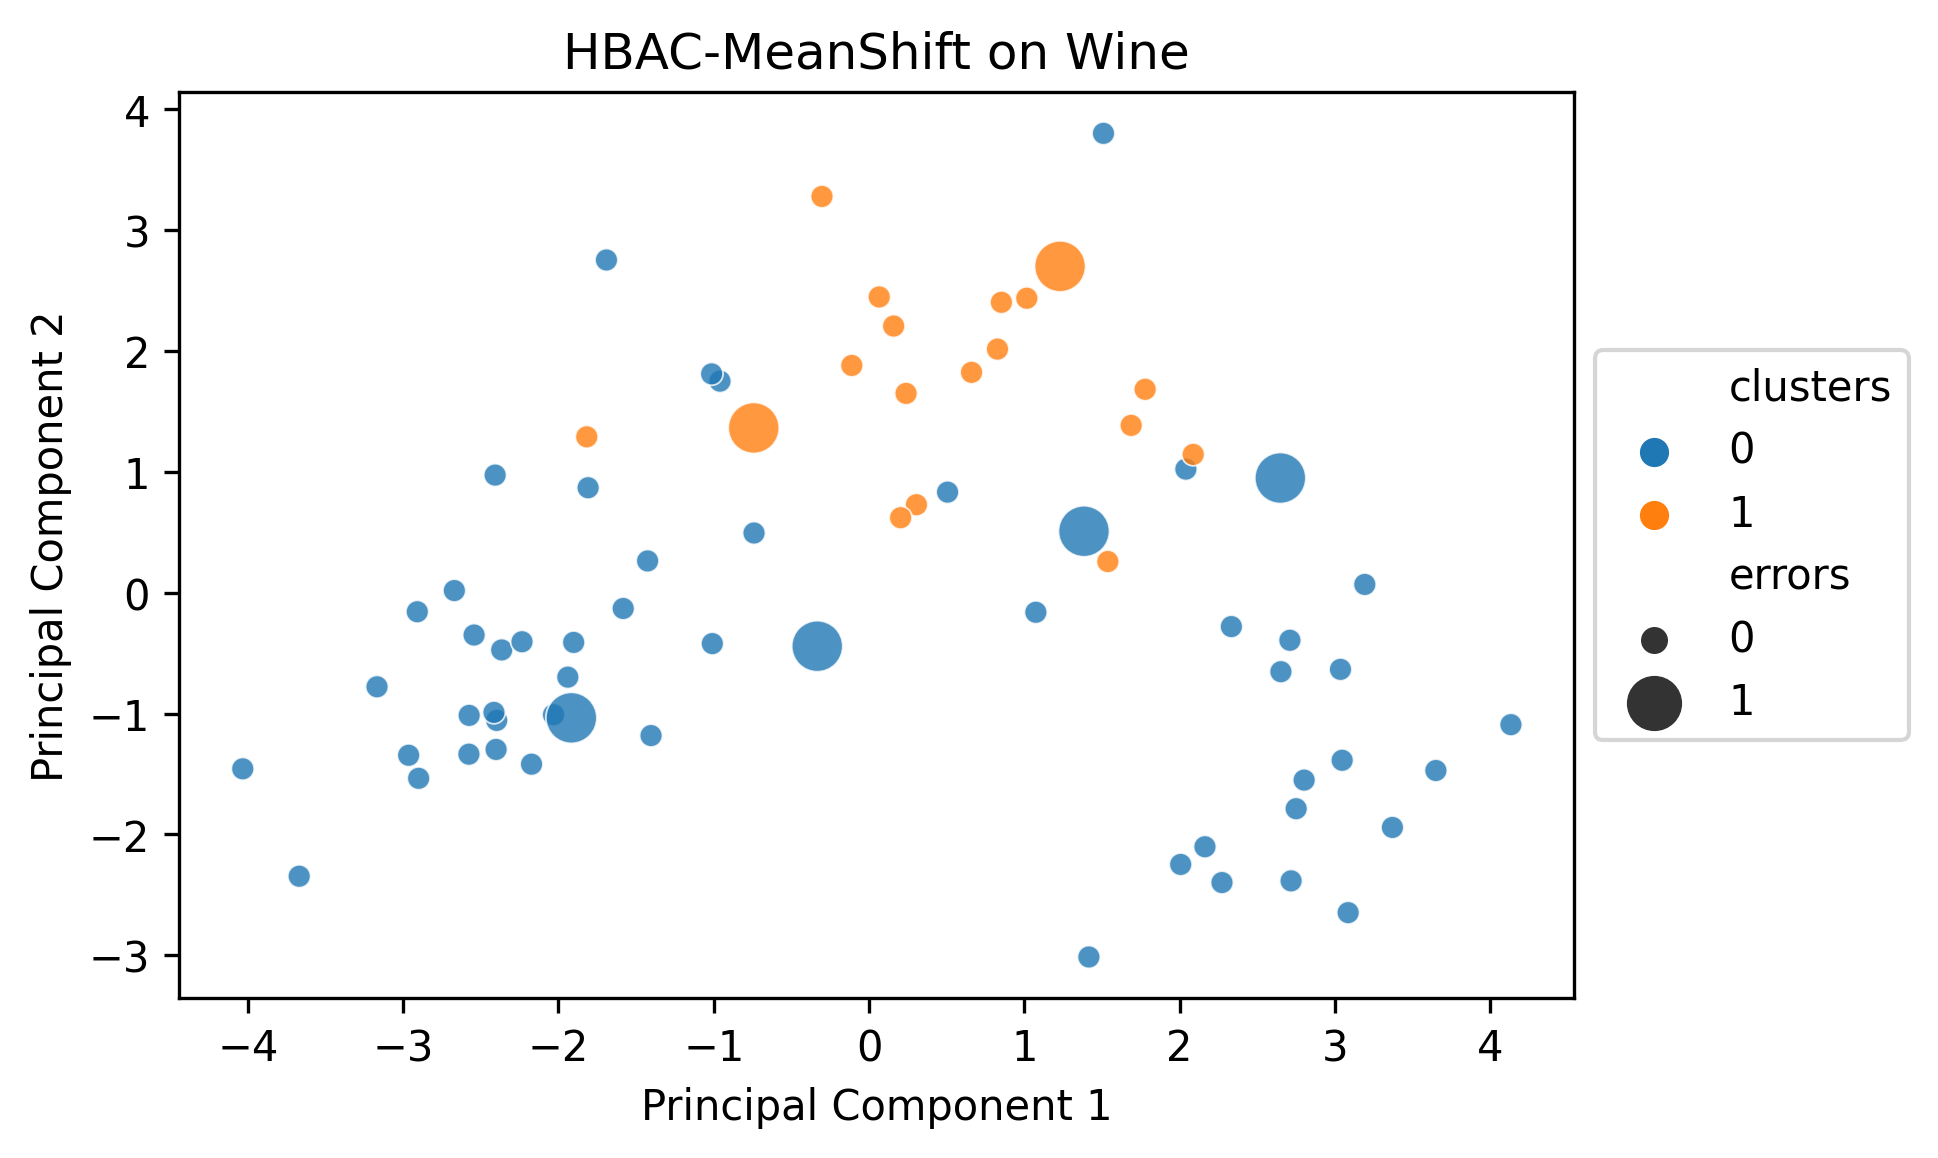

--> Cluster with the highest variance: 1
MAX_ITER
[0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572, 0.0013717421124828572]


In [7]:
MAX_ITER = 30
x = 0 # cluster number
initial_bias = 0
bw1 = 3
# bw1 = estimate_bandwidth(bandwidth_features)
# print('estimated bandwidth: ', bw1)
pca_plot(full_data, 'HBAC-MeanShift on Wine', 0.8)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = round(0.01 * len(full_data))
minimal_acceptable_cluster_size = round(0.01 * len(full_data))
print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    print('This is the current cluster: ', x)
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class','true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters']) 

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster:",min_new_size)
    if (max_neg_bias <= initial_bias) & (min_new_size >= minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data, 'HBAC-MeanShift on Wine', 0.8)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## Analysing the biased cluster

In [9]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

1 has bias -0.03703703703703709
0 has bias 0.03703703703703709
cluster with the highest discriminating bias: 1
General accuracy of classifier on this dataset: 0.9166666666666666
cluster 1 has the highest discrimination bias
-0.03703703703703709


Number of instances in discriminated cluster: 18
Number of errors in discriminated clusters:  2
found discriminated cluster:


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
101 -0.554648   -0.822143 -1.438148          -0.100709  -0.793991   
91  -1.317487   -0.673524  0.325503           0.882957  -0.907193   
92  -0.440222   -0.656039 -0.217159           0.517596  -1.246801   
103 -1.546339   -0.489935 -1.505980           0.180339  -0.907193   
102 -0.885212    0.148255  0.461168           0.601910  -0.227978   
75  -1.749763   -0.350057 -1.370315          -0.803327  -0.284579   
64  -1.101350   -0.725978  0.698583           0.039815   0.111630   
126 -0.770786   -0.656039 -0.115410           0.742434  -0.907193   
98  -0.847070   -1.058186 -0.759821          -0.100709  -0.793991   
76  -0.007946   -1.206806 -2.082559          -0.803327  -0.907193   
62   0.805749   -0.900824 -1.370315          -0.241232  -0.454383   
81  -0.402080   -0.411254 -0.420657          -0.016394  -0.907193   
80  -1.317487   -1.189321 -1.098984           0.039815  -0.907193   
106 -0.999638   -0.481192 -0.691988           0.039815  -1.246801   
60  -0.897926   -1.031959 -0.149326          -0.803327  -0.058174   
127 -1.584481   -0.131499  1.546492           2.709765  -0.567586   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
101      -1.259563   -0.660111             -0.525631        -0.416026   
91       -1.259563   -0.762724              1.161744         0.024704   
92       -1.364962   -0.566828              1.804554         0.008963   
103       0.321426   -0.398917              0.117179        -0.305844   
102       0.411768    0.039516             -0.123875        -0.478987   
75       -1.018650   -0.464216             -0.123875        -0.730833   
64       -0.597053   -0.296305              0.759988        -0.919717   
126       0.682795    1.009666              0.277881         0.245068   
98        1.857243    1.569368             -0.927387         0.528395   
76       -0.506711   -0.035111             -0.927387        -0.242882   
62       -0.280856   -0.258992             -0.284577        -1.391927   
81       -0.130285    0.431307             -0.766684         0.245068   
80        0.200970    0.179441             -0.445279        -0.290103   
106      -0.958422   -0.035111              0.117179         0.024704   
60       -0.356141   -0.911977              2.206310        -1.895618   
127      -0.235684    0.160785              1.804554         0.229328   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
104        -1.025689  0.361193     1.354564 -0.225753            0.0   
67         -0.239382  0.710266     1.229242 -0.714467            0.0   
101        -1.247121  0.361193     0.240588 -0.557596            0.0   
91         -0.727435  0.404827     0.073491 -0.895472            0.0   
92         -0.975980  0.012121    -0.748066 -0.759718            0.0   
103        -1.423362 -0.075148    -0.218927 -1.001058            0.0   
102        -1.088955 -0.686025     1.089995 -0.931673            0.0   
75         -0.637055  1.190241    -0.636668 -0.961840            0.8   
64         -1.021170  2.150191    -0.511346 -1.182063            0.0   
126        -0.573788 -1.166000     0.338061 -1.191113            0.0   
98         -0.320724  0.361193     0.240588 -0.261954            0.0   
76         -0.275534  1.015705    -0.163228 -1.070443            0.0   
62         -0.637055  1.190241    -0.191078 -0.352457            0.0   
81         -0.591864  0.884802     0.755802 -0.099050            0.8   
80         -1.224526  1.844752     0.727953 -1.414353            0.0   
106        -0.817815  0.186657     0.797576 -0.714467            0.0   
60         -0.876562  1.277509    -1.291129 -0.201619            0.0   
127       

alcohol
this is the t-statistic -5.778657084560804
this is the p-value: 5.997058314663258e-07
malic_acid
this is the t-statistic -5.358951009388898
this is the p-value: 1.0200476502347033e-06
ash
this is the t-statistic -3.093762407197073
this is the p-value: 0.0042842317189835015
alcalinity_of_ash
this is the t-statistic 1.1062503641461372
this is the p-value: 0.2754575868384393
magnesium
this is the t-statistic -5.797955117894309
this is the p-value: 1.9494235754680442e-07
total_phenols
this is the t-statistic -1.5269361592788087
this is the p-value: 0.1349643797833385
flavanoids
this is the t-statistic -0.4254765830196001
this is the p-value: 0.6721805654175261
nonflavanoid_phenols
this is the t-statistic 0.8676769095815989
this is the p-value: 0.3924135208388304
proanthocyanins
this is the t-statistic -2.311588186320055
this is the p-value: 0.024793387742453075
color_intensity
this is the t-statistic -6.835333153924109
this is the p-value: 2.5006041520595688e-09
hue
this is the t-s

unscaled_discriminated  unscaled_remaining  difference
alcohol                            12.375000           13.256667   -0.881667
malic_acid                          1.512222            2.536481   -1.024259
ash                                 2.148333            2.382593   -0.234259
alcalinity_of_ash                  19.561111           18.624074    0.937037
magnesium                          88.944444          106.388889  -17.444444
total_phenols                       2.106111            2.346667   -0.240556
flavanoids                          1.996111            2.091481   -0.095370
nonflavanoid_phenols                0.377222            0.348148    0.029074
proanthocyanins                     1.385556            1.690556   -0.305000
color_intensity                     3.402222            5.812222   -2.410000
hue                                 1.085556            0.914444    0.171111
od280/od315                         2.711667            2.559074    0.152593
proline                           500.388889          828.981481 -328.592593
predicted_class                     1.000000            0.925926    0.074074
true_class                          1.000000            0.888889    0.111111
errors                              0.111111            0.074074    0.037037

alcohol  malic_acid       ash  alcalinity_of_ash  \
unscaled_discriminated  12.375000    1.512222  2.148333          19.561111   
unscaled_remaining      13.256667    2.536481  2.382593          18.624074   

                         magnesium  total_phenols  flavanoids  \
unscaled_discriminated   88.944444       2.106111    1.996111   
unscaled_remaining      106.388889       2.346667    2.091481   

                        nonflavanoid_phenols  proanthocyanins  \
unscaled_discriminated              0.377222         1.385556   
unscaled_remaining                  0.348148         1.690556   

                        color_intensity       hue  od280/od315     proline  \
unscaled_discriminated         3.402222  1.085556     2.711667  500.388889   
unscaled_remaining             5.812222  0.914444     2.559074  828.981481   

                        predicted_class  true_class    errors  \
unscaled_discriminated         1.000000    1.000000  0.111111   
unscaled_remaining             0.925926    0.888889  0.074074   

                                         index  
unscaled_discriminated  unscaled_discriminated  
unscaled_remaining          unscaled_remaining

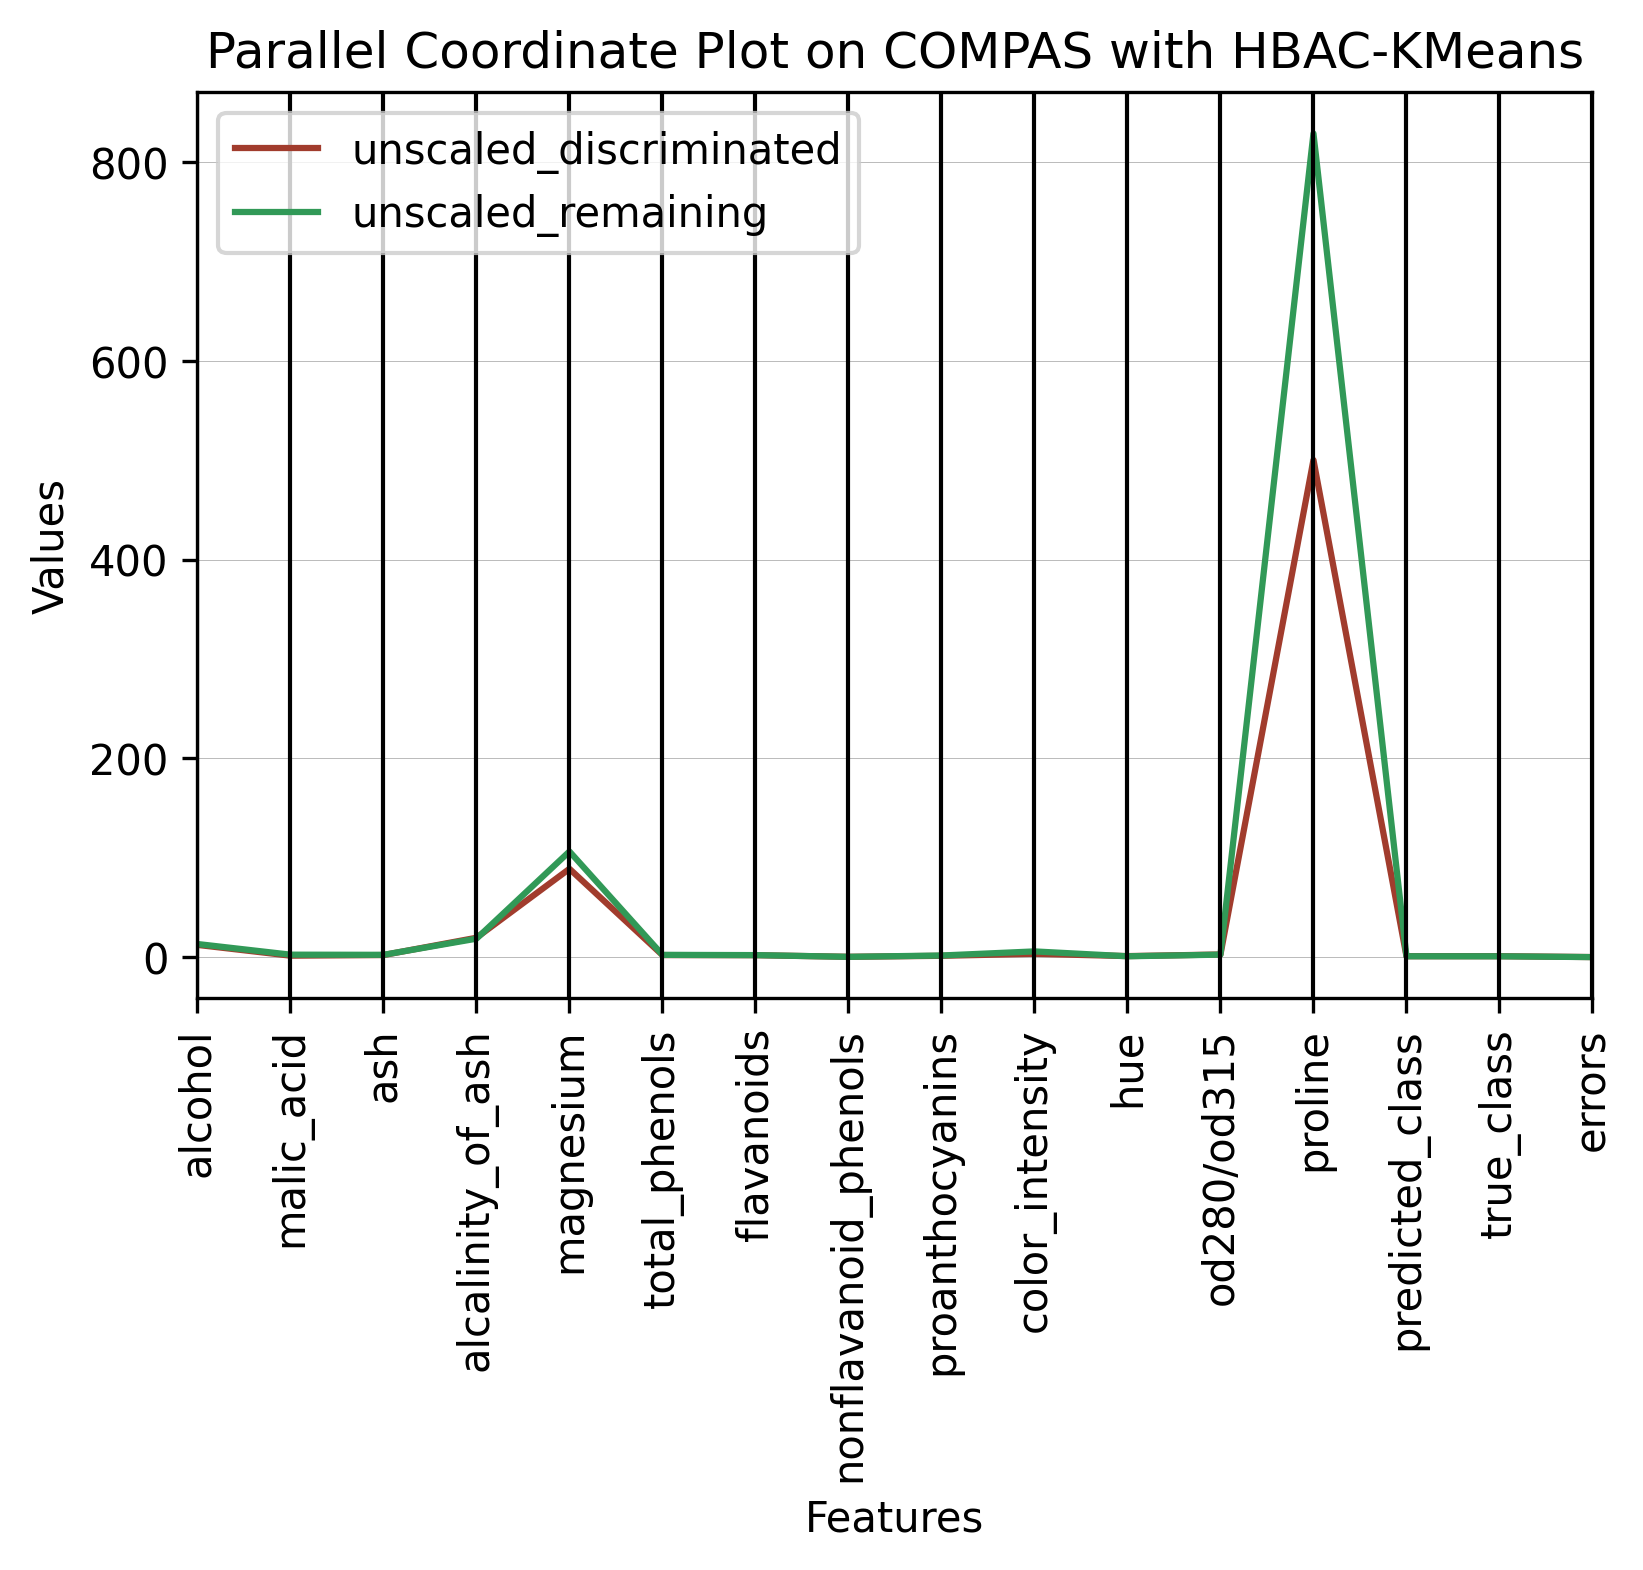

In [10]:
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on COMPAS with HBAC-KMeans")

## Ridgeline / Density plot

In [11]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
104    12.51        1.73  1.98               20.5       85.0           2.20   
67     12.37        1.17  1.92               19.6       78.0           2.11   
101    12.60        1.34  1.90               18.5       88.0           1.45   
91     12.00        1.51  2.42               22.0       86.0           1.45   
92     12.69        1.53  2.26               20.7       80.0           1.38   
103    11.82        1.72  1.88               19.5       86.0           2.50   
102    12.34        2.45  2.46               21.0       98.0           2.56   
75     11.66        1.88  1.92               16.0       97.0           1.61   
64     12.17        1.45  2.53               19.0      104.0           1.89   
126    12.43        1.53  2.29               21.5       86.0           2.74   
98     12.37        1.07  2.10               18.5       88.0           3.52   
76     13.03        0.90  1.71               16.0       86.0           1.95   
62     13.67        1.25  1.92               18.0       94.0           2.10   
81     12.72        1.81  2.20               18.8       86.0           2.20   
80     12.00        0.92  2.00               19.0       86.0           2.42   
106    12.25        1.73  2.12               19.0       80.0           1.65   
60     12.33        1.10  2.28               16.0      101.0           2.05   
127    11.79        2.13  2.78               28.5       92.0           2.13   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
104        1.92                  0.32             1.48             2.94  1.04   
67         2.00                  0.27             1.04             4.68  1.12   
101        1.36                  0.29             1.35             2.45  1.04   
91         1.25                  0.50             1.63             3.60  1.05   
92         1.46                  0.58             1.62             3.05  0.96   
103        1.64                  0.37             1.42             2.06  0.94   
102        2.11                  0.34             1.31             2.80  0.80   
75         1.57                  0.34             1.15             3.80  1.23   
64         1.75                  0.45             1.03             2.95  1.45   
126        3.15                  0.39             1.77             3.94  0.69   
98         3.75                  0.24             1.95             4.50  1.04   
76         2.03                  0.24             1.46             4.60  1.19   
62         1.79                  0.32             0.73             3.80  1.23   
81         2.53                  0.26             1.77             3.90  1.16   
80         2.26                  0.30             1.43             2.50  1.38   
106        2.03                  0.37             1.63             3.40  1.00   
60         1.09                  0.63             0.41             3.27  1.25   
127        2.24                  0.58             1.76             3.00  0.97   

     od280/od315  proline  predicted_class  true_class  errors           bias  
104         3.57    672.0                1           1       0  discriminated  
67          3.48    510.0                1           1       0  discriminated  
101         2.77    562.0                1           1       0  discriminated  
91          2.65    450.0                1           1       0  discriminated  
92          2.06    495.0                1           1       0  discriminated  
103         2.44    415.0                1           1       0  discriminated  
102         3.38    438.0                1           1       0  discriminated  
75          2.14    428.0                2           1       1  discriminated  
64          2.23    355.0                1           1       0  discriminated  
126         2.84    352.0                1           1       0  discriminated  
98          2.77    660.0                1           1       0  discriminated  
76 

In [14]:
df_all.columns
welchtest = pd.DataFrame()
welchtest = df_all[['malic_acid', 'magnesium', 'color_intensity', 'proline', 'bias']]
welchtest.columns

Index(['malic_acid', 'magnesium', 'color_intensity', 'proline', 'bias'], dtype='object')

1
2
3
4


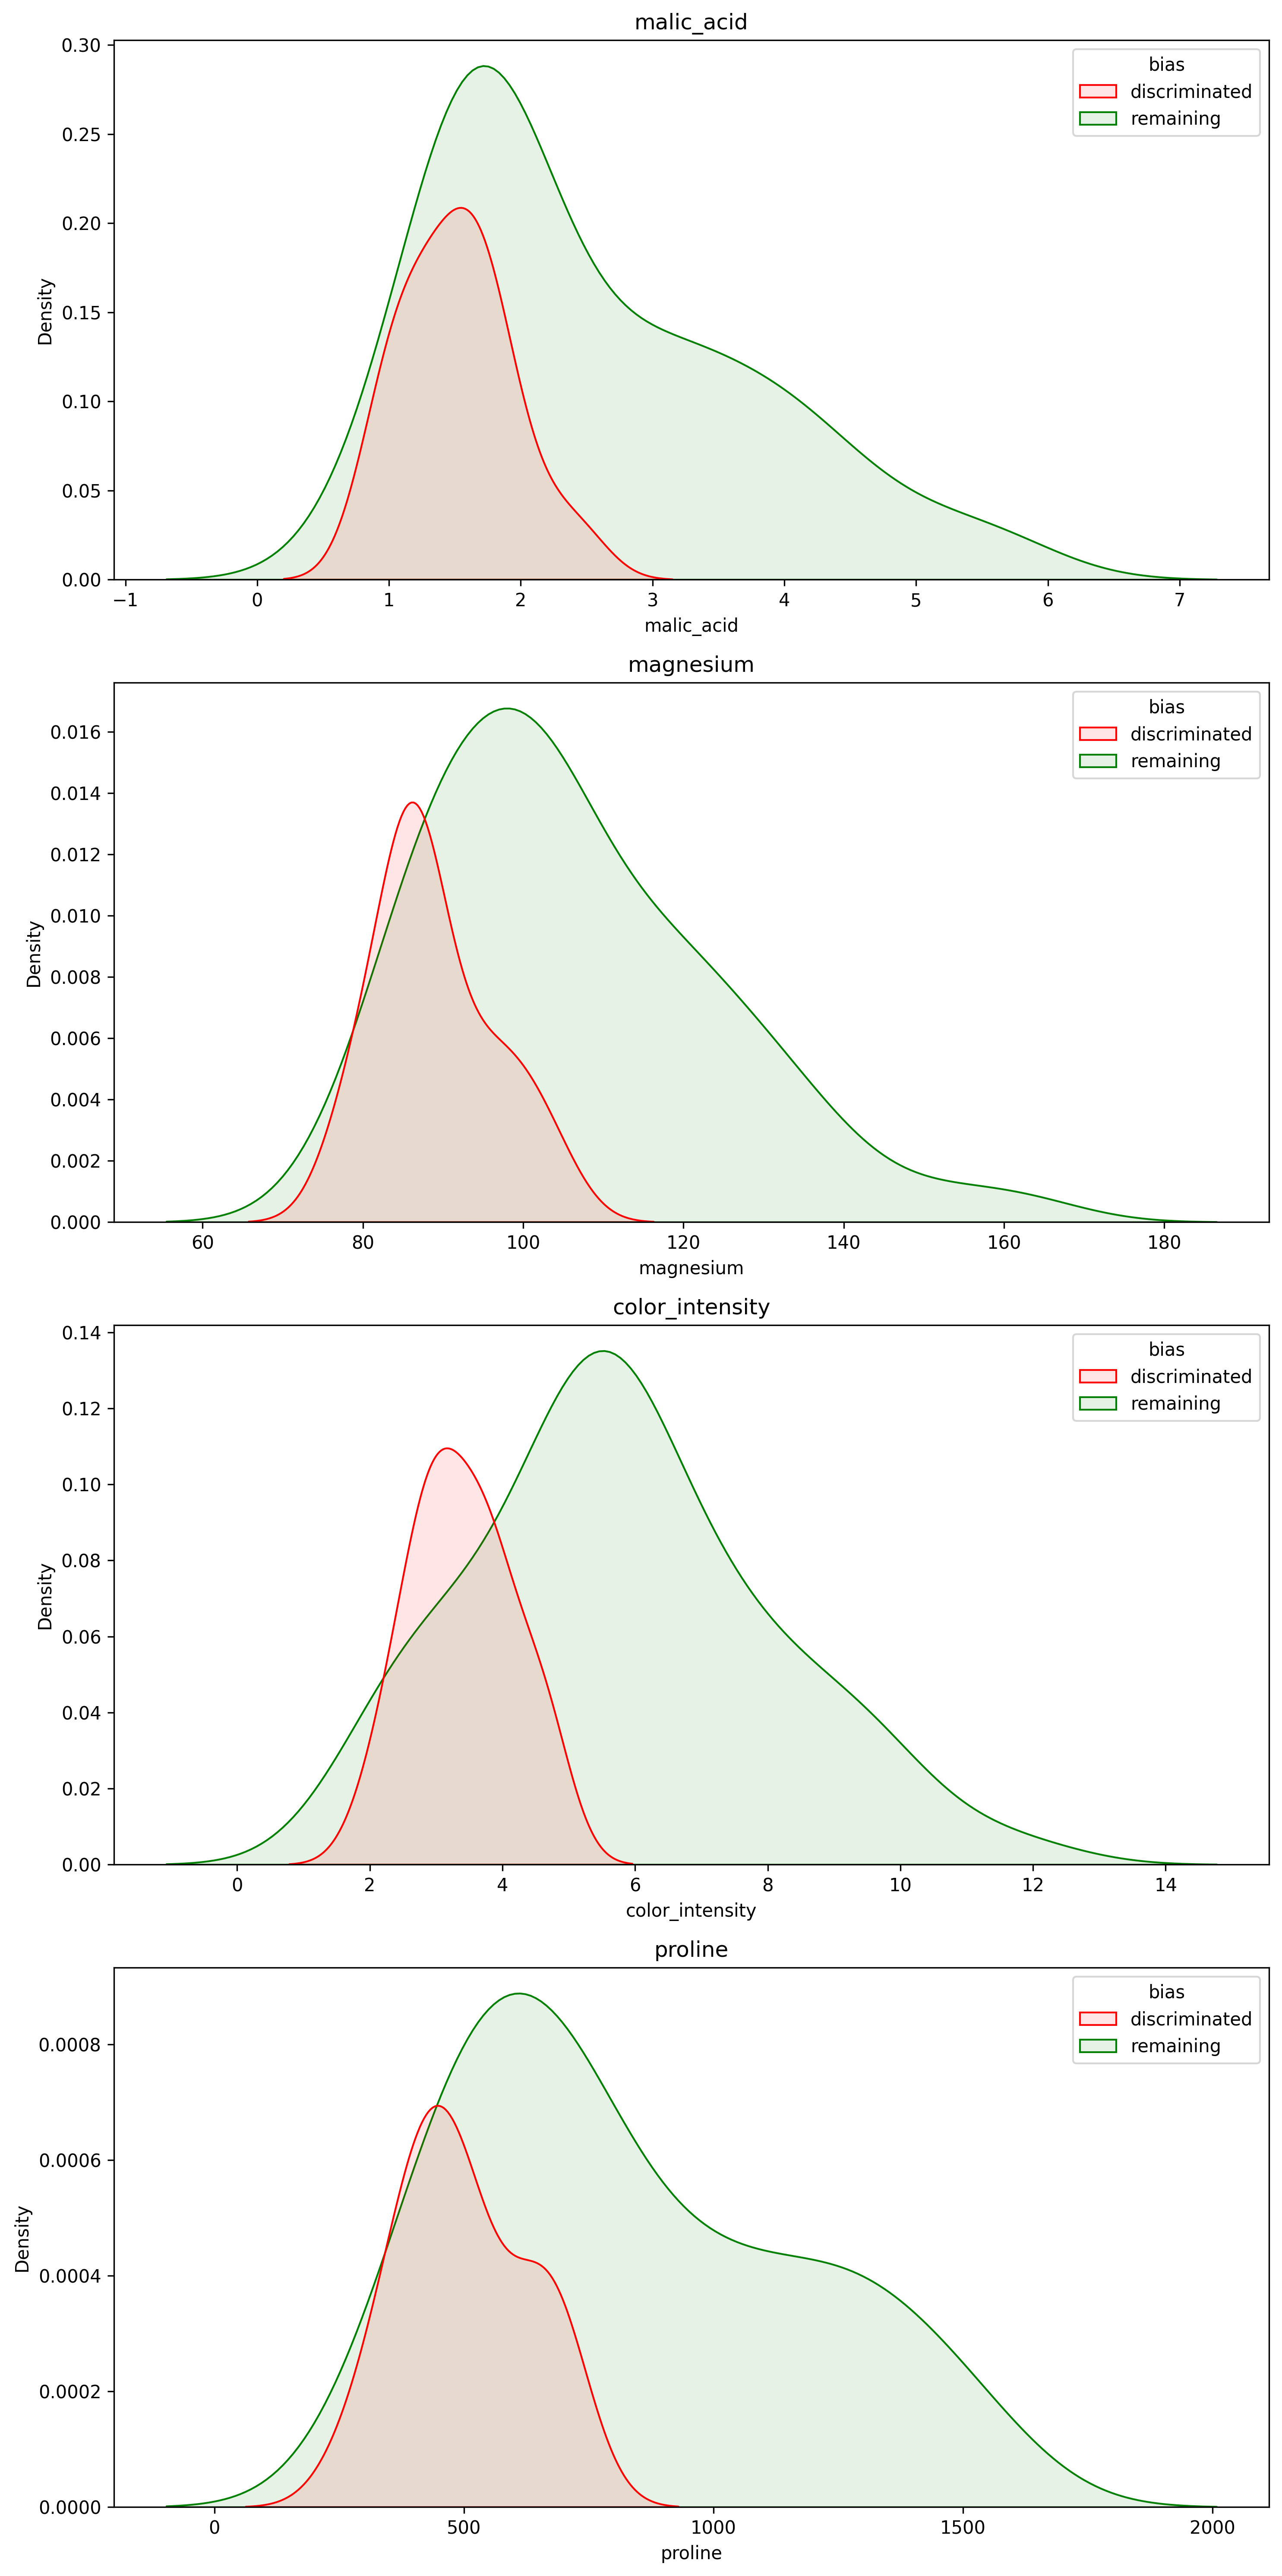

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 4: 
        break

plt.tight_layout()

plt.show()



In [19]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(200)
x2 = np.random.randn(200) + 2

group_labels = ['Group 1', 'Group 2']

colors = ['slategray', 'magenta']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x2], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

In [ ]:
import plotly.express as px
df = original_preprocessed
fig = px.histogram(df, x="alcohol", y="malic_acid", color="discriminating",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()

## Seaborn Pairplot / Density plot

In [24]:
sns.pairplot(df_all, hue="bias")

MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 10500x10500 with 196 Axes>